In [71]:
# from abinitio_tm import abinitio 
import numpy as np
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from heatmaps_generate import * 
from vcf_mhs import *
import argparse



# change plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [177]:
# this script generates a tm as per Schiffels' equations - i.e. these are the theoretical transition probabilities

# it needs: an N_0, N_T and a lambda array which corresponds to population size per time interval

import math
import numpy as np
import pdb

def abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
        return q_2

    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

def corrected_abinitio(T,N_T,pop_size,N_0,mu=2e-08,r=2e-08):
    """
    inputs:
    pop_size in absolute diploid...these will be scaled
    T: time_array in coalescent time (gens/(2*N))
    N_T: number of states
    """
    print(f'pop_size is {pop_size}')
    def lambda_(int):
        lambd= N_0/(pop_size[int])
        return lambd
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i,T)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    def delta(int,T):
        # difference in each time interval
        delta_ = T[int+1] - T[int]
        return delta_
    
    def expected_time(int, T):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i,T)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int,T)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int,T)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # stationary distribution, eq 23
    # do i even use this?
    def q_0(int):
        q_0 = L(T[0],T[int]) * (1 - math.exp(-delta(int,T) * lambda_(int)))
    
    def q_2_sum1(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = (1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))*(L(T[j+1],T[alpha])**2)
            sum_q = sum_q + iteration
        return sum_q

    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix
    def upper_diag(q_2):
        for alpha in range(0,N_T):
            for beta in range (alpha+1,N_T):
                q_2[alpha, beta] = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                        (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) + (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                                )
                pre = (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = (1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))) * q_2_sum1(alpha) 
#                 print('with L(alpha)^2 = {} and H_i(alpha) = {} and H_alpha(alpha)= {}'.format(L(T[alpha+1],T[alpha])**2,(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T))),(1/(2*lambda_(alpha)))*(1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha)))))
                B = (1 / (2 * lambda_(alpha))) * (delta(alpha,T) - (1 / (2 * lambda_(alpha))) * (1 - math.exp(-2 * delta(alpha,T) * lambda_(alpha))))
                print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2

    # this is for the summation in lower diag of q_2, eq 28. j is lowercase gamma
    def q_2_sum2(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 28 is to (beta - 1), but add to range one so python includes the (beta -1) term
            iteration = (L(T[j+1],expected_time(beta,T))**2)*(1/(2*lambda_(j)))*(1 - math.exp(-2*lambda_(j)*delta(j,T)))
            sum_q = sum_q + iteration
        return sum_q

    # function to write lower triangular of q_2, eq 28. Give as input an N_T x N_T matrix - can be nonempty (though lower traingular will be overwritten)
    def lower_diag(q_2):
        for alpha in range (0,N_T):
            for beta in range(0,alpha):
                q_2[alpha, beta] = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) * (
                                        q_2_sum2(beta) + (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                                )
                pre = L(expected_time(beta,T), T[alpha]) * (1 / lambda_(alpha)) * (1 - math.exp(-delta(alpha,T) * lambda_(alpha))) * (1 - math.exp(-2 * rho * expected_time(beta,T))) * (1 / expected_time(beta,T)) * lambda_(alpha) 
                A = q_2_sum2(beta)
                B = (1 / (2 * lambda_(beta))) * (1 - math.exp(-2 * lambda_(beta) * (expected_time(beta,T) - T[beta])))
                print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))

        return q_2

    # flagpan
    
    lambda_array = [lambda_(i) for i in range(0,N_T)]
    print(lambda_array)
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i,T) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    # initialise q_2, which is whole transition matrix
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    return q_2, q_2_upper, q_2_lower, q_1, q_

# def structured_abinitio(T,N_T,pop_size,gamma_array,N_0,mu=2e-08,r=2e-08):  
    
#     def G(t1,t2,gamma_array,lambda_array,T):
#         """
#         Takes as input t1 and t2 in scaled coalescent time
#         t1, t2: can be boundaries or some number between a boundary
#         Needs also gamma_array and lambda_array
        
#         t1, t2: can be boundaries or some number between a boundary
#         T: array of time intervals in coalescent time
#         lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
#         gamma_array: array of population split fractions per time
        
        
#         """
#         def lower_higher_intervals(t1,t2):
#             # get the index of the next lower or equal time intervals for t1 and t2
#             ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
#             if T[ind1] > t1:
#                 ind1 = ind1 - 1
#             print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
#             ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
#             if T[ind2] > t2:
#                 ind2 = ind2 - 1
#             print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
#             return ind1, ind2

#         def G_start(t1,ind1):
#             # first part of G; see my notepad page TODO
#             G_start = 1 - ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 ) + 
#             ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2)*np.exp(-lambda_array[ind1]*(T[ind1+1] -t1))
#             return G_start
#         def G_end(t2,ind2)
#             # last part of G; see my notepad TODO
#             G_end = 1 - ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 ) + 
#             ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2)*np.exp(-lambda_array[ind2]*(t2 - ind2 ))
#             return G_end
#         def G_main(ind1,ind2):
#             # main part of G (the recursive part; the product); see my notepad page TODO
#             recursion = 1
#             for i in range(ind1+1,ind2): # TODO check ind_high range
#                 G = 1 - ( (1-gamma_array[i])**2 + (gamma_array[i]**2) ) + ( (1-gamma_array[i])**2 + (gamma_array[i]**2) )*np.exp(-(lambda_array[i]*delta[i]))
#                 recursion = recursion*G
#             return recursion
#         def G_same(t1,t2,ind1):
#             # if t1 and t2 are within the same interval
#             G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
#             return G
        
#         ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
#         if ind1 == ind2: # if they are in the same interval
#             G = G_same(t1,t2,ind1) 
#         elif ind1 == (ind2-1): # if they are one interval apart
#             G = G_start(t1,ind1)*G_end(t2,ind2)
#         else: # otherwise; there is some distance between them
#             G = G_start(t1,ind1)*G_main(ind1,ind2)*G_end(t2,ind2)
#         return G
#         # TODO try this on my distribution till coalesence thingtime

In [3]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

In [7]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

print(f'T_np is {T_np}\n\n')
print(f'T_scaled_np is {T_scaled_np}')

T_np is [0.         0.03678794 0.04090434 0.04548135 0.0505705  0.05622911
 0.06252089 0.06951668 0.07729528 0.08594426 0.09556103 0.10625386
 0.11814318 0.13136285 0.14606175 0.16240538 0.18057779 0.20078361
 0.22325037 0.24823105 0.27600695 0.30689085 0.34123052 0.37941263
 0.42186715 0.46907213 0.52155912 0.57991917 0.64480944 0.71696063
 0.79718521 0.88638654 0.98556909 1.0958497  1.21847021 1.35481138
 1.5064085  1.67496864 1.86238987 2.07078267 2.30249366 2.56013204
 2.84659895 3.16512019 3.51928248 3.91307389 4.35092873 4.83777751
 5.3791024  5.98099905 6.65024514]


T_scaled_np is [     0.            735.75888234    818.08689348    909.62702774
   1011.41007904   1124.58218235   1250.41771984   1390.33367116
   1545.90556937   1718.88524244   1911.22053974   2125.07726597
   2362.86356935   2627.25705872   2921.23495497   3248.1076162
   3611.55581425   4015.67218228   4465.00730015   4964.62093654
   5520.13902479   6137.81701413   6824.61030959   7588.2525938
   8437.34291267

In [4]:
def remove_diagonals(matrix):
    # remove diagonals from a matrix and return everything else the same
    # matrix should be np array
    for i in range(0,len(matrix)):
        matrix[i,i] = 0
    return matrix

In [208]:
def const_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def psc_pop(seq_length):
    N_A = 10000
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N_A,growth_rate=0)
    ]
    migration_matrix = [
        [0],
        ]
    demographic_events = [
        msprime.PopulationParametersChange(time=20000, initial_size=N_A*2,growth_rate=0),
        msprime.PopulationParametersChange(time=40000, initial_size=N_A,growth_rate=0)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        migration_matrix=migration_matrix,
        demographic_events=demographic_events)
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           migration_matrix=migration_matrix,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-8,mutation_rate=2e-8)
    return sim

def split(N,mig_prop,T_1,T_2,seq_length):
    
    if not 0 < mig_prop < 1:
        print('Error. mig_prop is {} which is not between 0 and 1. Aborting\n'.format(mig_prop))
        sys.exit()
    print('N is {}'.format(N))
    print('mig_prop is {}'.format(mig_prop))
    print('t_1 is {} and t_2 is {}'.format(T_1,T_2))
    print('seq_length is {}'.format(seq_length))
    
    # initially.
    population_configurations = [
        msprime.PopulationConfiguration(
            sample_size=2, initial_size=N, growth_rate=0),
        msprime.PopulationConfiguration(
            sample_size=0, initial_size=N, growth_rate=0),
    ]
    demographic_events = [
        msprime.MassMigration(time=T_1, source = 0, dest=1,proportion=mig_prop),
        msprime.MassMigration(time=T_2, source=1, dest=0, proportion=1)
    ]
    # Use the demography debugger to print out the demographic history
    # that we have just described.
    dd = msprime.DemographyDebugger(
        population_configurations=population_configurations,
        demographic_events=demographic_events)
    print('Demographic history:\n')
    dd.print_history()
    sim = msprime.simulate(population_configurations=population_configurations,
                           demographic_events=demographic_events, length=seq_length, recombination_rate=2e-08,
                           mutation_rate=2e-08)
    return sim

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=50,type=int)
parser.add_argument("-N_T","--Number_of_states",help="The number of states you want, for the time intervals (Default is 50)",default=50,type=int)
args = parser.parse_args("m0001".split())

## Comparison for panmictic population of constant size

Compare observations against theoretical

In [96]:
sim1 = const_pop(150e+06)
# flagsim

Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



In [101]:
args

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


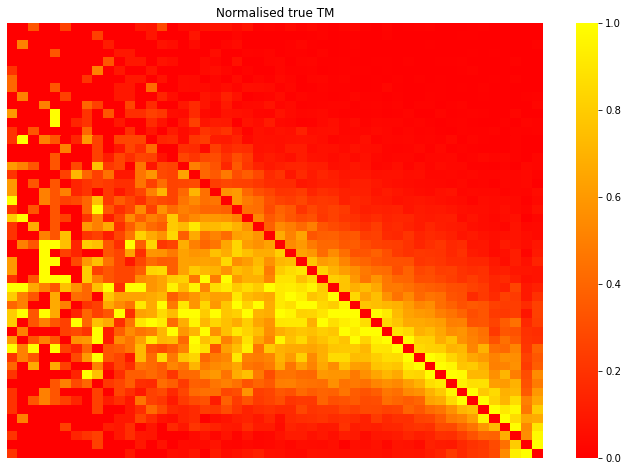

In [102]:
tmrca_data1 = get_coal_data(sim1, args) # get true coalescent 
coal_times_absolute1 = round_bin_coal_data(sim1.sequence_length,tmrca_data1, args) # partition coalescent data into bins  
coal_times1 = coal_times_absolute1/(2e+04) # scale by 2N
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals1 = round_coal_times(coal_times1,T_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm1 = tm_counts(coal_times_intervals1,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd1 = np.copy(tm1)
tm_nd1[range(0,len(tm1)),range(0,len(tm1))] = 0
tm_nd_norm1 = normalise(tm_nd1,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd1,'colmax'),title='Normalised true TM') # show heatmap


In [103]:
# print('tmrca_data1 is {}'.format(tmrca_data1))
# print('coal_times_absolute1 is {}'.format(coal_times_absolute1))  
# print('coal_times1 is {}'.format(coal_times1))
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
print('coal_times_intervals1 is {}'.format(coal_times_intervals1[0:50] ))

coal_times_intervals1 is [27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27]


pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


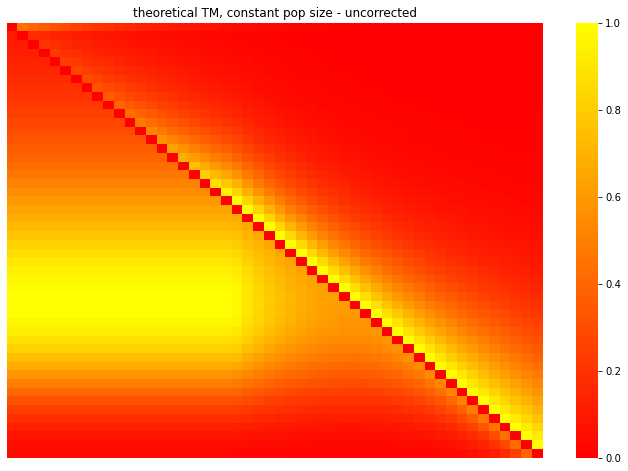

In [104]:
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2A, q_2_upperA, q_2_lowerA, q_1A, q_A = abinitio(T_np,50,pop_size1,N_0)
# type(T_np)
heatmaps_seq(normalise(q_2A,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerA,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

I think there is a mistake in Schiffels' equation 26, see my notepad page 12 and 13. Below I implement what i believe to be the correction

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


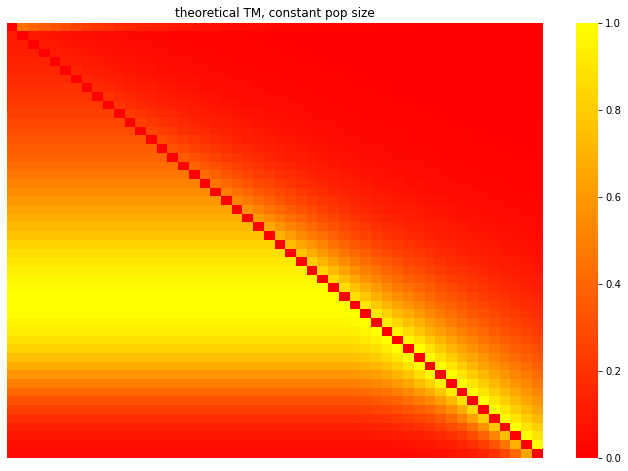

In [106]:
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Ac,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperAc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerAc,'colmax')+normalise(q_2_upperA,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

In [108]:
q_A

array([[9.99985922e-01, 5.28297031e-07, 5.28296113e-07, ...,
        5.27232304e-07, 5.27113058e-07, 5.26980657e-07],
       [5.79112389e-08, 9.99969675e-01, 2.39391662e-07, ...,
        2.38909609e-07, 2.38855574e-07, 2.38795578e-07],
       [6.41119668e-08, 1.36253635e-07, 9.99966251e-01, ...,
        2.94068791e-07, 2.94002281e-07, 2.93928433e-07],
       ...,
       [4.84502496e-08, 1.02968650e-07, 1.14496503e-07, ...,
        9.96724318e-01, 3.47986926e-04, 3.47899518e-04],
       [3.05041418e-08, 6.48287742e-08, 7.20866785e-08, ...,
        1.34405537e-04, 9.96451007e-01, 3.79787323e-04],
       [1.80275378e-08, 3.83129341e-08, 4.26022580e-08, ...,
        7.94318656e-05, 1.39854403e-04, 9.96211930e-01]])

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


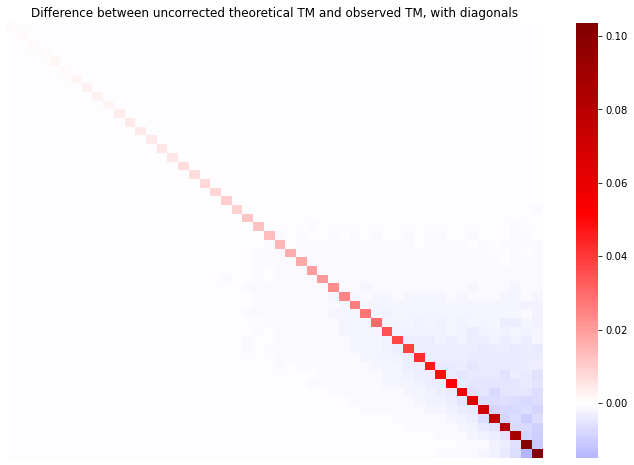

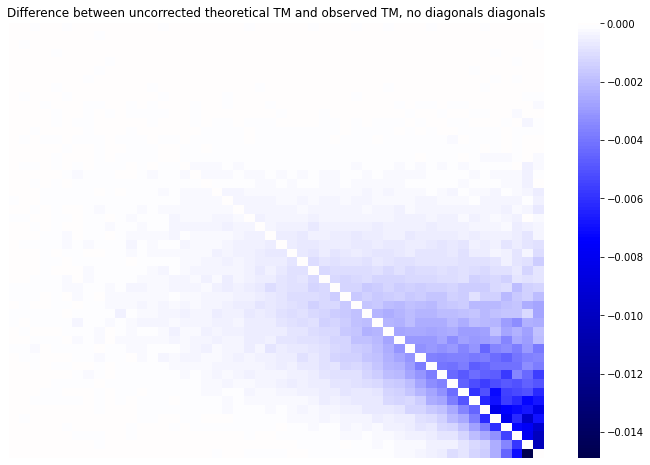

In [109]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_1 = normalise(tm1,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_tmA = q_A - tm_1
diff_q_tm_ndA = np.copy(diff_q_tmA)
diff_q_tm_ndA = remove_diagonals(diff_q_tm_ndA)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmA,title="Difference between uncorrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndA,title="Difference between uncorrected theoretical TM and observed TM, no diagonals diagonals")


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


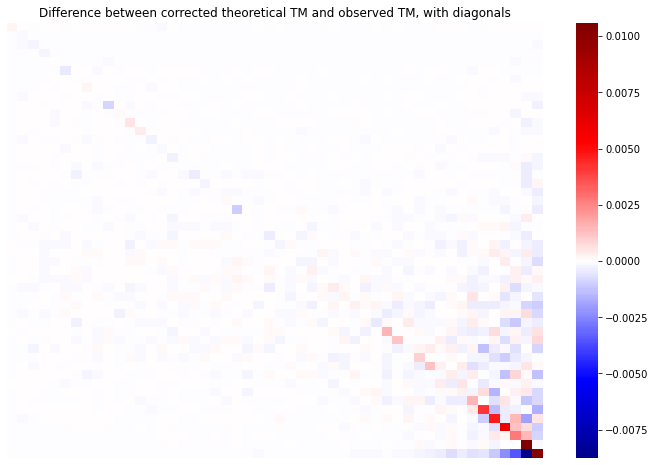

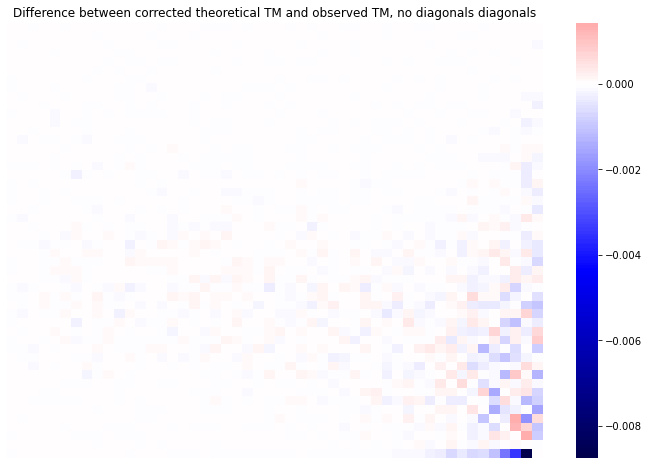

In [110]:

diff_q_tmAc = q_Ac - tm_1
diff_q_tm_ndAc = np.copy(diff_q_tmAc)
diff_q_tm_ndAc = remove_diagonals(diff_q_tm_ndAc)

# heatmaps_seq(q_2A,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_1),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_tmAc,title="Difference between corrected theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_tm_ndAc,title="Difference between corrected theoretical TM and observed TM, no diagonals diagonals")


Now compare correction vs uncorrection

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


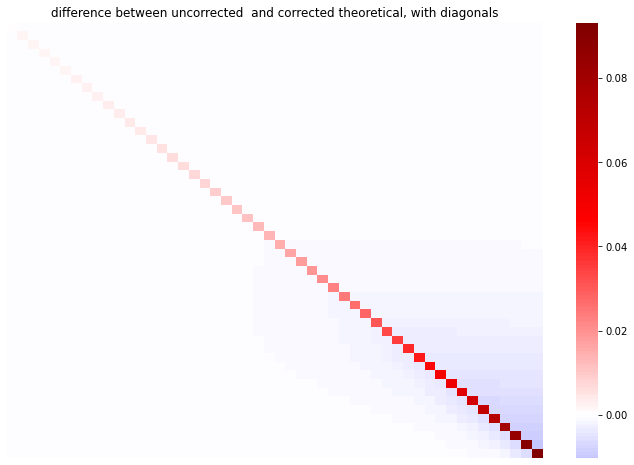

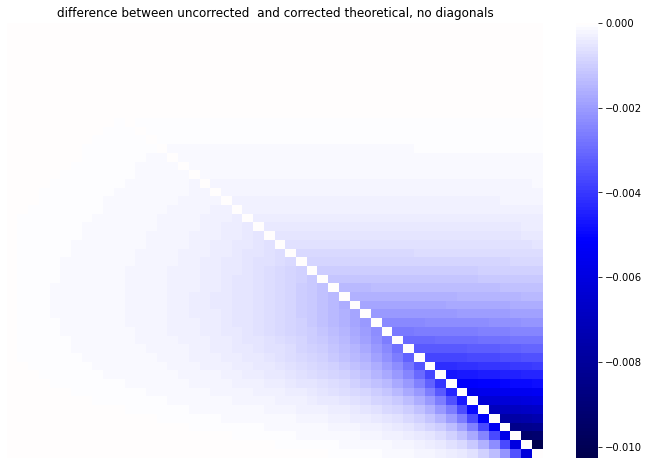

In [111]:

diff_q_A_q_Ac = q_A - q_Ac
diff_q_A_q_Ac_nd = np.copy(diff_q_A_q_Ac)
diff_q_A_q_Ac_nd = remove_diagonals(diff_q_A_q_Ac_nd)

heatmaps_div(diff_q_A_q_Ac,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_A_q_Ac_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

## Comparison for panmictic population of changing size

Compare observations against theoretical

In [73]:
sim2 = psc_pop(150e+06)


Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 20000 growth_rate -> 0 
Epoch: 20000.0 -- 40000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Events @ generation 40000.0
   - Population parameter change for -1: initial_size -> 10000 growth_rate -> 0 
Epoch: 40000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    



/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


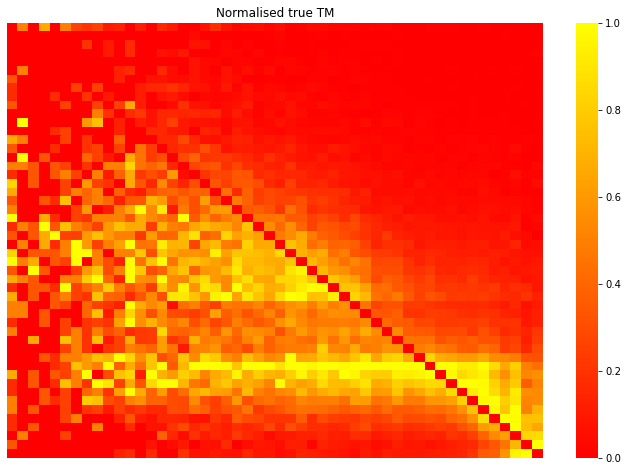

In [113]:
tmrca_data2 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute2 = round_bin_coal_data(sim2.sequence_length,tmrca_data2, args) # partition coalescent data into bins  
coal_times2 = coal_times_absolute2 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals2 = round_coal_times(coal_times2,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm2 = tm_counts(coal_times_intervals2,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd2 = np.copy(tm2)
tm_nd2[range(0,len(tm2)),range(0,len(tm2))] = 0
tm_nd_norm2 = normalise(tm_nd2,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd2,'colmax'),title='Normalised true TM') # show heatmap


In [20]:
[T_np*2*N_0][0][33:40]

array([21916.99408938, 24369.40421542, 27096.22767576, 30128.17005154,
       33499.37273618, 37247.79738688, 41415.65339448])

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


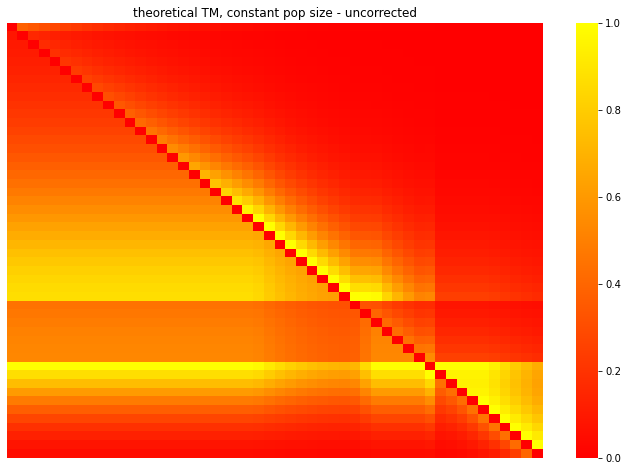

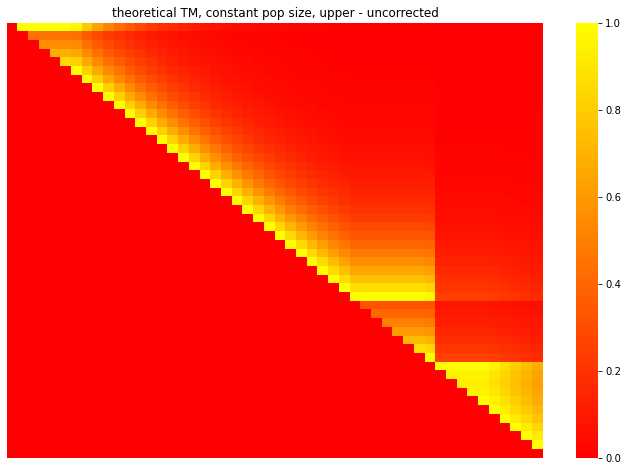

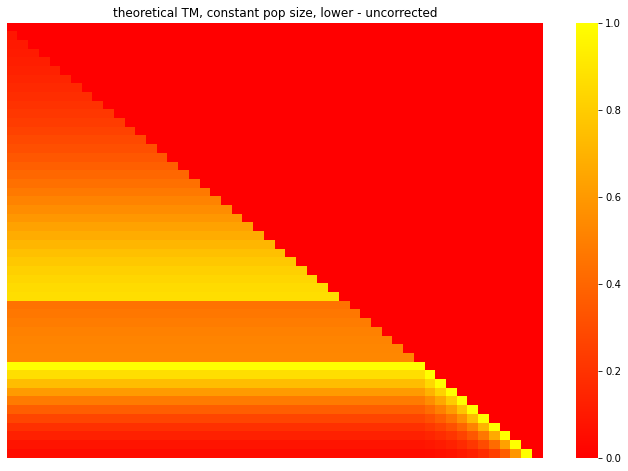

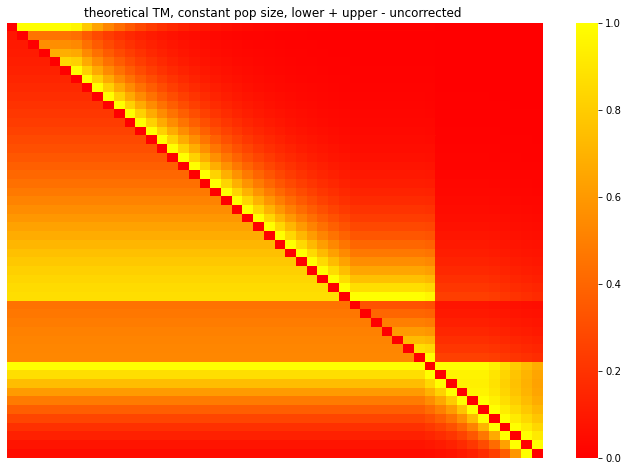

In [114]:
pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
# get_het(sim) / (4*mu) # true N_0 from sim, which I have recorded as 10149.75
# N_0 = 10149.75
q_2B, q_2_upperB, q_2_lowerB, q_1B, q_B = abinitio(T_np,50,pop_size2,N_0)
# type(T_np)
heatmaps_seq(normalise(q_2B,'colmax'),title='theoretical TM, constant pop size - uncorrected') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, upper - uncorrected') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerB,'colmax'),title='theoretical TM, constant pop size, lower - uncorrected') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerB,'colmax')+normalise(q_2_upperB,'colmax'),title='theoretical TM, constant pop size, lower + upper - uncorrected ') # normalise this matrix and then plot heatmap

I think I spotted a mistake in equation 26 ( missing factor of (1/(2*lambda_alpha)), see my notedpad page 12 and 13), so I have tried to correct it

pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


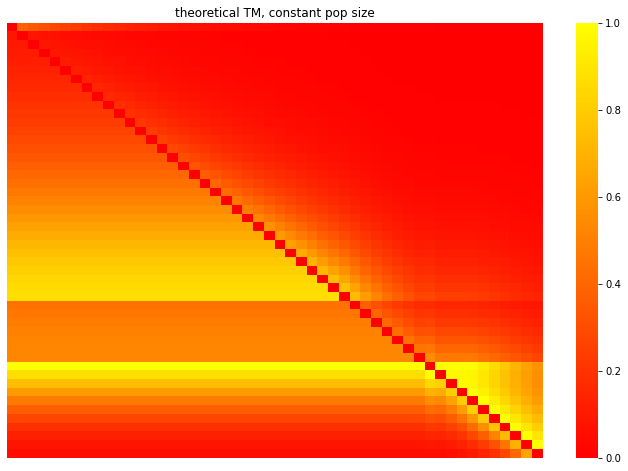

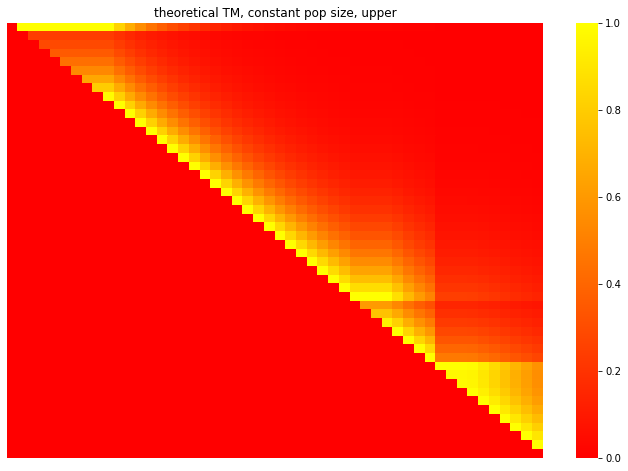

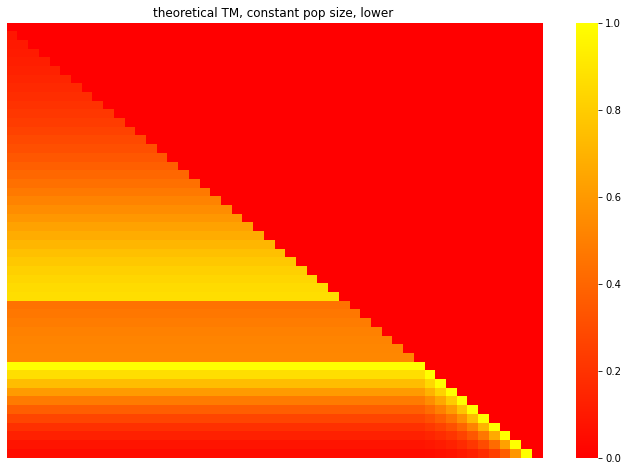

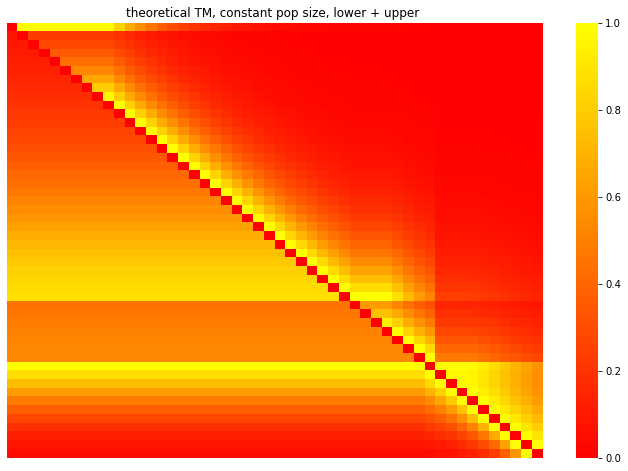

In [116]:
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap

Comparison between (un)corrected TM and observation

In [51]:
tm_2

array([[0.00000000e+00, 3.10559006e-04, 0.00000000e+00, ...,
        6.30676085e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.50940956e-06, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.88552793e-03, 1.02000785e-02],
       [1.90188191e-05, 0.00000000e+00, 9.71534052e-05, ...,
        5.54994955e-03, 0.00000000e+00, 1.03570027e-02],
       [9.50940956e-06, 0.00000000e+00, 0.00000000e+00, ...,
        8.13572149e-03, 1.33282919e-02, 0.00000000e+00]])

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


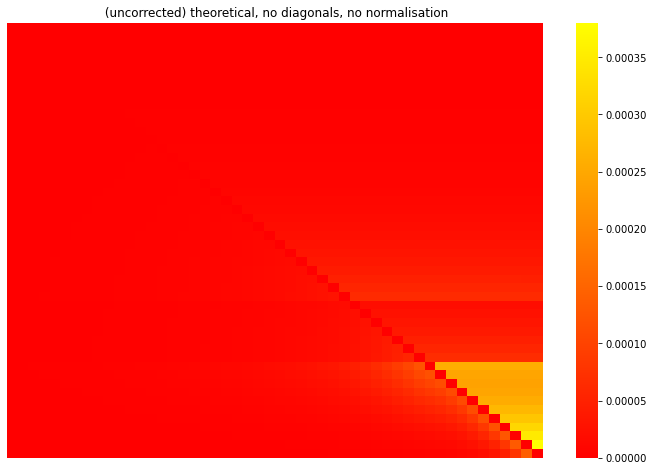

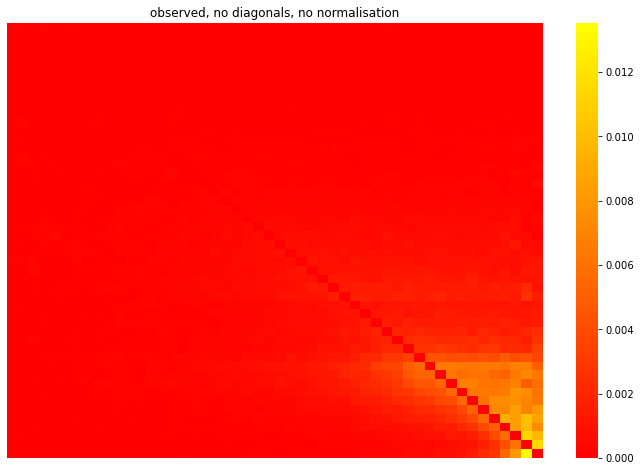

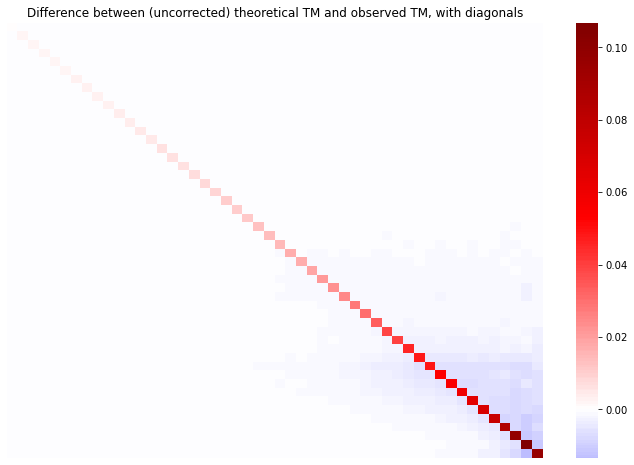

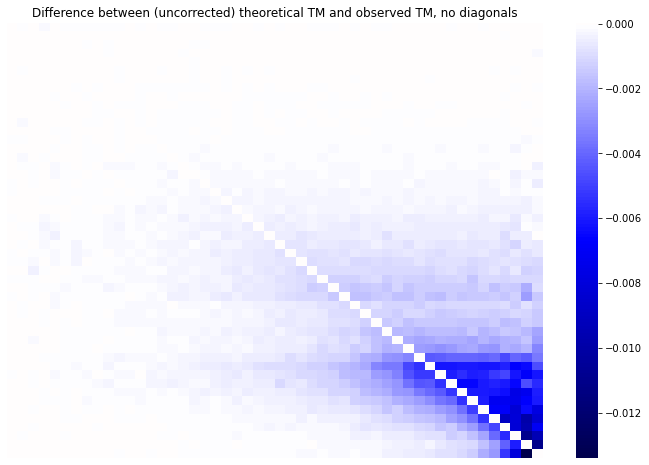

In [117]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_B_tm2 = q_B - tm_2
diff_q_B_tm_nd2 = np.copy(diff_q_B_tm2)
diff_q_B_tm_nd2 = remove_diagonals(diff_q_B_tm_nd2)

heatmaps_seq(q_2B,title=" (uncorrected) theoretical, no diagonals, no normalisation")
heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_B_tm2,title="Difference between (uncorrected) theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_B_tm_nd2,title="Difference between (uncorrected) theoretical TM and observed TM, no diagonals")


In [ ]:
# revisit


Comparison between corrected TM and observation

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


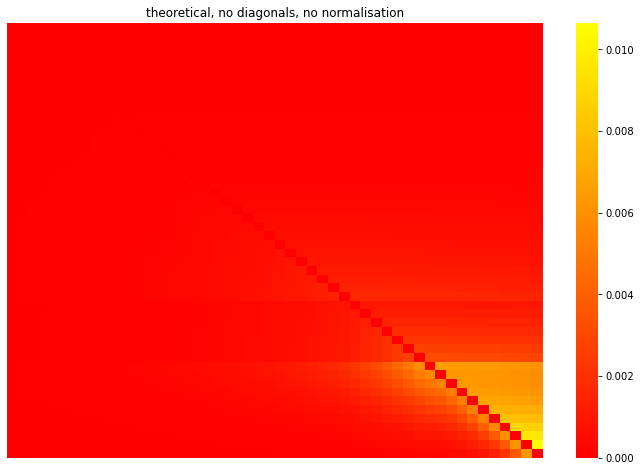

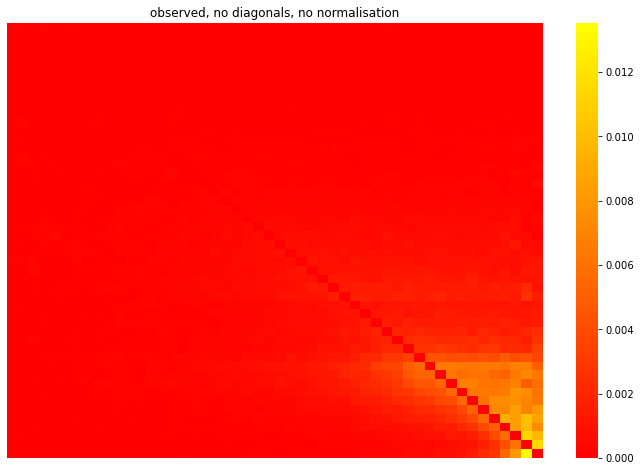

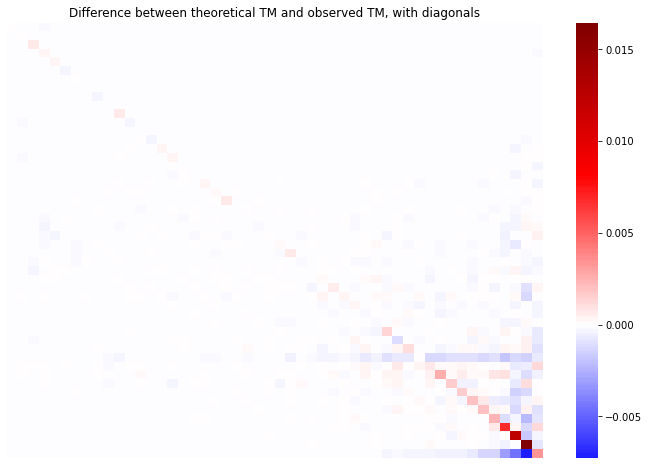

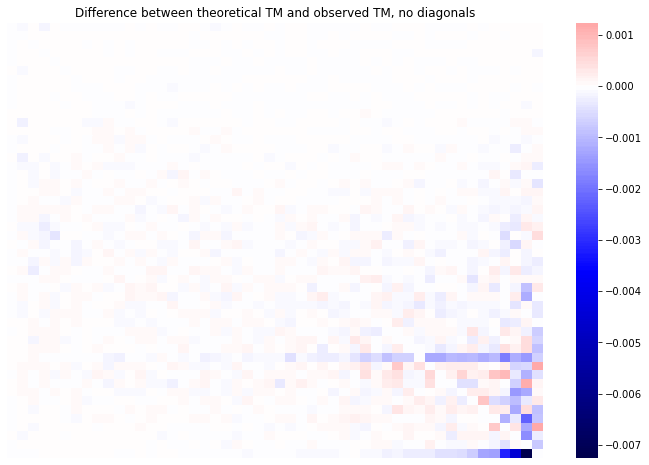

In [118]:
# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_2 = normalise(tm2,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm2 = q_Bc - tm_2
diff_q_Bc_tm_nd2 = np.copy(diff_q_Bc_tm2)
diff_q_Bc_tm_nd2 = remove_diagonals(diff_q_Bc_tm_nd2)

heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
heatmaps_seq(remove_diagonals(tm_2),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm2,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_Bc_tm_nd2,title="Difference between theoretical TM and observed TM, no diagonals")


Difference between uncorrected and corrected theoretical  TM

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


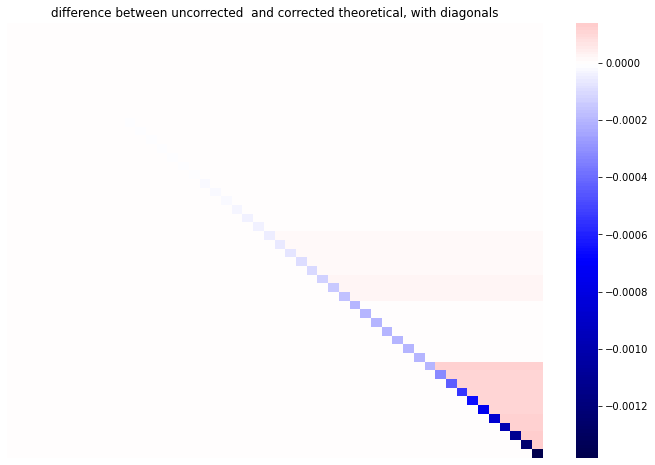

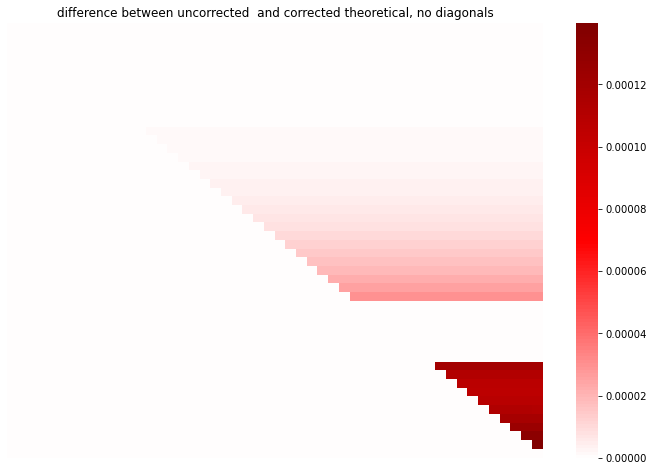

In [71]:

diff_q_B_q_Bc = q_B - q_Bc
diff_q_B_q_Bc_nd = np.copy(diff_q_B_q_Bc)
diff_q_B_q_Bc_nd = remove_diagonals(diff_q_B_q_Bc_nd)

heatmaps_div(diff_q_B_q_Bc,title="difference between uncorrected  and corrected theoretical, with diagonals")

heatmaps_div(diff_q_B_q_Bc_nd,title="difference between uncorrected  and corrected theoretical, no diagonals")

How do two theoretical matrices vary for different histories? I look because I want to gauge variability in randomness and accuracy, as when comparing theory to data

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


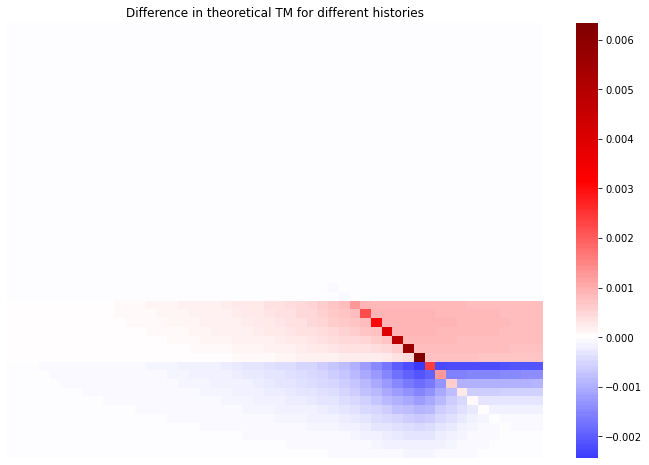

In [120]:
diff_qAc_qBc = q_Ac - q_Bc
heatmaps_div(diff_qAc_qBc,title="Difference in theoretical TM for different histories")

Ok cool, seems like a discernible difference

## Investigating the bad diagonals stuff

I think this is  because of the binning of the genome I do; i.e. I divide the genome into bins of 100bp (or something) and count the transitions between these parts. Therefore most adjacent bins have the same the tMRCA. 

The theory gives a probability of recombining or not ((1 -exp(-2rs)) or (exp(-2rs)) , but I am unsure how it measures not recombining in adjacent segments? Hmmm. Think it says "either there has been no recombination, or there has been a recombination but the tMRCA is the same".

First I try adjusting the bin size.

##### The defaultl bin size used in the above analysis was: 50, I will fiddle with this now and see how things differ

Now I will change that and see how results differ

In [84]:
args.bin_length = 50

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


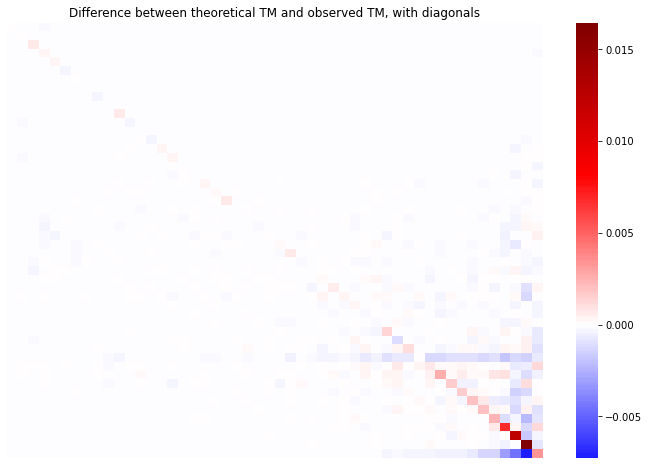

In [85]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [86]:
args.bin_length=20

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


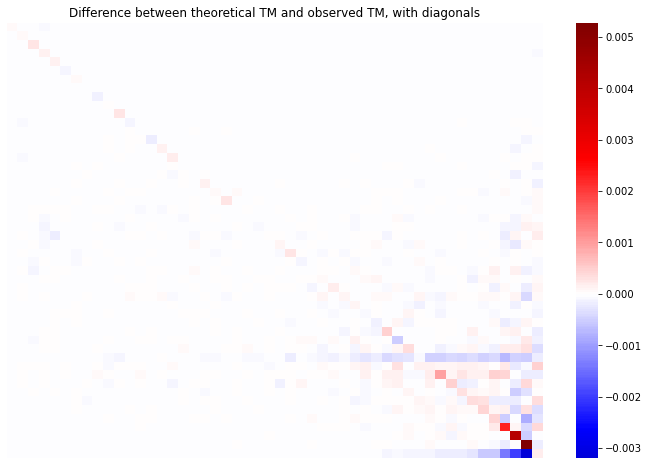

In [89]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [92]:
args.bin_length = 10

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


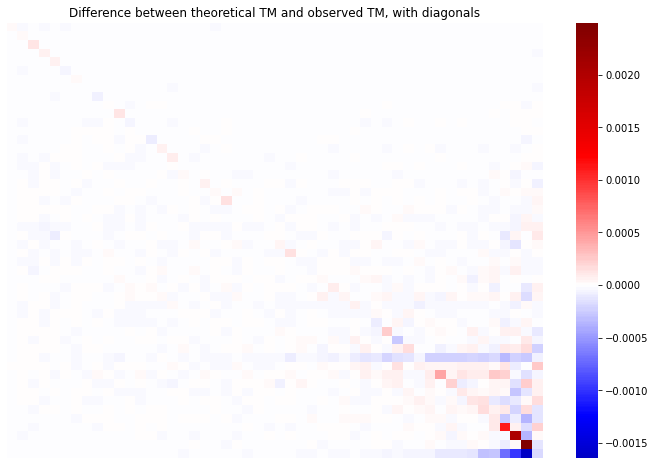

In [93]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


In [94]:
args.bin_length = 2

got coal data
pop_size is [10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.
 10000. 10000. 20000. 20000. 20000. 20000. 20000. 20000. 20000. 10000.
 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000. 10000.]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished
got the theoretical data
worked out difference


/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


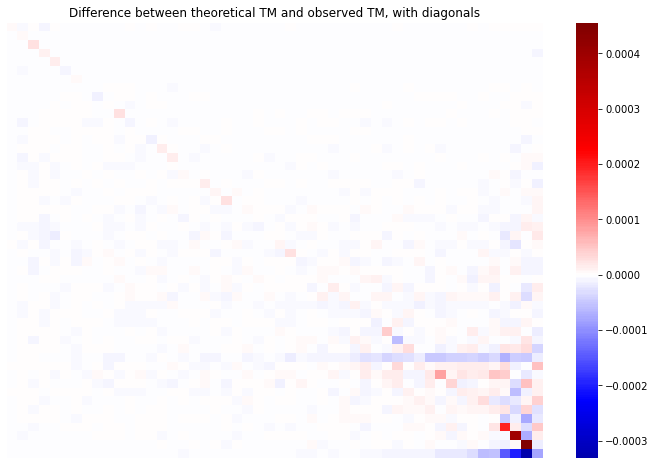

In [95]:
tmrca_data3 = get_coal_data(sim2, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim2.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3 #/(2e+04) # divide by 2N_0 to match theory
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np*2*N_0,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

print('got coal data')

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

# heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap

pop_size2 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
pop_size2 = np.array(pop_size2)
pop_size2[32:39] = 20000
# pop_size2[25:32] = 20000

N_0 = 1e+04
q_2Bc, q_2_upperBc, q_2_lowerBc, q_1Bc, q_Bc = corrected_abinitio(T_np,50,pop_size2,N_0,r=2e-08*args.bin_length)
# type(T_np)
# heatmaps_seq(normalise(q_2Bc,'colmax'),title='theoretical TM, constant pop size') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, upper') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax'),title='theoretical TM, constant pop size, lower ') # normalise this matrix and then plot heatmap
# heatmaps_seq(normalise(q_2_lowerBc,'colmax')+normalise(q_2_upperBc,'colmax'),title='theoretical TM, constant pop size, lower + upper ') # normalise this matrix and then plot heatmap
print('got the theoretical data')

# print('q_ is {}'.format(q_))
# print('tm is {}'.format(tm))
# [sum(q_[:,i]) for i in range(0,50)]
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_Bc_tm3 = q_Bc - tm_3
diff_q_Bc_tm_nd3 = np.copy(diff_q_Bc_tm3)
diff_q_Bc_tm_nd3 = remove_diagonals(diff_q_Bc_tm_nd3)

print('worked out difference')
# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_Bc_tm3,title="Difference between theoretical TM and observed TM, with diagonals")
# heatmaps_div(diff_q_Bc_tm_nd3,title="Difference between theoretical TM and observed TM, no diagonals")


## TODO

Make a more effecient algorithm for getting this observed coalescent data

## Try out G function, as written in Distribution of coalesent times -Copy_210116

I will copy paste from the above notebook. I copy as of 2021/01/29 (ymd) - I hope that i don't change things in one script and not the other! 

In [123]:
def G(t1,t2,gamma_array,lambda_array,T):
    """
    Assume t1 = ind1 =  0
    Then G(t) = no coalescing between 0 and t
    So if you want G between t1 and t2, you can do G = G(t2)/G(t1)
    For non 0 t1, can do 
    Takes as input t1 and t2 in scaled coalescent time
    t1, t2: can be boundaries or some number between a boundary
    Needs also gamma_array and lambda_array

    t1, t2: can be boundaries or some number between a boundary
    T: array of time intervals in coalescent time
    lambda_array: array of lambdas where lambda_i = N_0/pop_size_i
    gamma_array: array of population split fractions per time


    """
    
    def delta(i):
        delt = T[i+1] - T[i]
        return delt
    def lower_higher_intervals(t1,t2):
        # get the index of the next lower or equal time intervals for t1 and t2
        ind1 = np.argmin(abs(T - t1)) # ind1 is index of lower time interval for time1
        if T[ind1] > t1:
            ind1 = ind1 - 1
#         print('ind1 is {}; T[ind1] is {}; t1 is {}'.format(ind1,T[ind1],t1))
        ind2 = np.argmin(abs(T - t2)) # ind2 is index of lower time interval for time2
        if T[ind2] > t2:
            ind2 = ind2 - 1
        if ind2 == N_T:
            # if ind2 is the last time interval, remove 1 otherwise will crash
            ind2 = ind2-1
#         print('ind2 is {}; T[ind2] is {} and t2 is {}'.format(ind2,T[ind2],t2))
        return ind1, ind2


    def G_main(t2,ind1,ind2):
        # main part of G (the recursive part; the product); see my notepad page TODO
        recursion = 1
        i = ind1 # ind1 should be 0
        while i < ind2:
            sigma = ( (1-gamma_array[i])**2 + gamma_array[i]**2 )
            if (gamma_array[i] == gamma_array[i+1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                c = i # c for 'change', the point at which gamma changes
                G_set = np.array([])
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c]))
                G_set = np.append(G_set,G_temp)
                recursion = recursion*G_temp
                i += 1
                while gamma_array[i] == gamma_array[i+1] and i < ind2:
                    G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                    G_temp = G_temp/np.prod(G_set)
                    G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                    recursion = recursion*G_temp
                    i += 1
#                 recursion = recursion*np.prod(G_set)
            elif (gamma_array[i] != gamma_array[i+1]) and (gamma_array[i] == gamma_array[i-1]) and gamma_array[i] != 0 and gamma_array[i] != 1:
#                 pdb.set_trace()
                G_temp = 1 - sigma + sigma*np.exp(-lambda_array[i]*(T[i+1]-T[c])) # TODO this lambda needs to be summed
#                         print('G_temp is {}'.format(G_temp))
                G_temp = G_temp/np.prod(G_set)
                G_set = np.append(G_set,G_temp)
#                         print('G_set is {}'.format(G_set))
                recursion = recursion*G_temp
                i += 1
            elif (gamma_array[i] != gamma_array[i-1]) and (gamma_array[i] == 0 or gamma_array[i] == 1):
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            else: 
                G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(delta(i)))
                recursion = recursion*G
                i += 1
            
#         G_end
#         either t2 is in interval i with sigma_i == sigma_{i-1}
#         or t2 is in interval i where sigma_i != sigma_{i-1}
        if gamma_array[ind2] == gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: # if t2 is in an interval where there is the same gamma as the previous
            G_temp = 1 - sigma + sigma*np.exp(-lambda_array[ind2]*(t2-T[c])) # TODO this lambda needs to be summed
            G_temp = G_temp/np.prod(G_set) # don't bother adding this G_temp to G_set
            recursion = recursion*G_temp
        elif gamma_array[ind2] != gamma_array[ind2-1] and gamma_array[ind2] != 1 and gamma_array[ind2] != 0: 
#             pdb.set_trace()
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] != gamma_array[ind2-1] and (gamma_array[ind2] == 1 or gamma_array[ind2] == 0):
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        elif gamma_array[ind2] == 1 or gamma_array[ind2] == 0:
            sigma = ( (1-gamma_array[ind2])**2 + gamma_array[ind2]**2 )
            G = 1 - sigma + sigma*np.exp(-lambda_array[i]*(t2-T[ind2]))
            recursion = recursion*G
        else: 
            print('there has been an error!')
        return recursion
    
    def G_same(t1,t2,ind1):
        # if t1 and t2 are within the same interval
        G = 1 - ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) ) + ( (1-gamma_array[ind1])**2 + (gamma_array[ind1]**2) )*np.exp(-(lambda_array[ind1]*(t2-t1) ))
        return G

    ind1, ind2 = lower_higher_intervals(t1,t2) # get the intervals in which t1 and t2 are situated
    if ind1 == ind2: # if they are in the same interval
        G = G_same(t1,t2,ind1) 
    #elif ind1 == (ind2-1): # if they are one interval apart
    #    G = G_start(t1,ind1)*G_end(t2,ind2)
    else: # otherwise; there is some distance between them
        if t1 != 0:
            G = G_main(t2,0,ind2) / G_main(t1,0,ind1)
        elif t1 == 0:
            G = G_main(t2,ind1,ind2)
    #         G_end_ = G_end(t2,ind2)
            #*G_end_
    #         print('G_start_ is {}\nG_main_ is {}\nG_end_ is {}'.format(G_start_,G_main_,G_end_))
    return G
    # TODO try this on my distribution till coalesence thingtime  
  

I now need to rewrite my transition matrix theory with this function instead of L. In my notepad, page 15-17, I write what I expect the theoretical probabilities to be. They are cumbersome so I introduced new functions called H instead. I will also write that in the above block of code. 

Note that my G function is calibrated to run from t1=0 to t2 - i.e. it should be given G(0,t2)<br>.
Therefore, if you want a non t1!=0 start, you should do G(t1,t2)/G(0,t1) 

In [196]:
def structuredsplit_abinitio(T,N_T,lambda_array,gamma_array,mu=2e-08,r=2e-08):
    
    def L(time1,time2):
        """
        L is the probability of not coalescing between time1 and time2)
        time is in coalescent units
        There are 4 possibilities:
        time1 and time2 continuous
        time1 continuous time2 discrete
        time2 continuous time1 discrete
        time1 and time2 discrete"""
        ind1 = np.argmin(abs(T - time1)) #ind1 is index of lower time interval for time1
        if T[ind1] <= time1:
            low_T1 = T[ind1]
            high_T1 = T[ind1+1]
        elif T[ind1] > time1:
            low_T1 = T[ind1-1]
            high_T1 = T[ind1]
            ind1 = ind1 - 1
        else:
            print('Problem: T[ind1] is {} and time1 is {}'.format(ind1,time1))
        ind2 = np.argmin(abs(T - time2))
        if T[ind2] <= time2:
            low_T2 = T[ind2]
            high_T2 = T[ind2+1]
        elif T[ind2] > time2:
            low_T2 = T[ind2-1]
            high_T2 = T[ind2]
            ind2 = ind2 - 1
        # sum
        if low_T1 == low_T2:
            L = math.exp(-(time2 - time1)*lambda_(ind1))
        else:
            sum = 0
            for i in range(ind1+1,ind2):
                sum = sum + lambda_(i)*delta(i)
            L = math.exp(-(high_T1 - time1)*lambda_(ind1) - sum - (time2 - low_T2)*lambda_(ind2))
        return L

    
    def lambda_(int):
            lambd = lambda_array[int]
            return lambd
    
    def sigma(int):
        sig = (1-gamma_array[int])**2 + gamma_array[int]**2
        return sig
    
    def H_intervals(ind1): # for iterating through the intervals
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = T[ind1+1] - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/gamma)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H

    def H_edge(ind1,t): # for the edge case where the upper boundary is t2, not an interval
        if t < T[ind1]:
            print('There has been an error! T[ind] is bigger than t2, whereas t2 should be bigger than T[ind]')
        sigma = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma = gamma_array[ind1]
        lambda_ = lambda_array[ind1]
        delta = t - T[ind1]
        H = ((1-sigma)**2)*(delta) + 2*(1-sigma)*((sigma)/gamma)*(1-np.exp(-lambda_*delta)) + ((sigma**2)/(2*lambda_)) * (1-np.exp(-2*lambda_*delta))
        return H

    def H_antidash(ind1): # let this be the integral of H, i.e. the antiderivate, i.e. the anti' of H - poor naming i know
        sig = ( (1-gamma_array[ind1])**2 + gamma_array[ind1]**2 )
        gamma_ = gamma_array[ind1]
        lambd = lambda_array[ind1]
        delt = T[ind1+1] - T[ind1]
        if sig==1:
            H = (1/(2*lambd))*(delt - (1/(2*lambd))*(1-np.exp(-2*delt*lambd)))
        else: 
            delt = T[ind1+1] - T[ind1]
            H = ((1-sig)**2)*( (T[ind1+1]**2 - T[ind1]**2)/2 + T[ind1]*delt) + 2*(1-sig)*(sig/lambd)*(
                delt + (1/lambd)*(np.exp(-lambd*delt) - 1)
            ) + (((sig)**2)/(2*lambd))*(
            delt + (1/(2*lambd))*(np.exp(-2*lambd*delt) -1))
        return H
    
    def delta(int):
        delt = T[int+1] - T[int]
        return delt
    
    def delta_(int):
        delt = T[int+1] - T[int]
        return delt

    
    def expected_time(int):
        sum = 0
        for i in range(0, int): # want  range from 0 to beta-1, which is completed by range(0,beta) in python
            sum = sum + lambda_(i) * delta(i)
        numerator =  math.exp(-sum)* (
            (T[int]*lambda_(int) + 1) -  math.exp(-delta(int)*lambda_(int))*(T[int+1]*lambda_(int) + 1)
        )
        denominator = L(0,T[int]) * (1-math.exp(-delta(int)*lambda_(int))) * lambda_(int)

        expec_time = numerator / denominator
        return expec_time

    
    def expected_time_check(expected_times,T):
        good = None
        if len(expected_times) != (len(T)-1):
            print('Error!\nexpected_time and T do not conform in length.\nLength of T is {} and length of expected_times is {} Aborting.'.format(len(T),len(expected_times)))
            sys.exit()
        for i in range(0,len(expected_times)):
            if not expected_times[i] > T[i] and expected_times[i] < T[i+1]:
                print('Error!\nexpected_time is not behaving as expected. For int {}, expected_times is {} but intervals are {} and {}'.format(i,expected_times[i],T[i],T[i+1]))
                print('Continuing...')
                good = False
            else:
               good = True
        if good:
            print('expected_times conforms with T.')
        return None
    
    # function to write upper triangular of q_2, eq 26. Give as input an N_T x N_T matrix

    
    def upper_diag_sum(alpha):
        sum_q = 0
        for j in range(0,alpha-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = G(T[j+1],T[alpha],gamma_array,lambda_array,T_np)**2 * H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
        
    def upper_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(alpha+1,N_T):
#                 if alpha ==1:
#                     pdb.set_trace()
                q_2[alpha,beta] = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha) * (
                    upper_diag_sum(alpha)*H_intervals(alpha) + H_antidash(alpha)               
                )
                pre = (1 - np.exp(-2 * rho * expected_time(beta))) * (1 / expected_time(beta)) * lambda_(alpha) * sigma(alpha)
                A = upper_diag_sum(alpha)*H_intervals(alpha)
                B = H_antidash(alpha)
                print('\n\nUpper_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nand B = {}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    def lower_diag_sum(beta):
        sum_q = 0
        for j in range(0,beta-1+1): # sum in eq 26 is to (alpha - 1), but add to range one so python includes the (alpha -1) term
            iteration = G(T[j+1],expected_time(beta),gamma_array,lambda_array,T_np)**2 * H_intervals(j) 
            sum_q = sum_q + iteration
        return sum_q
    
    def lower_diag(q_2):
#         pdb.set_trace()
        for alpha in range(0,N_T):
            for beta in range(0,alpha):

                # the integral of G over T[alpha] and T[alpha+1], see my notepad page 19
                G_integral_alpha = (1-sigma(alpha))*delta(alpha) + (sigma(alpha)/lambda_(alpha))*(1-np.exp(-delta(alpha)*lambda_(alpha)))
                
                
                q_2[alpha,beta] = G(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta))*(
                        lower_diag_sum(beta) + H_edge(beta,expected_time(beta))
                    ))

                pre = G(expected_time(beta),T[alpha],gamma_array,lambda_array,T_np)*G_integral_alpha*(1 - np.exp(-2 * rho * expected_time(beta)))*(
                    lambda_(alpha)*sigma(alpha)*(1/expected_time(beta)))
                A = lower_diag_sum(beta) 
                B = H_edge(beta,expected_time(beta))
                print('\n\nLower_diag:\nFor alpha  {} and beta {} we have q_2[alpha,beta] = {}\nwith pre = {}\nA = {}\nB={}'.format(alpha,beta,q_2[alpha,beta],pre,A,B))
        return q_2
    
    # flagstr
    
    rho = 2 * N_0 * r # is rho population or per gen per bp?
    expected_times = [expected_time(i) for i in range(0,len(T)-1)]
    expected_time_check(expected_times,T)
    
    q_2 = np.zeros(shape=(N_T,N_T))
    q_2_upper = np.zeros(shape=(N_T,N_T))
    q_2_lower = np.zeros(shape=(N_T,N_T))
    q_2_upper = upper_diag(q_2_upper)
    q_2_lower = lower_diag(q_2_lower)
    q_2 = q_2_upper + q_2_lower
    

    # initialise q_1
    # old q_1 = [1 - sum(q_2[i,0:N_T]) for i in range(0,N_T)]
    q_1 = [1 - sum(q_2[:,i]) for i in range(0,N_T)]

    # eq 30, combine q_1 and q_2
    q_ = np.copy(q_2)
    for i in range(0,q_.shape[0]):
        q_[i,i] = q_1[i]

    print('Finished')
    """
    q_2 is full N_T x N_T matrix with empty diagonals
    q_2_upper is the upper triangular of q
    q_2 is the lower triangular of q
    q_1 is 1 x N_T array of diagonals 
    q_ is full N_T x N_T matrix
    """
    
    return q_2, q_2_upper, q_2_lower, q_1, q_
    
    

In [125]:
# scaled_time_intervals 

mu = 2e-08
alpha = 0.1
N_0 = 10000 # TODO, use sim
Tmax = 20
N_T = 50
T = [0]
for i in range(0,N_T): # TODO: should T have upper interval
        T.append( alpha*math.exp( (i/N_T)*math.log(1 + Tmax/alpha) - 1))
T_np = np.array(T) # convert to numpy
# scale these to generations with *2*N_0, as per Schiffels' instruction
T_scaled_np = T_np * 2 * N_0

# print(f'T_np is {T_np}\n\n')
# print(f'T_scaled_np is {T_scaled_np}')

In [126]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

# gamma_array[20:35] = 0.3

In [ ]:
q_2 = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)

In [133]:
# should be 
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)

pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.
Finished


In [ ]:
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)
# type(T_np)

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


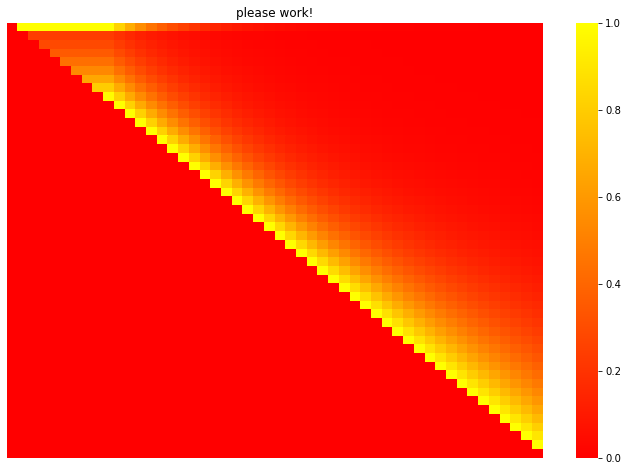

In [134]:
heatmaps_seq(normalise(q_2,'colmax'),title="please work!")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


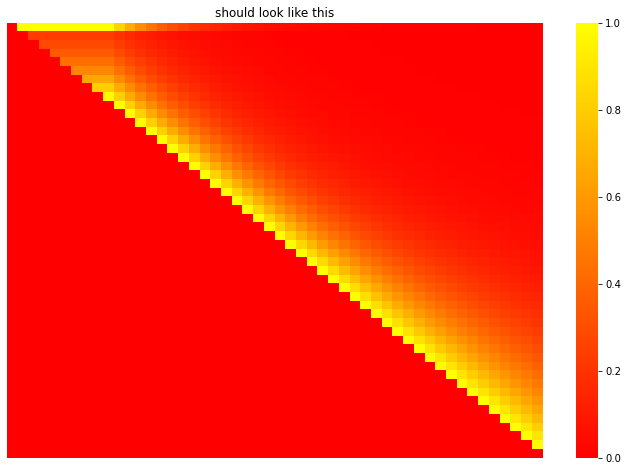

In [135]:
heatmaps_seq(normalise(q_2_upperAc,'colmax'),title="should look like this")

Doesn't look too bad! 

In [136]:
checking_qs = q_2 - q_2_upperAc

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


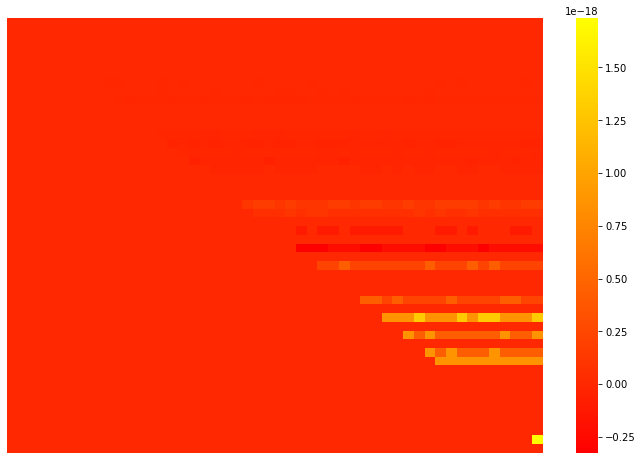

In [137]:
heatmaps_seq(checking_qs)

Very small differences in TM. Not sure if that is ok?

In [138]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[20:35] = 0.3
print(gamma_array)
q_2gamma = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 0.3 1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
expected_times conforms with T.


For alpha  0 and beta 1 we have q_2[alpha,beta] = 2.639475074593914e-05
with pre = 0.03996894030295883
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 2 we have q_2[alpha,beta] = 2.6392457045993246e-05
with pre = 0.03996546700794299
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 3 we have q_2[alpha,beta] = 2.6389907025621133e-05
with pre = 0.039961605573030974
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 4 we have q_2[alpha,beta] = 2.6387072082607332e-05
with pre = 0.039957312686571406
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 5 we have q_2[alpha,beta] = 2.6383920432893147e-05
with pre = 0.03995254021872374
A = 0.0
and B = 0.000660381549920281


For alpha  0 and beta 6 we have q_2[alpha,beta] 



For alpha  6 and beta 25 we have q_2[alpha,beta] = 1.7135245248913152e-05
with pre = 0.03960653276697166
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 26 we have q_2[alpha,beta] = 1.7116346486137657e-05
with pre = 0.03956285002673365
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 27 we have q_2[alpha,beta] = 1.7095368013107718e-05
with pre = 0.03951436022881179
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 28 we have q_2[alpha,beta] = 1.7072085295613717e-05
with pre = 0.03946054438317113
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 29 we have q_2[alpha,beta] = 1.704625057405587e-05
with pre = 0.0394008298164379
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  6 and beta 30 we have q_2[alpha,beta] = 1.701759070112067e-05
with pre = 0.03933458517388881
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


For alpha  



For alpha  9 and beta 29 we have q_2[alpha,beta] = 3.144435039396153e-05
with pre = 0.0394008298164379
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 30 we have q_2[alpha,beta] = 3.139148298579423e-05
with pre = 0.03933458517388881
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 31 we have q_2[alpha,beta] = 3.13328492192663e-05
with pre = 0.039261115090152975
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 32 we have q_2[alpha,beta] = 3.126783855721375e-05
with pre = 0.03917965454160628
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 33 we have q_2[alpha,beta] = 3.119578012945301e-05
with pre = 0.03908936290531965
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 34 we have q_2[alpha,beta] = 3.1115937789225956e-05
with pre = 0.03898931776461811
A = 0.00075211710745602
and B = 4.59460435094719e-05


For alpha  9 and beta 35 we have q_2[alpha,b



For alpha  11 and beta 34 we have q_2[alpha,beta] = 4.6583545469967925e-05
with pre = 0.03898931776461811
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 35 we have q_2[alpha,beta] = 4.6451153118421235e-05
with pre = 0.03887850852045298
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 36 we have q_2[alpha,beta] = 4.6304579497472174e-05
with pre = 0.03875582989164878
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 37 we have q_2[alpha,beta] = 4.614238315421767e-05
with pre = 0.03862007541646643
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 38 we have q_2[alpha,beta] = 4.5962994162026185e-05
with pre = 0.03846993110371682
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 and beta 39 we have q_2[alpha,beta] = 4.576470694231777e-05
with pre = 0.03830396942476179
A = 0.0011246561233348989
and B = 7.012101411584676e-05


For alpha  11 an



For alpha  13 and beta 20 we have q_2[alpha,beta] = 7.079983166913175e-05
with pre = 0.039767807392311026
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 21 we have q_2[alpha,beta] = 7.075378973015462e-05
with pre = 0.03974194593306677
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 22 we have q_2[alpha,beta] = 7.070264611912298e-05
with pre = 0.039713218897635974
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 23 we have q_2[alpha,beta] = 7.064584177203958e-05
with pre = 0.03968131226338838
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 24 we have q_2[alpha,beta] = 7.058275782619043e-05
with pre = 0.039645878419141405
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  13 and beta 25 we have q_2[alpha,beta] = 7.051270957024688e-05
with pre = 0.03960653276697166
A = 0.0016733523932083853
and B = 0.00010697788677634101


For alpha  



For alpha  15 and beta 37 we have q_2[alpha,beta] = 0.00010187293511827307
with pre = 0.03862007541646643
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 38 we have q_2[alpha,beta] = 0.00010147688095042966
with pre = 0.03846993110371682
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 39 we have q_2[alpha,beta] = 0.00010103910336532694
with pre = 0.03830396942476179
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 40 we have q_2[alpha,beta] = 0.00010055552299412643
with pre = 0.03812064388904414
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 41 we have q_2[alpha,beta] = 0.00010002173469695842
with pre = 0.03791828450606256
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 and beta 42 we have q_2[alpha,beta] = 9.943299891383777e-05
with pre = 0.03769509450649993
A = 0.002474687420767174
and B = 0.00016313588795784095


For alpha  15 a



For alpha  18 and beta 19 we have q_2[alpha,beta] = 0.00018680303062122854
with pre = 0.03979108682642769
A = 0.004387709609877114
and B = 0.0003068852232843977


For alpha  18 and beta 20 we have q_2[alpha,beta] = 0.00018669374311010552
with pre = 0.039767807392311026
A = 0.004387709609877114
and B = 0.0003068852232843977


For alpha  18 and beta 21 we have q_2[alpha,beta] = 0.00018657233403715943
with pre = 0.03974194593306677
A = 0.004387709609877114
and B = 0.0003068852232843977


For alpha  18 and beta 22 we have q_2[alpha,beta] = 0.00018643747224505395
with pre = 0.039713218897635974
A = 0.004387709609877114
and B = 0.0003068852232843977


For alpha  18 and beta 23 we have q_2[alpha,beta] = 0.0001862876835247716
with pre = 0.03968131226338838
A = 0.004387709609877114
and B = 0.0003068852232843977


For alpha  18 and beta 24 we have q_2[alpha,beta] = 0.00018612133598265072
with pre = 0.039645878419141405
A = 0.004387709609877114
and B = 0.0003068852232843977


For alpha  18 and 



For alpha  20 and beta 21 we have q_2[alpha,beta] = 0.000397543273858524
with pre = 0.023050328641178727
A = 0.013768142052884512
and B = 0.003478608743905638


For alpha  20 and beta 22 we have q_2[alpha,beta] = 0.00039725591400622477
with pre = 0.023033666960628862
A = 0.013768142052884512
and B = 0.003478608743905638


For alpha  20 and beta 23 we have q_2[alpha,beta] = 0.0003969367482598379
with pre = 0.023015161112765258
A = 0.013768142052884512
and B = 0.003478608743905638


For alpha  20 and beta 24 we have q_2[alpha,beta] = 0.00039658229942456796
with pre = 0.022994609483102012
A = 0.013768142052884512
and B = 0.003478608743905638


For alpha  20 and beta 25 we have q_2[alpha,beta] = 0.0003961887203229809
with pre = 0.022971789004843562
A = 0.013768142052884512
and B = 0.003478608743905638


For alpha  20 and beta 26 we have q_2[alpha,beta] = 0.00039575175682867743
with pre = 0.022946453015505512
A = 0.013768142052884512
and B = 0.003478608743905638


For alpha  20 and beta 2



For alpha  21 and beta 45 we have q_2[alpha,beta] = 0.0005074449352263609
with pre = 0.02139077985166709
A = 0.019422725545457865
and B = 0.004299875441752671


For alpha  21 and beta 46 we have q_2[alpha,beta] = 0.0005029454488454865
with pre = 0.021201108981120462
A = 0.019422725545457865
and B = 0.004299875441752671


For alpha  21 and beta 47 we have q_2[alpha,beta] = 0.0004980101001627406
with pre = 0.02099306481743847
A = 0.019422725545457865
and B = 0.004299875441752671


For alpha  21 and beta 48 we have q_2[alpha,beta] = 0.0004926046688317563
with pre = 0.02076520483977841
A = 0.019422725545457865
and B = 0.004299875441752671


For alpha  21 and beta 49 we have q_2[alpha,beta] = 0.00048669404507154044
with pre = 0.02051604903416492
A = 0.019422725545457865
and B = 0.004299875441752671


For alpha  22 and beta 23 we have q_2[alpha,beta] = 0.0007319085897932638
with pre = 0.023015161112765258
A = 0.026486217883674924
and B = 0.00531493207166099


For alpha  22 and beta 24 we h



For alpha  24 and beta 25 we have q_2[alpha,beta] = 0.0012439368993692357
with pre = 0.022971789004843562
A = 0.04603070003226579
and B = 0.008119932254447003


For alpha  24 and beta 26 we have q_2[alpha,beta] = 0.0012425649395269708
with pre = 0.022946453015505512
A = 0.04603070003226579
and B = 0.008119932254447003


For alpha  24 and beta 27 we have q_2[alpha,beta] = 0.001241042002661155
with pre = 0.022918328932710834
A = 0.04603070003226579
and B = 0.008119932254447003


For alpha  24 and beta 28 we have q_2[alpha,beta] = 0.0012393517886614333
with pre = 0.022887115742239252
A = 0.04603070003226579
and B = 0.008119932254447003


For alpha  24 and beta 29 we have q_2[alpha,beta] = 0.0012374763113651413
with pre = 0.022852481293533983
A = 0.04603070003226579
and B = 0.008119932254447003


For alpha  24 and beta 30 we have q_2[alpha,beta] = 0.0012353957415829498
with pre = 0.02281405940085551
A = 0.04603070003226579
and B = 0.008119932254447003


For alpha  24 and beta 31 we have 



For alpha  26 and beta 31 we have q_2[alpha,beta] = 0.0019975875891341957
with pre = 0.022771446752288725
A = 0.07531935952368214
and B = 0.012403990286466432


For alpha  26 and beta 32 we have q_2[alpha,beta] = 0.0019934429136605806
with pre = 0.022724199634131644
A = 0.07531935952368214
and B = 0.012403990286466432


For alpha  26 and beta 33 we have q_2[alpha,beta] = 0.001988848916479537
with pre = 0.022671830485085396
A = 0.07531935952368214
and B = 0.012403990286466432


For alpha  26 and beta 34 we have q_2[alpha,beta] = 0.001983758665452288
with pre = 0.0226138043034785
A = 0.07531935952368214
and B = 0.012403990286466432


For alpha  26 and beta 35 we have q_2[alpha,beta] = 0.0019781207417611923
with pre = 0.022549534941862726
A = 0.07531935952368214
and B = 0.012403990286466432


For alpha  26 and beta 36 we have q_2[alpha,beta] = 0.001971878909205277
with pre = 0.02247838133715629
A = 0.07531935952368214
and B = 0.012403990286466432


For alpha  26 and beta 37 we have q_2[



For alpha  28 and beta 45 we have q_2[alpha,beta] = 0.0029366424972434783
with pre = 0.02139077985166709
A = 0.11833954926976296
and B = 0.01894588481012688


For alpha  28 and beta 46 we have q_2[alpha,beta] = 0.002910603449448174
with pre = 0.021201108981120462
A = 0.11833954926976296
and B = 0.01894588481012688


For alpha  28 and beta 47 we have q_2[alpha,beta] = 0.002882042016129304
with pre = 0.02099306481743847
A = 0.11833954926976296
and B = 0.01894588481012688


For alpha  28 and beta 48 we have q_2[alpha,beta] = 0.0028507601601868086
with pre = 0.02076520483977841
A = 0.11833954926976296
and B = 0.01894588481012688


For alpha  28 and beta 49 we have q_2[alpha,beta] = 0.002816554697259636
with pre = 0.02051604903416492
A = 0.11833954926976296
and B = 0.01894588481012688


For alpha  29 and beta 30 we have q_2[alpha,beta] = 0.003879642826578152
with pre = 0.02281405940085551
A = 0.1466413629547678
and B = 0.02341354741478567


For alpha  29 and beta 31 we have q_2[alpha,beta



For alpha  31 and beta 42 we have q_2[alpha,beta] = 0.005619037175850362
with pre = 0.021863154813769957
A = 0.22125625252829542
and B = 0.03575318749594816


For alpha  31 and beta 43 we have q_2[alpha,beta] = 0.005582375158459021
with pre = 0.021720506289311544
A = 0.22125625252829542
and B = 0.03575318749594816


For alpha  31 and beta 44 we have q_2[alpha,beta] = 0.0055420150487783
with pre = 0.02156346882922092
A = 0.22125625252829542
and B = 0.03575318749594816


For alpha  31 and beta 45 we have q_2[alpha,beta] = 0.005497632351358831
with pre = 0.02139077985166709
A = 0.22125625252829542
and B = 0.03575318749594816


For alpha  31 and beta 46 we have q_2[alpha,beta] = 0.005448885147130732
with pre = 0.021201108981120462
A = 0.22125625252829542
and B = 0.03575318749594816


For alpha  31 and beta 47 we have q_2[alpha,beta] = 0.005395415833122511
with pre = 0.02099306481743847
A = 0.22125625252829542
and B = 0.03575318749594816


For alpha  31 and beta 48 we have q_2[alpha,beta]



For alpha  35 and beta 37 we have q_2[alpha,beta] = 0.008537189272783434
with pre = 0.03862007541646643
A = 0.21064326695425495
and B = 0.010412471045247645


For alpha  35 and beta 38 we have q_2[alpha,beta] = 0.008503999010922142
with pre = 0.03846993110371682
A = 0.21064326695425495
and B = 0.010412471045247645


For alpha  35 and beta 39 we have q_2[alpha,beta] = 0.0084673122295011
with pre = 0.03830396942476179
A = 0.21064326695425495
and B = 0.010412471045247645


For alpha  35 and beta 40 we have q_2[alpha,beta] = 0.008426787067908881
with pre = 0.03812064388904414
A = 0.21064326695425495
and B = 0.010412471045247645


For alpha  35 and beta 41 we have q_2[alpha,beta] = 0.008382054365162765
with pre = 0.03791828450606256
A = 0.21064326695425495
and B = 0.010412471045247645


For alpha  35 and beta 42 we have q_2[alpha,beta] = 0.008332716935095338
with pre = 0.03769509450649993
A = 0.21064326695425495
and B = 0.010412471045247645


For alpha  35 and beta 43 we have q_2[alpha,be



For alpha  39 and beta 48 we have q_2[alpha,beta] = 0.00590919776576747
with pre = 0.03580207730996278
A = 0.14191454363282122
and B = 0.023137269271987393


For alpha  39 and beta 49 we have q_2[alpha,beta] = 0.005838294977125635
with pre = 0.035372498334767105
A = 0.14191454363282122
and B = 0.023137269271987393


For alpha  40 and beta 41 we have q_2[alpha,beta] = 0.006158804306363183
with pre = 0.03791828450606256
A = 0.13427007085582257
and B = 0.028153002513398084


For alpha  40 and beta 42 we have q_2[alpha,beta] = 0.006122553100688944
with pre = 0.03769509450649993
A = 0.13427007085582257
and B = 0.028153002513398084


For alpha  40 and beta 43 we have q_2[alpha,beta] = 0.0060826058390439095
with pre = 0.037449148774675076
A = 0.13427007085582257
and B = 0.028153002513398084


For alpha  40 and beta 44 we have q_2[alpha,beta] = 0.006038629103005953
with pre = 0.03717839453313952
A = 0.13427007085582257
and B = 0.028153002513398084


For alpha  40 and beta 45 we have q_2[alph

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


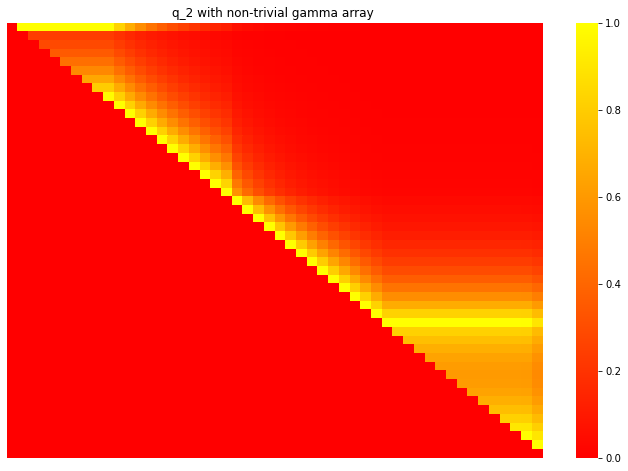

In [140]:
heatmaps_seq(normalise(q_2gamma,'colmax'),title="q_2 with non-trivial gamma array ")

Not sure if that looks good or not. Time to investigate more.

### Lower diag

Have implemented the lower diagonal in my structured_split function. Let's see how it does.


In [197]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

# gamma_array[20:35] = 0.3
print(gamma_array)
q_2C, q_2_upperC, q_2_lowerC, q_1C, q_C = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
expected_times conforms with T.


Upper_diag:
For alpha  0 and beta 1 we have q_2[alpha,beta] = 2.639475074593914e-05
with pre = 0.03996894030295883
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 2 we have q_2[alpha,beta] = 2.6392457045993246e-05
with pre = 0.03996546700794299
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 3 we have q_2[alpha,beta] = 2.6389907025621133e-05
with pre = 0.039961605573030974
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 4 we have q_2[alpha,beta] = 2.6387072082607332e-05
with pre = 0.039957312686571406
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 5 we have q_2[alpha,beta] = 2.6383920432893147e-05
with pre = 0.03995254021872374
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 6 



Upper_diag:
For alpha  2 and beta 14 we have q_2[alpha,beta] = 7.552216236336431e-06
with pre = 0.039876884230771
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 15 we have q_2[alpha,beta] = 7.549613582173038e-06
with pre = 0.03986314180927266
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 16 we have q_2[alpha,beta] = 7.546721206445696e-06
with pre = 0.039847869612552954
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 17 we have q_2[alpha,beta] = 7.543507044728447e-06
with pre = 0.03983089833542227
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 18 we have q_2[alpha,beta] = 7.539935527961073e-06
with pre = 0.03981204016767336
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 19 we have q_2[alpha,beta] = 7.535967209798468e-06
with pre = 0.03979108682642769
A =



Upper_diag:
For alpha  3 and beta 45 we have q_2[alpha,beta] = 8.594305814572306e-06
with pre = 0.0368806549166674
A = 0.0002201242713338125
and B = 1.2905913026831778e-05


Upper_diag:
For alpha  3 and beta 46 we have q_2[alpha,beta] = 8.518100576759678e-06
with pre = 0.03655363617434563
A = 0.0002201242713338125
and B = 1.2905913026831778e-05


Upper_diag:
For alpha  3 and beta 47 we have q_2[alpha,beta] = 8.43451338741835e-06
with pre = 0.03619493934041116
A = 0.0002201242713338125
and B = 1.2905913026831778e-05


Upper_diag:
For alpha  3 and beta 48 we have q_2[alpha,beta] = 8.342964676034665e-06
with pre = 0.03580207730996278
A = 0.0002201242713338125
and B = 1.2905913026831778e-05


Upper_diag:
For alpha  3 and beta 49 we have q_2[alpha,beta] = 8.242859808247361e-06
with pre = 0.035372498334767105
A = 0.0002201242713338125
and B = 1.2905913026831778e-05


Upper_diag:
For alpha  4 and beta 5 we have q_2[alpha,beta] = 1.1449540287879149e-05
with pre = 0.03995254021872374
A = 0.00



Upper_diag:
For alpha  5 and beta 16 we have q_2[alpha,beta] = 1.4035510455463804e-05
with pre = 0.039847869612552954
A = 0.00033251690796017464
and B = 1.9710465596636806e-05


Upper_diag:
For alpha  5 and beta 17 we have q_2[alpha,beta] = 1.4029532707094159e-05
with pre = 0.03983089833542227
A = 0.00033251690796017464
and B = 1.9710465596636806e-05


Upper_diag:
For alpha  5 and beta 18 we have q_2[alpha,beta] = 1.4022890344197867e-05
with pre = 0.03981204016767336
A = 0.00033251690796017464
and B = 1.9710465596636806e-05


Upper_diag:
For alpha  5 and beta 19 we have q_2[alpha,beta] = 1.4015510003843667e-05
with pre = 0.03979108682642769
A = 0.00033251690796017464
and B = 1.9710465596636806e-05


Upper_diag:
For alpha  5 and beta 20 we have q_2[alpha,beta] = 1.4007310349906864e-05
with pre = 0.039767807392311026
A = 0.00033251690796017464
and B = 1.9710465596636806e-05


Upper_diag:
For alpha  5 and beta 21 we have q_2[alpha,beta] = 1.3998201236040913e-05
with pre = 0.039741945933



Upper_diag:
For alpha  6 and beta 22 we have q_2[alpha,beta] = 1.7181401599542135e-05
with pre = 0.039713218897635974
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 23 we have q_2[alpha,beta] = 1.716759761407043e-05
with pre = 0.03968131226338838
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 24 we have q_2[alpha,beta] = 1.715226762760441e-05
with pre = 0.039645878419141405
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 25 we have q_2[alpha,beta] = 1.7135245248913152e-05
with pre = 0.03960653276697166
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 26 we have q_2[alpha,beta] = 1.7116346486137657e-05
with pre = 0.03956285002673365
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 27 we have q_2[alpha,beta] = 1.7095368013107718e-05
with pre = 0.03951436022881



Upper_diag:
For alpha  8 and beta 12 we have q_2[alpha,beta] = 2.5986151032846303e-05
with pre = 0.03990037500117154
A = 0.000614088133381309
and B = 3.71877263589393e-05


Upper_diag:
For alpha  8 and beta 13 we have q_2[alpha,beta] = 2.5978905239314668e-05
with pre = 0.03988924946439128
A = 0.000614088133381309
and B = 3.71877263589393e-05


Upper_diag:
For alpha  8 and beta 14 we have q_2[alpha,beta] = 2.597085206115773e-05
with pre = 0.039876884230771
A = 0.000614088133381309
and B = 3.71877263589393e-05


Upper_diag:
For alpha  8 and beta 15 we have q_2[alpha,beta] = 2.596190195378149e-05
with pre = 0.03986314180927266
A = 0.000614088133381309
and B = 3.71877263589393e-05


Upper_diag:
For alpha  8 and beta 16 we have q_2[alpha,beta] = 2.595195554073274e-05
with pre = 0.039847869612552954
A = 0.000614088133381309
and B = 3.71877263589393e-05


Upper_diag:
For alpha  8 and beta 17 we have q_2[alpha,beta] = 2.5940902557628562e-05
with pre = 0.03983089833542227
A = 0.00061408813338



Upper_diag:
For alpha  9 and beta 32 we have q_2[alpha,beta] = 3.126783855721375e-05
with pre = 0.03917965454160628
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 33 we have q_2[alpha,beta] = 3.119578012945301e-05
with pre = 0.03908936290531965
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 34 we have q_2[alpha,beta] = 3.1115937789225956e-05
with pre = 0.03898931776461811
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 35 we have q_2[alpha,beta] = 3.1027505014671425e-05
with pre = 0.03887850852045298
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 36 we have q_2[alpha,beta] = 3.092959972161182e-05
with pre = 0.03875582989164878
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 37 we have q_2[alpha,beta] = 3.0821259077390124e-05
with pre = 0.03862007541646643
A = 0.00075211710745602




Upper_diag:
For alpha  10 and beta 47 we have q_2[alpha,beta] = 3.53622748498388e-05
with pre = 0.03619493934041116
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  10 and beta 48 we have q_2[alpha,beta] = 3.4978450609435375e-05
with pre = 0.03580207730996278
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  10 and beta 49 we have q_2[alpha,beta] = 3.455875409750833e-05
with pre = 0.035372498334767105
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  11 and beta 12 we have q_2[alpha,beta] = 4.767205582711102e-05
with pre = 0.03990037500117154
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 13 we have q_2[alpha,beta] = 4.7658763290124096e-05
with pre = 0.03988924946439128
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 14 we have q_2[alpha,beta] = 4.7643989591695356e-05
with pre = 0.039876884230771
A = 0



Upper_diag:
For alpha  12 and beta 34 we have q_2[alpha,beta] = 5.690090722463841e-05
with pre = 0.03898931776461811
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 35 we have q_2[alpha,beta] = 5.673919250677807e-05
with pre = 0.03887850852045298
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 36 we have q_2[alpha,beta] = 5.656015564036826e-05
with pre = 0.03875582989164878
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 37 we have q_2[alpha,beta] = 5.636203591833788e-05
with pre = 0.03862007541646643
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 38 we have q_2[alpha,beta] = 5.614291570542085e-05
with pre = 0.03846993110371682
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 39 we have q_2[alpha,beta] = 5.590071167009826e-05
with pre = 0.03830396942476179
A = 0.



Upper_diag:
For alpha  13 and beta 47 we have q_2[alpha,beta] = 6.443894648994439e-05
with pre = 0.03619493934041116
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 48 we have q_2[alpha,beta] = 6.373952232128085e-05
with pre = 0.03580207730996278
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 49 we have q_2[alpha,beta] = 6.297472986409518e-05
with pre = 0.035372498334767105
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  14 and beta 15 we have q_2[alpha,beta] = 8.645362223899317e-05
with pre = 0.03986314180927266
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 16 we have q_2[alpha,beta] = 8.642050049629957e-05
with pre = 0.039847869612552954
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 17 we have q_2[alpha,beta] = 8.638369385449021e-05
with pre = 0.03983089833542227
A = 0.0



Upper_diag:
For alpha  15 and beta 26 we have q_2[alpha,beta] = 0.00010435980796011009
with pre = 0.03956285002673365
A = 0.002474687420767174
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 27 we have q_2[alpha,beta] = 0.00010423190044091645
with pre = 0.03951436022881179
A = 0.002474687420767174
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 28 we have q_2[alpha,beta] = 0.00010408994374890677
with pre = 0.03946054438317113
A = 0.002474687420767174
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 29 we have q_2[alpha,beta] = 0.00010393242727290744
with pre = 0.0394008298164379
A = 0.002474687420767174
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 30 we have q_2[alpha,beta] = 0.00010375768561071329
with pre = 0.03933458517388881
A = 0.002474687420767174
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 31 we have q_2[alpha,beta] = 0.00010356388451134093
with pre = 0.039261115090152975




Upper_diag:
For alpha  16 and beta 44 we have q_2[alpha,beta] = 0.00011907680149563819
with pre = 0.03717839453313952
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 45 we have q_2[alpha,beta] = 0.00011812318632066241
with pre = 0.0368806549166674
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 46 we have q_2[alpha,beta] = 0.0001170757945127646
with pre = 0.03655363617434563
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 47 we have q_2[alpha,beta] = 0.00011592694254570464
with pre = 0.03619493934041116
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 48 we have q_2[alpha,beta] = 0.0001146686645968498
with pre = 0.03580207730996278
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 49 we have q_2[alpha,beta] = 0.00011329278780070469
with pre = 0.035372498334767105
A 



Upper_diag:
For alpha  18 and beta 40 we have q_2[alpha,beta] = 0.0001789609778382966
with pre = 0.03812064388904414
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  18 and beta 41 we have q_2[alpha,beta] = 0.00017801098252450952
with pre = 0.03791828450606256
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  18 and beta 42 we have q_2[alpha,beta] = 0.00017696319590574947
with pre = 0.03769509450649993
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  18 and beta 43 we have q_2[alpha,beta] = 0.00017580858034388637
with pre = 0.037449148774675076
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  18 and beta 44 we have q_2[alpha,beta] = 0.000174537498880517
with pre = 0.03717839453313952
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  18 and beta 45 we have q_2[alpha,beta] = 0.0001731397320153995
with pre = 0.0368806549166674
A = 0.004



Upper_diag:
For alpha  20 and beta 35 we have q_2[alpha,beta] = 0.0002651387802417199
with pre = 0.03887850852045298
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 36 we have q_2[alpha,beta] = 0.0002643021519028072
with pre = 0.03875582989164878
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 37 we have q_2[alpha,beta] = 0.00026337635054539995
with pre = 0.03862007541646643
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 38 we have q_2[alpha,beta] = 0.00026235241517705315
with pre = 0.03846993110371682
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 39 we have q_2[alpha,beta] = 0.00026122061051685495
with pre = 0.03830396942476179
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 40 we have q_2[alpha,beta] = 0.000259970390002306
with pre = 0.03812064388904414
A = 0.00635243



Upper_diag:
For alpha  22 and beta 30 we have q_2[alpha,beta] = 0.0003855638953154343
with pre = 0.03933458517388881
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 31 we have q_2[alpha,beta] = 0.00038484372980335095
with pre = 0.039261115090152975
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 32 we have q_2[alpha,beta] = 0.00038404524047714234
with pre = 0.03917965454160628
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 33 we have q_2[alpha,beta] = 0.00038316018741640256
with pre = 0.03908936290531965
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 34 we have q_2[alpha,beta] = 0.0003821795289453461
with pre = 0.03898931776461811
A = 0.00909142903523398
and B = 0.0007107309115647054


Upper_diag:
For alpha  22 and beta 35 we have q_2[alpha,beta] = 0.00038109335901045563
with pre = 0.03887850852045298
A = 0.00909



Upper_diag:
For alpha  24 and beta 32 we have q_2[alpha,beta] = 0.0005452042686233113
with pre = 0.03917965454160628
A = 0.012835589749432236
and B = 0.0010799047847102061


Upper_diag:
For alpha  24 and beta 33 we have q_2[alpha,beta] = 0.0005439478158520859
with pre = 0.03908936290531965
A = 0.012835589749432236
and B = 0.0010799047847102061


Upper_diag:
For alpha  24 and beta 34 we have q_2[alpha,beta] = 0.0005425556382434861
with pre = 0.03898931776461811
A = 0.012835589749432236
and B = 0.0010799047847102061


Upper_diag:
For alpha  24 and beta 35 we have q_2[alpha,beta] = 0.0005410136728119738
with pre = 0.03887850852045298
A = 0.012835589749432236
and B = 0.0010799047847102061


Upper_diag:
For alpha  24 and beta 36 we have q_2[alpha,beta] = 0.0005393065390233929
with pre = 0.03875582989164878
A = 0.012835589749432236
and B = 0.0010799047847102061


Upper_diag:
For alpha  24 and beta 37 we have q_2[alpha,beta] = 0.0005374174483660075
with pre = 0.03862007541646643
A = 0.01283



Upper_diag:
For alpha  26 and beta 33 we have q_2[alpha,beta] = 0.0007612919398844555
with pre = 0.03908936290531965
A = 0.017837099683493653
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 34 we have q_2[alpha,beta] = 0.0007593434926962736
with pre = 0.03898931776461811
A = 0.017837099683493653
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 35 we have q_2[alpha,beta] = 0.0007571854072689944
with pre = 0.03887850852045298
A = 0.017837099683493653
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 36 we have q_2[alpha,beta] = 0.0007547961574996665
with pre = 0.03875582989164878
A = 0.017837099683493653
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 37 we have q_2[alpha,beta] = 0.0007521522467250167
with pre = 0.03862007541646643
A = 0.017837099683493653
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 38 we have q_2[alpha,beta] = 0.0007492280840725675
with pre = 0.03846993110371682
A = 0.01783



Upper_diag:
For alpha  28 and beta 44 we have q_2[alpha,beta] = 0.0009973014488096497
with pre = 0.03717839453313952
A = 0.02434267320386998
and B = 0.0024820851358342833


Upper_diag:
For alpha  28 and beta 45 we have q_2[alpha,beta] = 0.000989314655549629
with pre = 0.0368806549166674
A = 0.02434267320386998
and B = 0.0024820851358342833


Upper_diag:
For alpha  28 and beta 46 we have q_2[alpha,beta] = 0.0009805424568142933
with pre = 0.03655363617434563
A = 0.02434267320386998
and B = 0.0024820851358342833


Upper_diag:
For alpha  28 and beta 47 we have q_2[alpha,beta] = 0.0009709205009267841
with pre = 0.03619493934041116
A = 0.02434267320386998
and B = 0.0024820851358342833


Upper_diag:
For alpha  28 and beta 48 we have q_2[alpha,beta] = 0.0009603820718991607
with pre = 0.03580207730996278
A = 0.02434267320386998
and B = 0.0024820851358342833


Upper_diag:
For alpha  28 and beta 49 we have q_2[alpha,beta] = 0.000948858719701719
with pre = 0.035372498334767105
A = 0.024342673203



Upper_diag:
For alpha  31 and beta 38 we have q_2[alpha,beta] = 0.0016138330422981104
with pre = 0.03846993110371682
A = 0.03734163258850624
and B = 0.004608872546195908


Upper_diag:
For alpha  31 and beta 39 we have q_2[alpha,beta] = 0.0016068708660329435
with pre = 0.03830396942476179
A = 0.03734163258850624
and B = 0.004608872546195908


Upper_diag:
For alpha  31 and beta 40 we have q_2[alpha,beta] = 0.0015991802672054984
with pre = 0.03812064388904414
A = 0.03734163258850624
and B = 0.004608872546195908


Upper_diag:
For alpha  31 and beta 41 we have q_2[alpha,beta] = 0.0015906911888706745
with pre = 0.03791828450606256
A = 0.03734163258850624
and B = 0.004608872546195908


Upper_diag:
For alpha  31 and beta 42 we have q_2[alpha,beta] = 0.0015813282556480083
with pre = 0.03769509450649993
A = 0.03734163258850624
and B = 0.004608872546195908


Upper_diag:
For alpha  31 and beta 43 we have q_2[alpha,beta] = 0.0015710107079622314
with pre = 0.037449148774675076
A = 0.03734163258850



Upper_diag:
For alpha  34 and beta 40 we have q_2[alpha,beta] = 0.0023998500843541016
with pre = 0.03812064388904414
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 41 we have q_2[alpha,beta] = 0.0023871107354666147
with pre = 0.03791828450606256
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 42 we have q_2[alpha,beta] = 0.002373060014265882
with pre = 0.03769509450649993
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 43 we have q_2[alpha,beta] = 0.0023575767268643267
with pre = 0.037449148774675076
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 44 we have q_2[alpha,beta] = 0.0023405316425451957
with pre = 0.03717839453313952
A = 0.05444984645450609
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 45 we have q_2[alpha,beta] = 0.0023217877187598074
with pre = 0.0368806549166674
A = 0.0544498464545060



Upper_diag:
For alpha  38 and beta 39 we have q_2[alpha,beta] = 0.00391241660880401
with pre = 0.03830396942476179
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 40 we have q_2[alpha,beta] = 0.003893691503246256
with pre = 0.03812064388904414
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 41 we have q_2[alpha,beta] = 0.003873022256094742
with pre = 0.03791828450606256
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 42 we have q_2[alpha,beta] = 0.0038502253430248573
with pre = 0.03769509450649993
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 43 we have q_2[alpha,beta] = 0.00382510413024961
with pre = 0.037449148774675076
A = 0.08315432636584245
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 44 we have q_2[alpha,beta] = 0.00379744894444521
with pre = 0.03717839453313952
A = 0.08315432636584245
and 



Upper_diag:
For alpha  43 and beta 49 we have q_2[alpha,beta] = 0.0062558063612060556
with pre = 0.035372498334767105
A = 0.12665679509687627
and B = 0.05019829447018764


Upper_diag:
For alpha  44 and beta 45 we have q_2[alpha,beta] = 0.007257233229281203
with pre = 0.0368806549166674
A = 0.13614465701150502
and B = 0.06063149150535485


Upper_diag:
For alpha  44 and beta 46 we have q_2[alpha,beta] = 0.007192883740674297
with pre = 0.03655363617434563
A = 0.13614465701150502
and B = 0.06063149150535485


Upper_diag:
For alpha  44 and beta 47 we have q_2[alpha,beta] = 0.0071223007592074805
with pre = 0.03619493934041116
A = 0.13614465701150502
and B = 0.06063149150535485


Upper_diag:
For alpha  44 and beta 48 we have q_2[alpha,beta] = 0.007044994881957335
with pre = 0.03580207730996278
A = 0.13614465701150502
and B = 0.06063149150535485


Upper_diag:
For alpha  44 and beta 49 we have q_2[alpha,beta] = 0.006960463985734511
with pre = 0.035372498334767105
A = 0.13614465701150502
and B



Lower_diag:
For alpha  10 and beta 8 we have q_2[alpha,beta] = 3.154038222704482e-05
with pre = 0.00041885822458851194
A = 0.07100119019742739
B=0.004299664305382533


Lower_diag:
For alpha  10 and beta 9 we have q_2[alpha,beta] = 3.50720988870375e-05
with pre = 0.0004226233574961136
A = 0.07820895259903739
B=0.004777702693340824


Lower_diag:
For alpha  11 and beta 0 we have q_2[alpha,beta] = 7.768947519144247e-06
with pre = 0.00043278563166920884
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  11 and beta 1 we have q_2[alpha,beta] = 1.650426467153487e-05
with pre = 0.0004415957510233502
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  11 and beta 2 we have q_2[alpha,beta] = 1.835043645232976e-05
with pre = 0.0004434807248934025
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  11 and beta 3 we have q_2[alpha,beta] = 2.0403200358642754e-05
with pre = 0.0004455860502609021
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:




Lower_diag:
For alpha  15 and beta 3 we have q_2[alpha,beta] = 2.9390484533527597e-05
with pre = 0.0006418595949826694
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:
For alpha  15 and beta 4 we have q_2[alpha,beta] = 3.267843623357007e-05
with pre = 0.0006452485027387048
A = 0.047826070605396974
B=0.0028186594402662135


Lower_diag:
For alpha  15 and beta 5 we have q_2[alpha,beta] = 3.6334537860822065e-05
with pre = 0.0006490375883325694
A = 0.05284944373853618
B=0.00313273435714001


Lower_diag:
For alpha  15 and beta 6 we have q_2[alpha,beta] = 4.040019488226781e-05
with pre = 0.0006532767387038533
A = 0.05836074808893523
B=0.0034816419560931844


Lower_diag:
For alpha  15 and beta 7 we have q_2[alpha,beta] = 4.4921553289697714e-05
with pre = 0.00065802268856525
A = 0.06439827708486077
B=0.0038692068033384097


Lower_diag:
For alpha  15 and beta 8 we have q_2[alpha,beta] = 4.9950076980317047e-05
with pre = 0.0006633401082912427
A = 0.07100119019742739
B=0.004299664305



Lower_diag:
For alpha  18 and beta 15 we have q_2[alpha,beta] = 0.00013555180078942428
with pre = 0.0009338392304849492
A = 0.13617827436266838
B=0.0089771189474106


Lower_diag:
For alpha  18 and beta 16 we have q_2[alpha,beta] = 0.00015083310894231593
with pre = 0.0009515609250207518
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  18 and beta 17 we have q_2[alpha,beta] = 0.00016787530361689538
with pre = 0.0009716600203658846
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  19 and beta 0 we have q_2[alpha,beta] = 1.5623391772517405e-05
with pre = 0.0008703340395108316
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  19 and beta 1 we have q_2[alpha,beta] = 3.319015764301497e-05
with pre = 0.0008880512329779268
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  19 and beta 2 we have q_2[alpha,beta] = 3.6902818198340975e-05
with pre = 0.0008918419247260969
A = 0.03909666892432382
B=0.0022815363105047615


Lower_di



Lower_diag:
For alpha  21 and beta 8 we have q_2[alpha,beta] = 8.103546605996105e-05
with pre = 0.0010761559957720949
A = 0.07100119019742739
B=0.004299664305382533


Lower_diag:
For alpha  21 and beta 9 we have q_2[alpha,beta] = 9.010936705057217e-05
with pre = 0.0010858296039658335
A = 0.07820895259903739
B=0.004777702693340824


Lower_diag:
For alpha  21 and beta 10 we have q_2[alpha,beta] = 0.00010020337586102899
with pre = 0.0010966875914577797
A = 0.08606060730852329
B=0.005308508783902766


Lower_diag:
For alpha  21 and beta 11 we have q_2[alpha,beta] = 0.00011143399064200178
with pre = 0.0011088878369300476
A = 0.09459385233060295
B=0.005897817729108801


Lower_diag:
For alpha  21 and beta 12 we have q_2[alpha,beta] = 0.00012393175959797597
with pre = 0.0011226123666298064
A = 0.1038438947800288
B=0.006551966945627596


Lower_diag:
For alpha  21 and beta 13 we have q_2[alpha,beta] = 0.00013784326502908946
with pre = 0.001138071781886739
A = 0.11384205511886075
B=0.00727795437



Lower_diag:
For alpha  23 and beta 16 we have q_2[alpha,beta] = 0.00021738161268449455
with pre = 0.00137139551056836
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  23 and beta 17 we have q_2[alpha,beta] = 0.00024194292941409918
with pre = 0.0014003624515156244
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  23 and beta 18 we have q_2[alpha,beta] = 0.0002693564506947936
with pre = 0.0014332882904767243
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  23 and beta 19 we have q_2[alpha,beta] = 0.00029998390106887845
with pre = 0.0014708064673968034
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  23 and beta 20 we have q_2[alpha,beta] = 0.0003342443843907539
with pre = 0.001513674842105081
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  23 and beta 21 we have q_2[alpha,beta] = 0.00037262743597576476
with pre = 0.0015628058714985383
A = 0.22165146657596294
B=0.01678341697



Lower_diag:
For alpha  25 and beta 22 we have q_2[alpha,beta] = 0.000467539763581917
with pre = 0.0018211962310153297
A = 0.23810701101481418
B=0.018614233856893203


Lower_diag:
For alpha  25 and beta 23 we have q_2[alpha,beta] = 0.0005220525581648139
with pre = 0.0018945463435029594
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  25 and beta 24 we have q_2[alpha,beta] = 0.0005835552449645196
with pre = 0.0019795713084470117
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  26 and beta 0 we have q_2[alpha,beta] = 2.4599387984191032e-05
with pre = 0.0013703608682102094
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  26 and beta 1 we have q_2[alpha,beta] = 5.225866297183893e-05
with pre = 0.00139825699489217
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  26 and beta 2 we have q_2[alpha,beta] = 5.810433200349702e-05
with pre = 0.0014042255258231895
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For



Lower_diag:
For alpha  27 and beta 23 we have q_2[alpha,beta] = 0.0005741624892472018
with pre = 0.0020836550411777277
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  27 and beta 24 we have q_2[alpha,beta] = 0.0006418042145793124
with pre = 0.002177166977393585
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  27 and beta 25 we have q_2[alpha,beta] = 0.000718382565540596
with pre = 0.0022860688230717657
A = 0.28889483391491694
B=0.025348796150127695


Lower_diag:
For alpha  27 and beta 26 we have q_2[alpha,beta] = 0.000805440741119445
with pre = 0.002413551764909903
A = 0.3056388777919047
B=0.02807708091657235


Lower_diag:
For alpha  28 and beta 0 we have q_2[alpha,beta] = 2.6703185380684106e-05
with pre = 0.0014875573459701187
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  28 and beta 1 we have q_2[alpha,beta] = 5.67279464830799e-05
with pre = 0.0015178392148796288
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alp



Lower_diag:
For alpha  29 and beta 22 we have q_2[alpha,beta] = 0.0005501246367146563
with pre = 0.0021428870718883156
A = 0.23810701101481418
B=0.018614233856893203


Lower_diag:
For alpha  29 and beta 23 we have q_2[alpha,beta] = 0.0006142664138470787
with pre = 0.0022291935363397963
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  29 and beta 24 we have q_2[alpha,beta] = 0.0006866327575639279
with pre = 0.002329237065457353
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  29 and beta 25 we have q_2[alpha,beta] = 0.0007685599295827501
with pre = 0.0024457454536903974
A = 0.28889483391491694
B=0.025348796150127695


Lower_diag:
For alpha  29 and beta 26 we have q_2[alpha,beta] = 0.0008616989177792863
with pre = 0.002582132784761538
A = 0.3056388777919047
B=0.02807708091657235


Lower_diag:
For alpha  29 and beta 27 we have q_2[alpha,beta] = 0.0009681176100168745
with pre = 0.0027427125823997517
A = 0.32189223697888775
B=0.03108591181780989



Lower_diag:
For alpha  31 and beta 15 we have q_2[alpha,beta] = 0.0002672968600851011
with pre = 0.0018414531764183587
A = 0.13617827436266838
B=0.0089771189474106


Lower_diag:
For alpha  31 and beta 16 we have q_2[alpha,beta] = 0.00029743032687397966
with pre = 0.001876398881877234
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  31 and beta 17 we have q_2[alpha,beta] = 0.0003310361152068892
with pre = 0.0019160326237015197
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  31 and beta 18 we have q_2[alpha,beta] = 0.00036854440532670634
with pre = 0.001961083090131786
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  31 and beta 19 we have q_2[alpha,beta] = 0.0004104501234027891
with pre = 0.0020124169793565893
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  31 and beta 20 we have q_2[alpha,beta] = 0.0004573267043032895
with pre = 0.0020710712258891375
A = 0.20568764274101486
B=0.01512885964989



Lower_diag:
For alpha  33 and beta 13 we have q_2[alpha,beta] = 0.00021408828181009355
with pre = 0.0017675715408312896
A = 0.11384205511886075
B=0.007277954376996909


Lower_diag:
For alpha  33 and beta 14 we have q_2[alpha,beta] = 0.00023814659183943334
with pre = 0.0017946563690145753
A = 0.12461409816569376
B=0.008083501191556375


Lower_diag:
For alpha  33 and beta 15 we have q_2[alpha,beta] = 0.00026494612224649765
with pre = 0.0018252585467528812
A = 0.13617827436266838
B=0.0089771189474106


Lower_diag:
For alpha  33 and beta 16 we have q_2[alpha,beta] = 0.00029481458075743993
with pre = 0.001859896922780005
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  33 and beta 17 we have q_2[alpha,beta] = 0.000328124823537719
with pre = 0.001899182106313849
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  33 and beta 18 we have q_2[alpha,beta] = 0.00036530324761714216
with pre = 0.0019438363771582382
A = 0.17564410956992818
B=0.01228490128



Lower_diag:
For alpha  34 and beta 31 we have q_2[alpha,beta] = 0.0015943399665957828
with pre = 0.003769458986656137
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  34 and beta 32 we have q_2[alpha,beta] = 0.001827057604938302
with pre = 0.0041761610855509225
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  34 and beta 33 we have q_2[alpha,beta] = 0.002108146121150227
with pre = 0.004679991913741018
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  35 and beta 0 we have q_2[alpha,beta] = 2.6529601080140013e-05
with pre = 0.0014778874658513883
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  35 and beta 1 we have q_2[alpha,beta] = 5.635918594866473e-05
with pre = 0.001507972487195378
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  35 and beta 2 we have q_2[alpha,beta] = 6.266354065684212e-05
with pre = 0.0015144093442723174
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For al

B=0.009968181158747369


Lower_diag:
For alpha  36 and beta 17 we have q_2[alpha,beta] = 0.0002925457135295692
with pre = 0.0016932506916847376
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  36 and beta 18 we have q_2[alpha,beta] = 0.0003256928204230821
with pre = 0.001733063027080365
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  36 and beta 19 we have q_2[alpha,beta] = 0.00036272605526476944
with pre = 0.0017784281958992787
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  36 and beta 20 we have q_2[alpha,beta] = 0.00040415217820846346
with pre = 0.0018302625656709262
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  36 and beta 21 we have q_2[alpha,beta] = 0.0004505631117313876
with pre = 0.0018896694352378849
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  36 and beta 22 we have q_2[alpha,beta] = 0.0005026566466122392
with pre = 0.0019579861684740365
A = 0.2381070110



Lower_diag:
For alpha  37 and beta 32 we have q_2[alpha,beta] = 0.0015520170573438453
with pre = 0.003547492548386013
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  37 and beta 33 we have q_2[alpha,beta] = 0.001790791232063482
with pre = 0.00397547798094883
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  37 and beta 34 we have q_2[alpha,beta] = 0.0020834232908205886
with pre = 0.004512120511106045
A = 0.3993650444202411
B=0.062374238848565855


Lower_diag:
For alpha  37 and beta 35 we have q_2[alpha,beta] = 0.002447934337876439
with pre = 0.005194105737046889
A = 0.40260629724188624
B=0.06868452004290271


Lower_diag:
For alpha  37 and beta 36 we have q_2[alpha,beta] = 0.0029102015843979322
with pre = 0.006073836756953873
A = 0.4035817260995116
B=0.07555554756298394


Lower_diag:
For alpha  38 and beta 0 we have q_2[alpha,beta] = 2.1356038638788577e-05
with pre = 0.001189683242094834
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  3



Lower_diag:
For alpha  39 and beta 16 we have q_2[alpha,beta] = 0.0001993126447192595
with pre = 0.001257403801508349
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  39 and beta 17 we have q_2[alpha,beta] = 0.00022183240126495221
with pre = 0.0012839629825647774
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  39 and beta 18 we have q_2[alpha,beta] = 0.000246967284386153
with pre = 0.001314151994238281
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  39 and beta 19 we have q_2[alpha,beta] = 0.00027504895173456227
with pre = 0.0013485516243387317
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  39 and beta 20 we have q_2[alpha,beta] = 0.0003064616708505713
with pre = 0.0013878567386600797
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  39 and beta 21 we have q_2[alpha,beta] = 0.0003416542864049868
with pre = 0.0014329039498076125
A = 0.22165146657596294
B=0.0167834169700



Lower_diag:
For alpha  40 and beta 29 we have q_2[alpha,beta] = 0.0007435423241284973
with pre = 0.0019070862583235643
A = 0.3518336791483463
B=0.03805027124103605


Lower_diag:
For alpha  40 and beta 30 we have q_2[alpha,beta] = 0.0008433208211706554
with pre = 0.00207192905675003
A = 0.36495956559846887
B=0.04206248876350083


Lower_diag:
For alpha  40 and beta 31 we have q_2[alpha,beta] = 0.0009609567844318925
with pre = 0.0022719666211462094
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  40 and beta 32 we have q_2[alpha,beta] = 0.001101222724010455
with pre = 0.0025170982426096773
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  40 and beta 33 we have q_2[alpha,beta] = 0.0012706432505851526
with pre = 0.002820772278699348
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  40 and beta 34 we have q_2[alpha,beta] = 0.0014782782577859102
with pre = 0.0032015431897426693
A = 0.3993650444202411
B=0.062374238848565855


L



Lower_diag:
For alpha  41 and beta 39 we have q_2[alpha,beta] = 0.0032274387580473
with pre = 0.006538061935608894
A = 0.3937876356052148
B=0.09985081411172358


Lower_diag:
For alpha  41 and beta 40 we have q_2[alpha,beta] = 0.0041184166224494155
with pre = 0.008301719966519714
A = 0.38682339369224145
B=0.10926857749670699


Lower_diag:
For alpha  42 and beta 0 we have q_2[alpha,beta] = 1.1573761069595135e-05
with pre = 0.0006447408072908397
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  42 and beta 1 we have q_2[alpha,beta] = 2.458716775560677e-05
with pre = 0.0006578656502825299
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  42 and beta 2 we have q_2[alpha,beta] = 2.7337495394157045e-05
with pre = 0.0006606737831912225
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  42 and beta 3 we have q_2[alpha,beta] = 3.039559289390335e-05
with pre = 0.0006638101839349722
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:
For al



Lower_diag:
For alpha  43 and beta 16 we have q_2[alpha,beta] = 9.621263084387229e-05
with pre = 0.0006069766820193842
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  43 and beta 17 we have q_2[alpha,beta] = 0.00010708341641935088
with pre = 0.0006197973873293609
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  43 and beta 18 we have q_2[alpha,beta] = 0.00011921658155019462
with pre = 0.0006343702923237999
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  43 and beta 19 we have q_2[alpha,beta] = 0.00013277222473519445
with pre = 0.0006509757561501529
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  43 and beta 20 we have q_2[alpha,beta] = 0.00014793584043237145
with pre = 0.0006699492059270232
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  43 and beta 21 we have q_2[alpha,beta] = 0.00016492409591177965
with pre = 0.0006916944931002898
A = 0.22165146657596294
B=0.0167834



Lower_diag:
For alpha  44 and beta 24 we have q_2[alpha,beta] = 0.00017589208206087432
with pre = 0.0005966717325141757
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  44 and beta 25 we have q_2[alpha,beta] = 0.00019687905174008938
with pre = 0.0006265172398222926
A = 0.28889483391491694
B=0.025348796150127695


Lower_diag:
For alpha  44 and beta 26 we have q_2[alpha,beta] = 0.00022073810940150126
with pre = 0.0006614550597333902
A = 0.3056388777919047
B=0.02807708091657235


Lower_diag:
For alpha  44 and beta 27 we have q_2[alpha,beta] = 0.00024799897795410895
with pre = 0.0007025901710900161
A = 0.32189223697888775
B=0.031085911817809897


Lower_diag:
For alpha  44 and beta 28 we have q_2[alpha,beta] = 0.00027933455526105996
with pre = 0.0007513328127402044
A = 0.3373842480697169
B=0.034401131890319736


Lower_diag:
For alpha  44 and beta 29 we have q_2[alpha,beta] = 0.0003156119754407829
with pre = 0.000809502353522316
A = 0.3518336791483463
B=0.038050271241



Lower_diag:
For alpha  45 and beta 31 we have q_2[alpha,beta] = 0.0002997002300952577
with pre = 0.0007085739235701535
A = 0.3764940832141137
B=0.046468461872525235


Lower_diag:
For alpha  45 and beta 32 we have q_2[alpha,beta] = 0.0003434459375477265
with pre = 0.0007850248155836348
A = 0.38619670626236846
B=0.05130021196229695


Lower_diag:
For alpha  45 and beta 33 we have q_2[alpha,beta] = 0.00039628428742972927
with pre = 0.0008797337348237802
A = 0.39386849950967007
B=0.05659085170426187


Lower_diag:
For alpha  45 and beta 34 we have q_2[alpha,beta] = 0.0004610408513481434
with pre = 0.000998487388996407
A = 0.3993650444202411
B=0.062374238848565855


Lower_diag:
For alpha  45 and beta 35 we have q_2[alpha,beta] = 0.0005417035204278587
with pre = 0.0011494039360850123
A = 0.40260629724188624
B=0.06868452004290271


Lower_diag:
For alpha  45 and beta 36 we have q_2[alpha,beta] = 0.0006439986641106813
with pre = 0.0013440796604864311
A = 0.4035817260995116
B=0.07555554756298394



Lower_diag:
For alpha  46 and beta 37 we have q_2[alpha,beta] = 0.0005446472184612283
with pre = 0.00112212879239073
A = 0.4023494616229655
B=0.0830201520564417


Lower_diag:
For alpha  46 and beta 38 we have q_2[alpha,beta] = 0.0006672974311073811
with pre = 0.0013614474958204034
A = 0.3990289486785973
B=0.09110925581034635


Lower_diag:
For alpha  46 and beta 39 we have q_2[alpha,beta] = 0.0008331606786654915
with pre = 0.0016877953472693257
A = 0.3937876356052148
B=0.09985081411172358


Lower_diag:
For alpha  46 and beta 40 we have q_2[alpha,beta] = 0.0010631658864576695
with pre = 0.002143082227091189
A = 0.38682339369224145
B=0.10926857749670699


Lower_diag:
For alpha  46 and beta 41 we have q_2[alpha,beta] = 0.0013909204818786326
with pre = 0.00279455051928904
A = 0.3783453351437695
B=0.11938067563255234


Lower_diag:
For alpha  46 and beta 42 we have q_2[alpha,beta] = 0.001872002853761208
with pre = 0.0037533574967005554
A = 0.36855617538439933
B=0.13019803478791175


Lower_d



Lower_diag:
For alpha  47 and beta 42 we have q_2[alpha,beta] = 0.0012477122949509428
with pre = 0.002501657669255322
A = 0.36855617538439933
B=0.13019803478791175


Lower_diag:
For alpha  47 and beta 43 we have q_2[alpha,beta] = 0.0017338326080226336
with pre = 0.003472097757639679
A = 0.35763903536520836
B=0.14172265576450438


Lower_diag:
For alpha  47 and beta 44 we have q_2[alpha,beta] = 0.0024974405799782907
with pre = 0.0049979161212961275
A = 0.34575057931616915
B=0.15394579800731029


Lower_diag:
For alpha  47 and beta 45 we have q_2[alpha,beta] = 0.0037447472640805683
with pre = 0.007491486990321398
A = 0.3330208800346067
B=0.16684613821138128


Lower_diag:
For alpha  47 and beta 46 we have q_2[alpha,beta] = 0.005872089414602593
with pre = 0.011745427227636445
A = 0.3195588586461604
B=0.18038799733416866


Lower_diag:
For alpha  48 and beta 0 we have q_2[alpha,beta] = 1.524660724674561e-06
with pre = 8.49344461632039e-05
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  



Lower_diag:
For alpha  48 and beta 45 we have q_2[alpha,beta] = 0.002357682419817188
with pre = 0.0047166192882462914
A = 0.3330208800346067
B=0.16684613821138128


Lower_diag:
For alpha  48 and beta 46 we have q_2[alpha,beta] = 0.0036970510969322576
with pre = 0.007394888182030535
A = 0.3195588586461604
B=0.18038799733416866


Lower_diag:
For alpha  48 and beta 47 we have q_2[alpha,beta] = 0.006093375367997141
with pre = 0.012187218339289907
A = 0.305461058923637
B=0.19451975690805623


Lower_diag:
For alpha  49 and beta 0 we have q_2[alpha,beta] = 9.010539931565087e-07
with pre = 5.01951159581597e-05
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  49 and beta 1 we have q_2[alpha,beta] = 1.914188961857792e-06
with pre = 5.121692659655992e-05
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  49 and beta 2 we have q_2[alpha,beta] = 2.128310688261388e-06
with pre = 5.143554864651211e-05
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  



Lower_diag:
For alpha  49 and beta 47 we have q_2[alpha,beta] = 0.0036011029327900307
with pre = 0.007202482212842056
A = 0.305461058923637
B=0.19451975690805623


Lower_diag:
For alpha  49 and beta 48 we have q_2[alpha,beta] = 0.006273003439300898
with pre = 0.012546162098434802
A = 0.2908212027602947
B=0.20917261129089526
Finished


In [198]:
pop_size1 = [1e+04 for i in range(0,50)] # set array of population sizes (for the lambda array)
N_0 = 1e+04
q_2Ac, q_2_upperAc, q_2_lowerAc, q_1Ac, q_Ac = corrected_abinitio(T_np,50,pop_size1,N_0,r=2e-08*args.bin_length)


pop_size is [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
expected_times conforms with T.


Upper_diag:
For alpha  0 and beta 1 we have q_2[alpha,beta] = 2.639475074593914e-05
with pre = 0.03996894030295883
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 2 we have q_2[alpha,beta] = 2.6392457045993246e-05
with pre = 0.



Upper_diag:
For alpha  2 and beta 25 we have q_2[alpha,beta] = 7.50101482595023e-06
with pre = 0.03960653276697166
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 26 we have q_2[alpha,beta] = 7.4927418250265865e-06
with pre = 0.03956285002673365
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 27 we have q_2[alpha,beta] = 7.483558423508984e-06
with pre = 0.03951436022881179
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 28 we have q_2[alpha,beta] = 7.473366330744977e-06
with pre = 0.03946054438317113
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 29 we have q_2[alpha,beta] = 7.462057089084606e-06
with pre = 0.0394008298164379
A = 0.00017894571612364055
and B = 1.0442607011915822e-05


Upper_diag:
For alpha  2 and beta 30 we have q_2[alpha,beta] = 7.449511127315519e-06
with pre = 0.03933458517388881
A =



Upper_diag:
For alpha  4 and beta 43 we have q_2[alpha,beta] = 1.073212204518292e-05
with pre = 0.037449148774675076
A = 0.0002706288501799372
and B = 1.594968087710244e-05


Upper_diag:
For alpha  4 and beta 44 we have q_2[alpha,beta] = 1.0654529692366199e-05
with pre = 0.03717839453313952
A = 0.0002706288501799372
and B = 1.594968087710244e-05


Upper_diag:
For alpha  4 and beta 45 we have q_2[alpha,beta] = 1.0569203910440131e-05
with pre = 0.0368806549166674
A = 0.0002706288501799372
and B = 1.594968087710244e-05


Upper_diag:
For alpha  4 and beta 46 we have q_2[alpha,beta] = 1.0475487359637438e-05
with pre = 0.03655363617434563
A = 0.0002706288501799372
and B = 1.594968087710244e-05


Upper_diag:
For alpha  4 and beta 47 we have q_2[alpha,beta] = 1.0372692547873687e-05
with pre = 0.03619493934041116
A = 0.0002706288501799372
and B = 1.594968087710244e-05


Upper_diag:
For alpha  4 and beta 48 we have q_2[alpha,beta] = 1.0260106724279703e-05
with pre = 0.03580207730996278
A = 0.0



Upper_diag:
For alpha  7 and beta 8 we have q_2[alpha,beta] = 2.1206370739710504e-05
with pre = 0.03993478016101107
A = 0.0005009281103965139
and B = 3.0096992388817245e-05


Upper_diag:
For alpha  7 and beta 9 we have q_2[alpha,beta] = 2.1202500440440967e-05
with pre = 0.039927491806375406
A = 0.0005009281103965139
and B = 3.0096992388817245e-05


Upper_diag:
For alpha  7 and beta 10 we have q_2[alpha,beta] = 2.119819825629239e-05
with pre = 0.0399193901476666
A = 0.0005009281103965139
and B = 3.0096992388817245e-05


Upper_diag:
For alpha  7 and beta 11 we have q_2[alpha,beta] = 2.1193416140569732e-05
with pre = 0.039910384705743845
A = 0.0005009281103965139
and B = 3.0096992388817245e-05


Upper_diag:
For alpha  7 and beta 12 we have q_2[alpha,beta] = 2.118810073617037e-05
with pre = 0.03990037500117154
A = 0.0005009281103965139
and B = 3.0096992388817245e-05


Upper_diag:
For alpha  7 and beta 13 we have q_2[alpha,beta] = 2.118219279685809e-05
with pre = 0.03988924946439128
A = 0



Upper_diag:
For alpha  8 and beta 49 we have q_2[alpha,beta] = 2.303725426413595e-05
with pre = 0.035372498334767105
A = 0.0006140881333813091
and B = 3.71877263589393e-05


Upper_diag:
For alpha  9 and beta 10 we have q_2[alpha,beta] = 3.1858194285867626e-05
with pre = 0.0399193901476666
A = 0.0007521171074560202
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 11 we have q_2[alpha,beta] = 3.185100737451092e-05
with pre = 0.039910384705743845
A = 0.0007521171074560202
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 12 we have q_2[alpha,beta] = 3.1843018998139704e-05
with pre = 0.03990037500117154
A = 0.0007521171074560202
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 13 we have q_2[alpha,beta] = 3.1834140117200666e-05
with pre = 0.03988924946439128
A = 0.0007521171074560202
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 14 we have q_2[alpha,beta] = 3.1824271879895244e-05
with pre = 0.039876884230771
A = 0.00075211



Upper_diag:
For alpha  10 and beta 39 we have q_2[alpha,beta] = 3.7422786702282164e-05
with pre = 0.03830396942476179
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  10 and beta 40 we have q_2[alpha,beta] = 3.724367857006315e-05
with pre = 0.03812064388904414
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  10 and beta 41 we have q_2[alpha,beta] = 3.704597446418974e-05
with pre = 0.03791828450606256
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  10 and beta 42 we have q_2[alpha,beta] = 3.682791895001853e-05
with pre = 0.03769509450649993
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  10 and beta 43 we have q_2[alpha,beta] = 3.658763119914986e-05
with pre = 0.037449148774675076
A = 0.0009202319867813985
and B = 5.676301567623249e-05


Upper_diag:
For alpha  10 and beta 44 we have q_2[alpha,beta] = 3.632310565827542e-05
with pre = 0.03717839453313952
A = 



Upper_diag:
For alpha  12 and beta 28 we have q_2[alpha,beta] = 5.758861410542917e-05
with pre = 0.03946054438317113
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 29 we have q_2[alpha,beta] = 5.7501466824675e-05
with pre = 0.0394008298164379
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 30 we have q_2[alpha,beta] = 5.7404789568546254e-05
with pre = 0.03933458517388881
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 31 we have q_2[alpha,beta] = 5.7297567522659805e-05
with pre = 0.039261115090152975
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 32 we have q_2[alpha,beta] = 5.7178684213562e-05
with pre = 0.03917965454160628
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 33 we have q_2[alpha,beta] = 5.704691283837347e-05
with pre = 0.03908936290531965
A = 0.00



Upper_diag:
For alpha  14 and beta 15 we have q_2[alpha,beta] = 8.645362223899321e-05
with pre = 0.03986314180927266
A = 0.002036647094286521
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 16 we have q_2[alpha,beta] = 8.64205004962996e-05
with pre = 0.039847869612552954
A = 0.002036647094286521
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 17 we have q_2[alpha,beta] = 8.638369385449025e-05
with pre = 0.03983089833542227
A = 0.002036647094286521
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 18 we have q_2[alpha,beta] = 8.634279499813607e-05
with pre = 0.03981204016767336
A = 0.002036647094286521
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 19 we have q_2[alpha,beta] = 8.629735221147955e-05
with pre = 0.03979108682642769
A = 0.002036647094286521
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 20 we have q_2[alpha,beta] = 8.624686468561695e-05
with pre = 0.039767807392311026
A = 0.002036647



Upper_diag:
For alpha  15 and beta 40 we have q_2[alpha,beta] = 0.00010055552299412644
with pre = 0.03812064388904414
A = 0.0024746874207671743
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 41 we have q_2[alpha,beta] = 0.00010002173469695843
with pre = 0.03791828450606256
A = 0.0024746874207671743
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 42 we have q_2[alpha,beta] = 9.943299891383779e-05
with pre = 0.03769509450649993
A = 0.0024746874207671743
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 43 we have q_2[alpha,beta] = 9.878423752974875e-05
with pre = 0.037449148774675076
A = 0.0024746874207671743
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 44 we have q_2[alpha,beta] = 9.807003568049011e-05
with pre = 0.03717839453313952
A = 0.0024746874207671743
and B = 0.00016313588795784095


Upper_diag:
For alpha  15 and beta 45 we have q_2[alpha,beta] = 9.728465118022911e-05
with pre = 0.0368806549166674



Upper_diag:
For alpha  17 and beta 27 we have q_2[alpha,beta] = 0.0001533796701040446
with pre = 0.03951436022881179
A = 0.0036329788857580214
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 28 we have q_2[alpha,beta] = 0.00015317077752415877
with pre = 0.03946054438317113
A = 0.0036329788857580214
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 29 we have q_2[alpha,beta] = 0.00015293898835958892
with pre = 0.0394008298164379
A = 0.0036329788857580214
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 30 we have q_2[alpha,beta] = 0.00015268185193218623
with pre = 0.03933458517388881
A = 0.0036329788857580214
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 31 we have q_2[alpha,beta] = 0.00015239666909889053
with pre = 0.039261115090152975
A = 0.0036329788857580214
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 32 we have q_2[alpha,beta] = 0.00015208047032988007
with pre = 0.03917965454160



Upper_diag:
For alpha  18 and beta 47 we have q_2[alpha,beta] = 0.00016992057521408857
with pre = 0.03619493934041116
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  18 and beta 48 we have q_2[alpha,beta] = 0.00016807624715580027
with pre = 0.03580207730996278
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  18 and beta 49 we have q_2[alpha,beta] = 0.00016605954791841184
with pre = 0.035372498334767105
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  19 and beta 20 we have q_2[alpha,beta] = 0.00022529018638370232
with pre = 0.039767807392311026
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 21 we have q_2[alpha,beta] = 0.00022514367760297384
with pre = 0.03974194593306677
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 22 we have q_2[alpha,beta] = 0.00022498093493268756
with pre = 0.03971321889763597



Upper_diag:
For alpha  20 and beta 37 we have q_2[alpha,beta] = 0.00026337635054539995
with pre = 0.03862007541646643
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 38 we have q_2[alpha,beta] = 0.00026235241517705315
with pre = 0.03846993110371682
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 39 we have q_2[alpha,beta] = 0.00026122061051685495
with pre = 0.03830396942476179
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 40 we have q_2[alpha,beta] = 0.000259970390002306
with pre = 0.03812064388904414
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 41 we have q_2[alpha,beta] = 0.0002585903648414648
with pre = 0.03791828450606256
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 42 we have q_2[alpha,beta] = 0.00025706828165210957
with pre = 0.03769509450649993
A = 0.0063524



Upper_diag:
For alpha  23 and beta 40 we have q_2[alpha,beta] = 0.0004459571376639534
with pre = 0.03812064388904414
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 41 we have q_2[alpha,beta] = 0.00044358982163758787
with pre = 0.03791828450606256
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 42 we have q_2[alpha,beta] = 0.0004409788171212456
with pre = 0.03769509450649993
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 43 we have q_2[alpha,beta] = 0.0004381016030084797
with pre = 0.037449148774675076
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 44 we have q_2[alpha,beta] = 0.0004349341647323316
with pre = 0.03717839453313952
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 45 we have q_2[alpha,beta] = 0.00043145103607591267
with pre = 0.0368806549166674
A = 0.010



Upper_diag:
For alpha  26 and beta 41 we have q_2[alpha,beta] = 0.0007384843912301931
with pre = 0.03791828450606256
A = 0.01783709968349366
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 42 we have q_2[alpha,beta] = 0.0007341376141250915
with pre = 0.03769509450649993
A = 0.01783709968349366
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 43 we have q_2[alpha,beta] = 0.0007293476536506586
with pre = 0.037449148774675076
A = 0.01783709968349366
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 44 we have q_2[alpha,beta] = 0.0007240745305693282
with pre = 0.03717839453313952
A = 0.01783709968349366
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 45 we have q_2[alpha,beta] = 0.0007182758489496369
with pre = 0.0368806549166674
A = 0.01783709968349366
and B = 0.0016385807395518648


Upper_diag:
For alpha  26 and beta 46 we have q_2[alpha,beta] = 0.0007119069364318318
with pre = 0.03655363617434563
A = 0.0178370996



Upper_diag:
For alpha  29 and beta 45 we have q_2[alpha,beta] = 0.0011535632630243634
with pre = 0.0368806549166674
A = 0.028225703833660267
and B = 0.003052571067663018


Upper_diag:
For alpha  29 and beta 46 we have q_2[alpha,beta] = 0.001143334680904138
with pre = 0.03655363617434563
A = 0.028225703833660267
and B = 0.003052571067663018


Upper_diag:
For alpha  29 and beta 47 we have q_2[alpha,beta] = 0.0011321152627261012
with pre = 0.03619493934041116
A = 0.028225703833660267
and B = 0.003052571067663018


Upper_diag:
For alpha  29 and beta 48 we have q_2[alpha,beta] = 0.0011198272161394448
with pre = 0.03580207730996278
A = 0.028225703833660267
and B = 0.003052571067663018


Upper_diag:
For alpha  29 and beta 49 we have q_2[alpha,beta] = 0.0011063907268614457
with pre = 0.035372498334767105
A = 0.028225703833660267
and B = 0.003052571067663018


Upper_diag:
For alpha  30 and beta 31 we have q_2[alpha,beta] = 0.0014254498124823913
with pre = 0.039261115090152975
A = 0.0325548738



Upper_diag:
For alpha  33 and beta 35 we have q_2[alpha,beta] = 0.0021474760937919865
with pre = 0.03887850852045298
A = 0.04829632454369083
and B = 0.006939232979362164


Upper_diag:
For alpha  33 and beta 36 we have q_2[alpha,beta] = 0.002140699871333823
with pre = 0.03875582989164878
A = 0.04829632454369083
and B = 0.006939232979362164


Upper_diag:
For alpha  33 and beta 37 we have q_2[alpha,beta] = 0.002133201397210876
with pre = 0.03862007541646643
A = 0.04829632454369083
and B = 0.006939232979362164


Upper_diag:
For alpha  33 and beta 38 we have q_2[alpha,beta] = 0.002124908092387236
with pre = 0.03846993110371682
A = 0.04829632454369083
and B = 0.006939232979362164


Upper_diag:
For alpha  33 and beta 39 we have q_2[alpha,beta] = 0.002115741106522693
with pre = 0.03830396942476179
A = 0.04829632454369083
and B = 0.006939232979362164


Upper_diag:
For alpha  33 and beta 40 we have q_2[alpha,beta] = 0.002105615018349116
with pre = 0.03812064388904414
A = 0.04829632454369083
an



Upper_diag:
For alpha  37 and beta 49 we have q_2[alpha,beta] = 0.003217785965617534
with pre = 0.035372498334767105
A = 0.07540857448058765
and B = 0.015560006114547192


Upper_diag:
For alpha  38 and beta 39 we have q_2[alpha,beta] = 0.003912416608804009
with pre = 0.03830396942476179
A = 0.08315432636584244
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 40 we have q_2[alpha,beta] = 0.0038936915032462558
with pre = 0.03812064388904414
A = 0.08315432636584244
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 41 we have q_2[alpha,beta] = 0.003873022256094741
with pre = 0.03791828450606256
A = 0.08315432636584244
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 42 we have q_2[alpha,beta] = 0.003850225343024857
with pre = 0.03769509450649993
A = 0.08315432636584244
and B = 0.018986957359045042


Upper_diag:
For alpha  38 and beta 43 we have q_2[alpha,beta] = 0.0038251041302496095
with pre = 0.037449148774675076
A = 0.08315432636584244



Upper_diag:
For alpha  46 and beta 49 we have q_2[alpha,beta] = 0.00860961365197795
with pre = 0.035372498334767105
A = 0.15555314353756897
and B = 0.08784537387830968


Upper_diag:
For alpha  47 and beta 48 we have q_2[alpha,beta] = 0.009689906173317338
with pre = 0.03580207730996278
A = 0.16531540269964745
and B = 0.10533666280552623


Upper_diag:
For alpha  47 and beta 49 we have q_2[alpha,beta] = 0.009573639736383033
with pre = 0.035372498334767105
A = 0.16531540269964745
and B = 0.10533666280552623


Upper_diag:
For alpha  48 and beta 49 we have q_2[alpha,beta] = 0.01064516237228395
with pre = 0.035372498334767105
A = 0.17498281315552186
and B = 0.12596178712511416


Lower_diag:
For alpha  1 and beta 0 we have q_2[alpha,beta] = 2.8945246824750444e-06
with pre = 0.00016124561145511055
A = 0
and B = 0.01795102921781444


Lower_diag:
For alpha  2 and beta 0 we have q_2[alpha,beta] = 3.2044500142878143e-06
with pre = 0.00017851065670974157
A = 0
and B = 0.01795102921781444


Lower_d



Lower_diag:
For alpha  12 and beta 10 we have q_2[alpha,beta] = 4.7081154845721307e-05
with pre = 0.0005152852173604867
A = 0.0860606073085233
and B = 0.005308508783902766


Lower_diag:
For alpha  12 and beta 11 we have q_2[alpha,beta] = 5.235792630149486e-05
with pre = 0.0005210175755899366
A = 0.09459385233060298
and B = 0.005897817729108801


Lower_diag:
For alpha  13 and beta 0 we have q_2[alpha,beta] = 9.353552617332615e-06
with pre = 0.0005210594057777051
A = 0
and B = 0.01795102921781444


Lower_diag:
For alpha  13 and beta 1 we have q_2[alpha,beta] = 1.9870581907675126e-05
with pre = 0.0005316664944136982
A = 0.0353215837254756
and B = 0.0020525636327995422


Lower_diag:
For alpha  13 and beta 2 we have q_2[alpha,beta] = 2.2093310900212042e-05
with pre = 0.0005339359398221508
A = 0.03909666892432383
and B = 0.0022815363105047615


Lower_diag:
For alpha  13 and beta 3 we have q_2[alpha,beta] = 2.4564769892739097e-05
with pre = 0.0005364706810535708
A = 0.04325362003275382
and 



Lower_diag:
For alpha  16 and beta 7 we have q_2[alpha,beta] = 4.899890465558997e-05
with pre = 0.0007177488002316721
A = 0.06439827708486077
and B = 0.0038692068033384097


Lower_diag:
For alpha  16 and beta 8 we have q_2[alpha,beta] = 5.448384751333257e-05
with pre = 0.0007235488610730104
A = 0.07100119019742737
and B = 0.004299664305382533


Lower_diag:
For alpha  16 and beta 9 we have q_2[alpha,beta] = 6.0584645866953765e-05
with pre = 0.0007300528699885808
A = 0.0782089525990374
and B = 0.004777702693340824


Lower_diag:
For alpha  16 and beta 10 we have q_2[alpha,beta] = 6.737130933132168e-05
with pre = 0.0007373531912377376
A = 0.0860606073085233
and B = 0.005308508783902766


Lower_diag:
For alpha  16 and beta 11 we have q_2[alpha,beta] = 7.492216493761566e-05
with pre = 0.0007455559738742245
A = 0.09459385233060298
and B = 0.005897817729108801


Lower_diag:
For alpha  16 and beta 12 we have q_2[alpha,beta] = 8.332498621034477e-05
with pre = 0.0007547836024634222
A = 0.103843



Lower_diag:
For alpha  20 and beta 17 we have q_2[alpha,beta] = 0.0001963029649573077
with pre = 0.001136198945400475
A = 0.16170464954982247
and B = 0.011066999070320327


Lower_diag:
For alpha  20 and beta 18 we have q_2[alpha,beta] = 0.00021854521655090584
with pre = 0.0011629136744790347
A = 0.17564410956992818
and B = 0.01228490128189652


Lower_diag:
For alpha  20 and beta 19 we have q_2[alpha,beta] = 0.00024339512364294295
with pre = 0.0011933544457263681
A = 0.19032446903287428
and B = 0.013634316652793299


Lower_diag:
For alpha  21 and beta 0 we have q_2[alpha,beta] = 1.815555843595482e-05
with pre = 0.0010113937321174547
A = 0
and B = 0.01795102921781444


Lower_diag:
For alpha  21 and beta 1 we have q_2[alpha,beta] = 3.856946400373188e-05
with pre = 0.0010319824458869449
A = 0.0353215837254756
and B = 0.0020525636327995422


Lower_diag:
For alpha  21 and beta 2 we have q_2[alpha,beta] = 4.28838553117484e-05
with pre = 0.001036387515320565
A = 0.03909666892432383
and B = 0



Lower_diag:
For alpha  24 and beta 2 we have q_2[alpha,beta] = 5.221284175795442e-05
with pre = 0.0012618440423318837
A = 0.03909666892432383
and B = 0.0022815363105047615


Lower_diag:
For alpha  24 and beta 3 we have q_2[alpha,beta] = 5.8053609484934176e-05
with pre = 0.0012678343641723384
A = 0.04325362003275382
and B = 0.002535965046707611


Lower_diag:
For alpha  24 and beta 4 we have q_2[alpha,beta] = 6.454814222330549e-05
with pre = 0.0012745283105489254
A = 0.04782607060539696
and B = 0.0028186594402662135


Lower_diag:
For alpha  24 and beta 5 we have q_2[alpha,beta] = 7.176986379320998e-05
with pre = 0.0012820127089473348
A = 0.05284944373853618
and B = 0.00313273435714001


Lower_diag:
For alpha  24 and beta 6 we have q_2[alpha,beta] = 7.980056042066575e-05
with pre = 0.0012903860986381948
A = 0.05836074808893524
and B = 0.0034816419560931844


Lower_diag:
For alpha  24 and beta 7 we have q_2[alpha,beta] = 8.873138206217121e-05
with pre = 0.0012997605449687512
A = 0.064398



Lower_diag:
For alpha  26 and beta 14 we have q_2[alpha,beta] = 0.00020775511068779325
with pre = 0.0015656282532170935
A = 0.12461409816569377
and B = 0.008083501191556375


Lower_diag:
For alpha  26 and beta 15 we have q_2[alpha,beta] = 0.0002311345735769976
with pre = 0.0015923250821500722
A = 0.1361782743626684
and B = 0.0089771189474106


Lower_diag:
For alpha  26 and beta 16 we have q_2[alpha,beta] = 0.0002571913181060077
with pre = 0.0016225430230829097
A = 0.14854306596820516
and B = 0.009968181158747369


Lower_diag:
For alpha  26 and beta 17 we have q_2[alpha,beta] = 0.00028625061776846143
with pre = 0.0016568147613027324
A = 0.16170464954982247
and B = 0.011066999070320327


Lower_diag:
For alpha  26 and beta 18 we have q_2[alpha,beta] = 0.0003186844542141498
with pre = 0.0016957704016514038
A = 0.17564410956992818
and B = 0.01228490128189652


Lower_diag:
For alpha  26 and beta 19 we have q_2[alpha,beta] = 0.0003549207956169988
with pre = 0.0017401593877107472
A = 0.19032



Lower_diag:
For alpha  28 and beta 19 we have q_2[alpha,beta] = 0.00038527445507633784
with pre = 0.0018889819027953327
A = 0.19032446903287428
and B = 0.013634316652793299


Lower_diag:
For alpha  28 and beta 20 we have q_2[alpha,beta] = 0.0004292757797989495
with pre = 0.0019440384896551317
A = 0.20568764274101484
and B = 0.015128859649893134


Lower_diag:
For alpha  28 and beta 21 we have q_2[alpha,beta] = 0.00047857178945443635
with pre = 0.002007138311043739
A = 0.2216514665759629
and B = 0.016783416970040765


Lower_diag:
For alpha  28 and beta 22 we have q_2[alpha,beta] = 0.0005339036520899177
with pre = 0.0020797018663442843
A = 0.23810701101481416
and B = 0.018614233856893203


Lower_diag:
For alpha  28 and beta 23 we have q_2[alpha,beta] = 0.0005961541436640676
with pre = 0.002163463496880957
A = 0.2549164456009346
and B = 0.020638998030786893


Lower_diag:
For alpha  28 and beta 24 we have q_2[alpha,beta] = 0.000666386692109013
with pre = 0.0022605571407555767
A = 0.271911



Lower_diag:
For alpha  30 and beta 16 we have q_2[alpha,beta] = 0.000293896454632772
with pre = 0.0018541047399456062
A = 0.14854306596820516
and B = 0.009968181158747369


Lower_diag:
For alpha  30 and beta 17 we have q_2[alpha,beta] = 0.00032710296101020074
with pre = 0.0018932675796210759
A = 0.16170464954982247
and B = 0.011066999070320327


Lower_diag:
For alpha  30 and beta 18 we have q_2[alpha,beta] = 0.0003641656022055699
with pre = 0.001937782785930276
A = 0.17564410956992818
and B = 0.01228490128189652


Lower_diag:
For alpha  30 and beta 19 we have q_2[alpha,beta] = 0.00040557342399981296
with pre = 0.0019885067595218236
A = 0.19032446903287428
and B = 0.013634316652793299


Lower_diag:
For alpha  30 and beta 20 we have q_2[alpha,beta] = 0.0004518930480837437
with pre = 0.002046464114732533
A = 0.20568764274101484
and B = 0.015128859649893134


Lower_diag:
For alpha  30 and beta 21 we have q_2[alpha,beta] = 0.0005037863183540038
with pre = 0.0021128884786558643
A = 0.22165



Lower_diag:
For alpha  32 and beta 20 we have q_2[alpha,beta] = 0.0004579817712497086
with pre = 0.0020740377928772312
A = 0.20568764274101484
and B = 0.015128859649893134


Lower_diag:
For alpha  32 and beta 21 we have q_2[alpha,beta] = 0.0005105742418245366
with pre = 0.002141357146367496
A = 0.2216514665759629
and B = 0.016783416970040765


Lower_diag:
For alpha  32 and beta 22 we have q_2[alpha,beta] = 0.0005696061873682889
with pre = 0.002218773080712277
A = 0.23810701101481416
and B = 0.018614233856893203


Lower_diag:
For alpha  32 and beta 23 we have q_2[alpha,beta] = 0.000636019415726168
with pre = 0.002308135913933186
A = 0.2549164456009346
and B = 0.020638998030786893


Lower_diag:
For alpha  32 and beta 24 we have q_2[alpha,beta] = 0.0007109484670489832
with pre = 0.002411722282163913
A = 0.2719117776116639
and B = 0.02287691854413315


Lower_diag:
For alpha  32 and beta 25 we have q_2[alpha,beta] = 0.0007957769240586491
with pre = 0.0025323565791737224
A = 0.288894833914



Lower_diag:
For alpha  34 and beta 9 we have q_2[alpha,beta] = 0.00013673278801423669
with pre = 0.001647647896309356
A = 0.0782089525990374
and B = 0.004777702693340824


Lower_diag:
For alpha  34 and beta 10 we have q_2[alpha,beta] = 0.0001520495304581097
with pre = 0.0016641239070792943
A = 0.0860606073085233
and B = 0.005308508783902766


Lower_diag:
For alpha  34 and beta 11 we have q_2[alpha,beta] = 0.0001690909693271063
with pre = 0.0016826366725384606
A = 0.09459385233060298
and B = 0.005897817729108801


Lower_diag:
For alpha  34 and beta 12 we have q_2[alpha,beta] = 0.00018805519967564555
with pre = 0.001703462400999954
A = 0.1038438947800288
and B = 0.006551966945627596


Lower_diag:
For alpha  34 and beta 13 we have q_2[alpha,beta] = 0.0002091646468433723
with pre = 0.001726920660871693
A = 0.11384205511886078
and B = 0.007277954376996909


Lower_diag:
For alpha  34 and beta 14 we have q_2[alpha,beta] = 0.00023266966018828286
with pre = 0.0017533825880443148
A = 0.1246140



Lower_diag:
For alpha  35 and beta 31 we have q_2[alpha,beta] = 0.0015353214265961495
with pre = 0.0036299228960844673
A = 0.3764940832141137
and B = 0.046468461872525235


Lower_diag:
For alpha  35 and beta 32 we have q_2[alpha,beta] = 0.0017594244309616608
with pre = 0.004021569884654943
A = 0.38619670626236846
and B = 0.05130021196229695


Lower_diag:
For alpha  35 and beta 33 we have q_2[alpha,beta] = 0.0020301077423960172
with pre = 0.004506750136111348
A = 0.39386849950967
and B = 0.05659085170426187


Lower_diag:
For alpha  35 and beta 34 we have q_2[alpha,beta] = 0.002361846360231191
with pre = 0.005115108126626979
A = 0.3993650444202411
and B = 0.062374238848565855


Lower_diag:
For alpha  36 and beta 0 we have q_2[alpha,beta] = 2.5140366739913354e-05
with pre = 0.0014004972324909526
A = 0
and B = 0.01795102921781444


Lower_diag:
For alpha  36 and beta 1 we have q_2[alpha,beta] = 5.340791215187489e-05
with pre = 0.0014290068383339227
A = 0.0353215837254756
and B = 0.0020525



Lower_diag:
For alpha  37 and beta 19 we have q_2[alpha,beta] = 0.0003376476532463834
with pre = 0.0016554700113127331
A = 0.19032446903287428
and B = 0.013634316652793299


Lower_diag:
For alpha  37 and beta 20 we have q_2[alpha,beta] = 0.000376209628577393
with pre = 0.0017037206209859941
A = 0.20568764274101484
and B = 0.015128859649893134


Lower_diag:
For alpha  37 and beta 21 we have q_2[alpha,beta] = 0.0004194117712455027
with pre = 0.0017590201777861138
A = 0.2216514665759629
and B = 0.016783416970040765


Lower_diag:
For alpha  37 and beta 22 we have q_2[alpha,beta] = 0.00046790362769344657
with pre = 0.0018226135820090562
A = 0.23810701101481416
and B = 0.018614233856893203


Lower_diag:
For alpha  37 and beta 23 we have q_2[alpha,beta] = 0.0005224588470091959
with pre = 0.0018960207794241932
A = 0.2549164456009346
and B = 0.020638998030786893


Lower_diag:
For alpha  37 and beta 24 we have q_2[alpha,beta] = 0.0005840093984446657
with pre = 0.0019811119152819017
A = 0.27191



Lower_diag:
For alpha  38 and beta 35 we have q_2[alpha,beta] = 0.002233900733863627
with pre = 0.004739962358557346
A = 0.40260629724188624
and B = 0.06868452004290271


Lower_diag:
For alpha  38 and beta 36 we have q_2[alpha,beta] = 0.002655749933520389
with pre = 0.005542774648317385
A = 0.4035817260995115
and B = 0.07555554756298394


Lower_diag:
For alpha  38 and beta 37 we have q_2[alpha,beta] = 0.0032013526425272152
with pre = 0.006595700580139222
A = 0.40234946162296537
and B = 0.0830201520564417


Lower_diag:
For alpha  39 and beta 0 we have q_2[alpha,beta] = 1.9063509272826256e-05
with pre = 0.0010619730513227509
A = 0
and B = 0.01795102921781444


Lower_diag:
For alpha  39 and beta 1 we have q_2[alpha,beta] = 4.0498304542754897e-05
with pre = 0.0010835913968693662
A = 0.0353215837254756
and B = 0.0020525636327995422


Lower_diag:
For alpha  39 and beta 2 we have q_2[alpha,beta] = 4.502845650679986e-05
with pre = 0.0010882167617289212
A = 0.03909666892432383
and B = 0.00228



Lower_diag:
For alpha  40 and beta 21 we have q_2[alpha,beta] = 0.0002975906553523769
with pre = 0.0012481003237722961
A = 0.2216514665759629
and B = 0.016783416970040765


Lower_diag:
For alpha  40 and beta 22 we have q_2[alpha,beta] = 0.00033199770906177295
with pre = 0.001293222573876517
A = 0.23810701101481416
and B = 0.018614233856893203


Lower_diag:
For alpha  40 and beta 23 we have q_2[alpha,beta] = 0.0003707069790015603
with pre = 0.0013453081315171127
A = 0.2549164456009346
and B = 0.020638998030786893


Lower_diag:
For alpha  40 and beta 24 we have q_2[alpha,beta] = 0.000414379737361649
with pre = 0.0014056839450270087
A = 0.2719117776116639
and B = 0.02287691854413315


Lower_diag:
For alpha  40 and beta 25 we have q_2[alpha,beta] = 0.0004638224119937014
with pre = 0.0014759962259145738
A = 0.28889483391491694
and B = 0.025348796150127695


Lower_diag:
For alpha  40 and beta 26 we have q_2[alpha,beta] = 0.0005200313665503403
with pre = 0.0015583053581342873
A = 0.30563887



Lower_diag:
For alpha  41 and beta 29 we have q_2[alpha,beta] = 0.000630234459311311
with pre = 0.0016164667939828953
A = 0.3518336791483463
and B = 0.03805027124103605


Lower_diag:
For alpha  41 and beta 30 we have q_2[alpha,beta] = 0.0007148077849897996
with pre = 0.001756189320282169
A = 0.36495956559846887
and B = 0.04206248876350083


Lower_diag:
For alpha  41 and beta 31 we have q_2[alpha,beta] = 0.0008145172908184127
with pre = 0.0019257433081966355
A = 0.3764940832141137
and B = 0.046468461872525235


Lower_diag:
For alpha  41 and beta 32 we have q_2[alpha,beta] = 0.0009334082076114845
with pre = 0.0021335195031754635
A = 0.38619670626236846
and B = 0.05130021196229695


Lower_diag:
For alpha  41 and beta 33 we have q_2[alpha,beta] = 0.001077010865452371
with pre = 0.0023909168775161638
A = 0.39386849950967
and B = 0.05659085170426187


Lower_diag:
For alpha  41 and beta 34 we have q_2[alpha,beta] = 0.0012530045274818308
with pre = 0.0027136623910605836
A = 0.399365044420241



Lower_diag:
For alpha  42 and beta 36 we have q_2[alpha,beta] = 0.0014392657604267048
with pre = 0.0030038693283556237
A = 0.4035817260995115
and B = 0.07555554756298394


Lower_diag:
For alpha  42 and beta 37 we have q_2[alpha,beta] = 0.0017349514678640207
with pre = 0.0035744954339271408
A = 0.40234946162296537
and B = 0.0830201520564417


Lower_diag:
For alpha  42 and beta 38 we have q_2[alpha,beta] = 0.0021256487105038918
with pre = 0.004336835388541603
A = 0.3990289486785973
and B = 0.09110925581034635


Lower_diag:
For alpha  42 and beta 39 we have q_2[alpha,beta] = 0.002653999310785388
with pre = 0.0053764031393973505
A = 0.3937876356052147
and B = 0.09985081411172358


Lower_diag:
For alpha  42 and beta 40 we have q_2[alpha,beta] = 0.0033866715054636665
with pre = 0.006826700898519022
A = 0.3868233936922414
and B = 0.10926857749670699


Lower_diag:
For alpha  42 and beta 41 we have q_2[alpha,beta] = 0.004430720381782783
with pre = 0.00890192653358024
A = 0.37834533514376945
a



Lower_diag:
For alpha  44 and beta 25 we have q_2[alpha,beta] = 0.00019687905174008936
with pre = 0.0006265172398222926
A = 0.28889483391491694
and B = 0.025348796150127695


Lower_diag:
For alpha  44 and beta 26 we have q_2[alpha,beta] = 0.00022073810940150126
with pre = 0.0006614550597333902
A = 0.3056388777919047
and B = 0.02807708091657235


Lower_diag:
For alpha  44 and beta 27 we have q_2[alpha,beta] = 0.0002479989779541089
with pre = 0.000702590171090016
A = 0.3218922369788877
and B = 0.031085911817809897


Lower_diag:
For alpha  44 and beta 28 we have q_2[alpha,beta] = 0.00027933455526106006
with pre = 0.0007513328127402047
A = 0.3373842480697169
and B = 0.034401131890319736


Lower_diag:
For alpha  44 and beta 29 we have q_2[alpha,beta] = 0.00031561197544078287
with pre = 0.0008095023535223159
A = 0.3518336791483463
and B = 0.03805027124103605


Lower_diag:
For alpha  44 and beta 30 we have q_2[alpha,beta] = 0.0003579650299153866
with pre = 0.0008794733014566427
A = 0.364959



Lower_diag:
For alpha  45 and beta 38 we have q_2[alpha,beta] = 0.000951120333417263
with pre = 0.001940514582838886
A = 0.3990289486785973
and B = 0.09110925581034635


Lower_diag:
For alpha  45 and beta 39 we have q_2[alpha,beta] = 0.001187530515691371
with pre = 0.002405668594843703
A = 0.3937876356052147
and B = 0.09985081411172358


Lower_diag:
For alpha  45 and beta 40 we have q_2[alpha,beta] = 0.0015153642817527298
with pre = 0.0030546035206354257
A = 0.3868233936922414
and B = 0.10926857749670699


Lower_diag:
For alpha  45 and beta 41 we have q_2[alpha,beta] = 0.0019825233708541277
with pre = 0.003983162076986718
A = 0.37834533514376945
and B = 0.11938067563255234


Lower_diag:
For alpha  45 and beta 42 we have q_2[alpha,beta] = 0.002668225435054778
with pre = 0.0053497802738005
A = 0.3685561753843993
and B = 0.13019803478791175


Lower_diag:
For alpha  45 and beta 43 we have q_2[alpha,beta] = 0.0037077908774115643
with pre = 0.007425060719061927
A = 0.3576390353652083
and B



Lower_diag:
For alpha  46 and beta 44 we have q_2[alpha,beta] = 0.003747030394536767
with pre = 0.007498614287754021
A = 0.34575057931616915
and B = 0.15394579800731029


Lower_diag:
For alpha  46 and beta 45 we have q_2[alpha,beta] = 0.005618424690804962
with pre = 0.011239838768558434
A = 0.3330208800346067
and B = 0.16684613821138128


Lower_diag:
For alpha  47 and beta 0 we have q_2[alpha,beta] = 2.421644675035946e-06
with pre = 0.0001349028317904317
A = 0
and B = 0.01795102921781444


Lower_diag:
For alpha  47 and beta 1 we have q_2[alpha,beta] = 5.144514692462323e-06
with pre = 0.00013764901826779087
A = 0.0353215837254756
and B = 0.0020525636327995422


Lower_diag:
For alpha  47 and beta 2 we have q_2[alpha,beta] = 5.719981581786357e-06
with pre = 0.00013823658008665324
A = 0.03909666892432383
and B = 0.0022815363105047615


Lower_diag:
For alpha  47 and beta 3 we have q_2[alpha,beta] = 6.359844931433025e-06
with pre = 0.00013889282727494478
A = 0.04325362003275382
and B = 0.0



Lower_diag:
For alpha  48 and beta 19 we have q_2[alpha,beta] = 2.1997856117202934e-05
with pre = 0.00010785441795630748
A = 0.19032446903287428
and B = 0.013634316652793299


Lower_diag:
For alpha  48 and beta 20 we have q_2[alpha,beta] = 2.4510181545117817e-05
with pre = 0.00011099796111129334
A = 0.20568764274101484
and B = 0.015128859649893134


Lower_diag:
For alpha  48 and beta 21 we have q_2[alpha,beta] = 2.7324815407460914e-05
with pre = 0.00011460074549951018
A = 0.2216514665759629
and B = 0.016783416970040765


Lower_diag:
For alpha  48 and beta 22 we have q_2[alpha,beta] = 3.048407586948917e-05
with pre = 0.00011874387678636856
A = 0.23810701101481416
and B = 0.018614233856893203


Lower_diag:
For alpha  48 and beta 23 we have q_2[alpha,beta] = 3.4038366424781686e-05
with pre = 0.0001235263799407055
A = 0.2549164456009346
and B = 0.020638998030786893


Lower_diag:
For alpha  48 and beta 24 we have q_2[alpha,beta] = 3.804840517788375e-05
with pre = 0.00012907009554319888
A 



Lower_diag:
For alpha  49 and beta 20 we have q_2[alpha,beta] = 1.4485187817068892e-05
with pre = 6.559830293582855e-05
A = 0.20568764274101484
and B = 0.015128859649893134


Lower_diag:
For alpha  49 and beta 21 we have q_2[alpha,beta] = 1.61485985942299e-05
with pre = 6.772750007913245e-05
A = 0.2216514665759629
and B = 0.016783416970040765


Lower_diag:
For alpha  49 and beta 22 we have q_2[alpha,beta] = 1.801567905919016e-05
with pre = 7.017603497596482e-05
A = 0.23810701101481416
and B = 0.018614233856893203


Lower_diag:
For alpha  49 and beta 23 we have q_2[alpha,beta] = 2.0116216999110133e-05
with pre = 7.300243005177338e-05
A = 0.2549164456009346
and B = 0.020638998030786893


Lower_diag:
For alpha  49 and beta 24 we have q_2[alpha,beta] = 2.2486095997577944e-05
with pre = 7.627869145190679e-05
A = 0.2719117776116639
and B = 0.02287691854413315


Lower_diag:
For alpha  49 and beta 25 we have q_2[alpha,beta] = 2.5169076432943798e-05
with pre = 8.009414996808082e-05
A = 0.2888

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


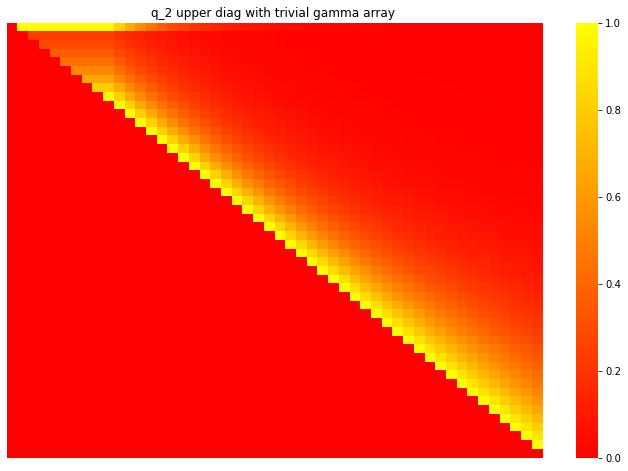

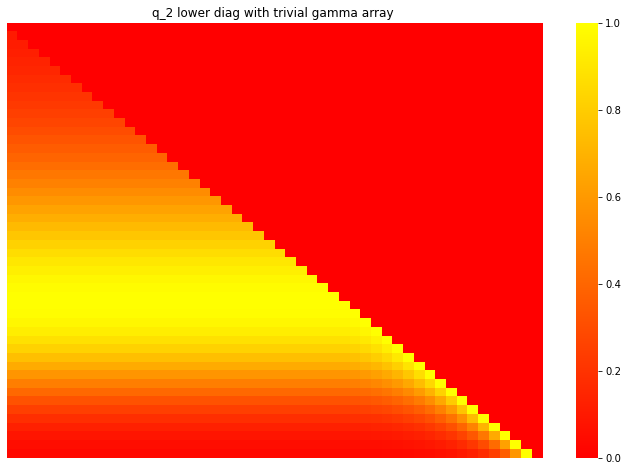

In [199]:
heatmaps_seq(normalise(q_2_upperC,'colmax'),title="q_2 upper diag with trivial gamma array ")

heatmaps_seq(normalise(q_2_lowerC,'colmax'),title="q_2 lower diag with trivial gamma array ")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


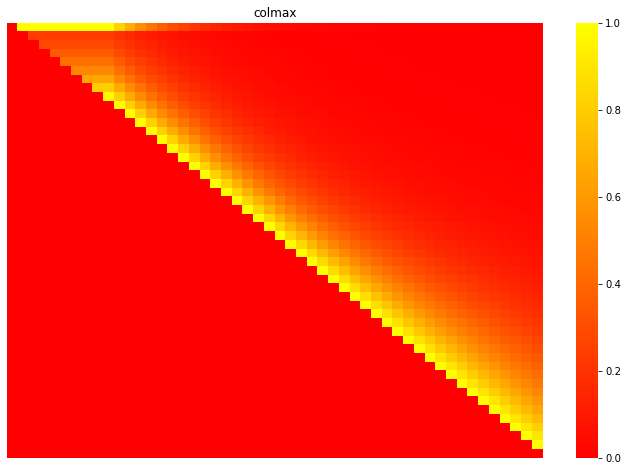

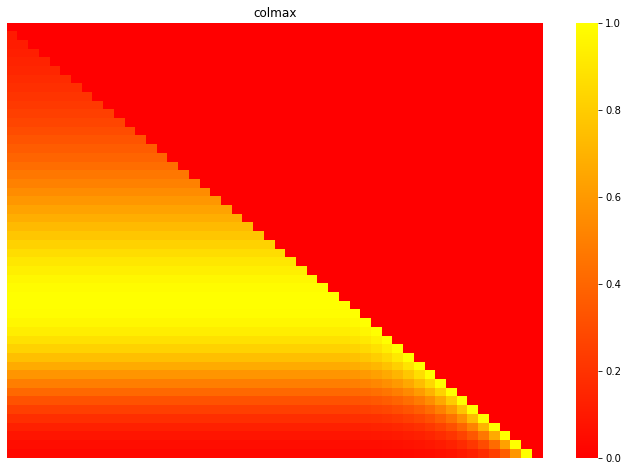

In [200]:
heatmaps_seq(normalise(q_2_upperAc,'colmax'),'colmax')

heatmaps_seq(normalise(q_2_lowerAc,'colmax'),'colmax')

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


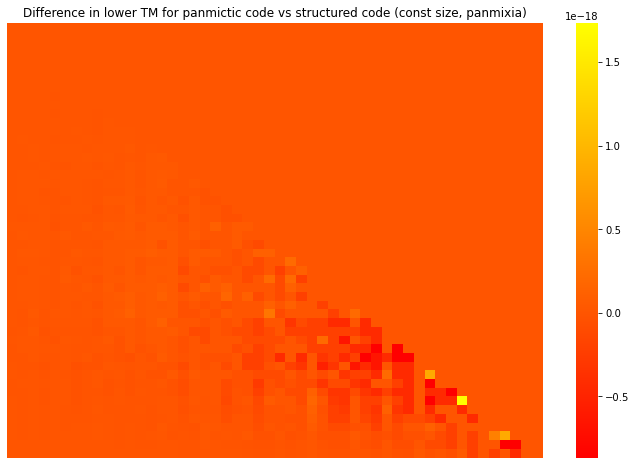

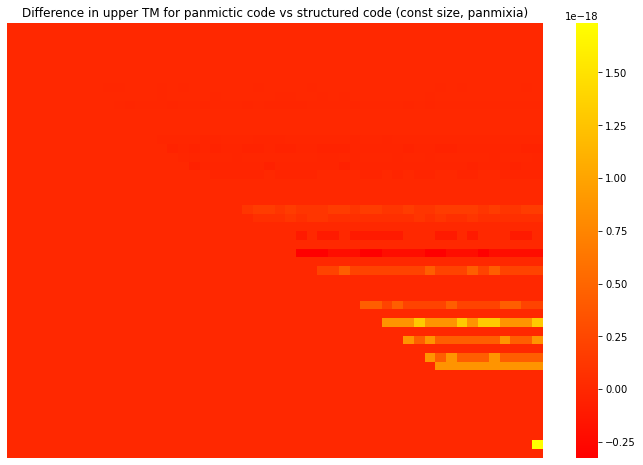

In [201]:
# q_2_lowerA # matrix from theoretical panmixia with const size
diff_lower = q_2_lowerAc - q_2_lowerC 
diff_upper = q_2_upperC - q_2_upperAc
heatmaps_seq(diff_lower,title="Difference in lower TM for panmictic code vs structured code (const size, panmixia)")
heatmaps_seq(diff_upper,title="Difference in upper TM for panmictic code vs structured code (const size, panmixia)")

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


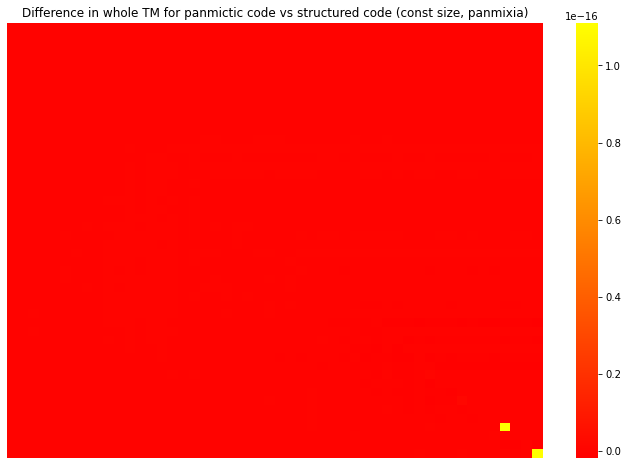

In [205]:
diff_all =  q_Ac - q_C
heatmaps_seq(diff_all,title="Difference in whole TM for panmictic code vs structured code (const size, panmixia)")


In [207]:
diff_all 

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.23516474e-22,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.47032947e-22, -4.23516474e-21,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.35274710e-22, -2.54109884e-21, -4.23516474e-22, ...,
        -8.67361738e-19,  0.00000000e+00, -1.73472348e-18],
       [-2.11758237e-22, -2.11758237e-21, -8.47032947e-22, ...,
        -4.33680869e-19,  0.00000000e+00,  1.11022302e-16]])

## Now try my theory for structured transition matrix and see if it fits observations

In [228]:
T_1 = T_np[25]*2*N_0
T_2 = T_np[32]*2*N_0
print('T_1 is {} and T_2 is {}'.format(T_1,T_2))
mig_prop = 0.2
seq_length=150e+06
N_0 = 10000

sim3 = split(N_0,mig_prop,T_1,T_2,seq_length)

T_1 is 9381.442505494031 and T_2 is 19711.381766577215
N is 10000
mig_prop is 0.2
t_1 is 9381.442505494031 and t_2 is 19711.381766577215
seq_length is 150000000.0
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 9381.442505494031 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 9381.442505494031
   - Mass migration: Lineages moved with probability 0.2 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forwards in time)
Epoch: 9381.442505494031 -- 19711.381766577215 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ g

In [220]:
args

Namespace(Number_of_states=50, bin_length=50, model='m0001', print=False, tree=False)

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


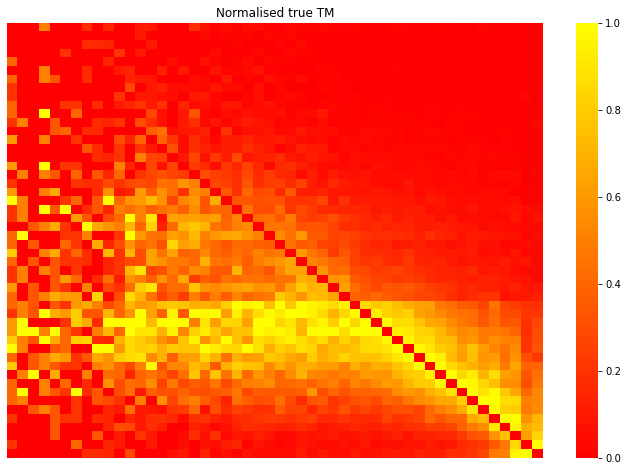

In [229]:
tmrca_data3 = get_coal_data(sim3, args) # get true coalescent 
coal_times_absolute3 = round_bin_coal_data(sim3.sequence_length,tmrca_data3, args) # partition coalescent data into bins  
coal_times3 = coal_times_absolute3/(2e+04) # scale by 2N
# T_scaled, T, N_0 = scaled_time_intervals(sim,N_T = args.Number_of_states) # get scaled time intervals
coal_times_intervals3 = round_coal_times(coal_times3,T_np,N_T=args.Number_of_states) # round binned coalescent times into their respected interval
tm3 = tm_counts(coal_times_intervals3,N_T=args.Number_of_states) # generate a matrix of counts, where each element counts the number of times state j transitions to state i for matrix [i,j]

# remove diagonals. let nd stand for 'nodiagonals'
tm_nd3 = np.copy(tm3)
tm_nd3[range(0,len(tm3)),range(0,len(tm3))] = 0
tm_nd_norm3 = normalise(tm_nd3,'colsum') # normalise over max of each columnn (return a probability distribution over columns)

heatmaps_seq(normalise(tm_nd3,'colmax'),title='Normalised true TM') # show heatmap


Now test with my theory

[1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  0.2 0.2 0.2 0.2 0.2 0.2 0.2 1.  1.  1.  1.
 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. ]
expected_times conforms with T.


Upper_diag:
For alpha  0 and beta 1 we have q_2[alpha,beta] = 2.639475074593914e-05
with pre = 0.03996894030295883
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 2 we have q_2[alpha,beta] = 2.6392457045993246e-05
with pre = 0.03996546700794299
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 3 we have q_2[alpha,beta] = 2.6389907025621133e-05
with pre = 0.039961605573030974
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 4 we have q_2[alpha,beta] = 2.6387072082607332e-05
with pre = 0.039957312686571406
A = 0.0
and B = 0.000660381549920281


Upper_diag:
For alpha  0 and beta 5 we have q_2[alpha,beta] = 2.6383920432893147e-05
with pre = 0.03995254021872374
A = 0.0
and B = 0.000660381



Upper_diag:
For alpha  6 and beta 17 we have q_2[alpha,beta] = 1.7232314059844744e-05
with pre = 0.03983089833542227
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 18 we have q_2[alpha,beta] = 1.722415532170869e-05
with pre = 0.03981204016767336
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 19 we have q_2[alpha,beta] = 1.7215090134328085e-05
with pre = 0.03979108682642769
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 20 we have q_2[alpha,beta] = 1.7205018593474158e-05
with pre = 0.039767807392311026
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 21 we have q_2[alpha,beta] = 1.7193829973423714e-05
with pre = 0.03974194593306677
A = 0.00040827997940467883
and B = 2.4356862343873076e-05


Upper_diag:
For alpha  6 and beta 22 we have q_2[alpha,beta] = 1.7181401599542135e-05
with pre = 0.03971321889763



Upper_diag:
For alpha  9 and beta 16 we have q_2[alpha,beta] = 3.180111638225608e-05
with pre = 0.039847869612552954
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 17 we have q_2[alpha,beta] = 3.1787572231353264e-05
with pre = 0.03983089833542227
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 18 we have q_2[alpha,beta] = 3.177252222257813e-05
with pre = 0.03981204016767336
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 19 we have q_2[alpha,beta] = 3.175580013304036e-05
with pre = 0.03979108682642769
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 20 we have q_2[alpha,beta] = 3.173722167449652e-05
with pre = 0.039767807392311026
A = 0.00075211710745602
and B = 4.59460435094719e-05


Upper_diag:
For alpha  9 and beta 21 we have q_2[alpha,beta] = 3.171658259684348e-05
with pre = 0.03974194593306677
A = 0.00075211710745602




Upper_diag:
For alpha  11 and beta 19 we have q_2[alpha,beta] = 4.7541480814533354e-05
with pre = 0.03979108682642769
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 20 we have q_2[alpha,beta] = 4.7513667078877966e-05
with pre = 0.039767807392311026
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 21 we have q_2[alpha,beta] = 4.7482768398631816e-05
with pre = 0.03974194593306677
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 22 we have q_2[alpha,beta] = 4.744844599347236e-05
with pre = 0.039713218897635974
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 23 we have q_2[alpha,beta] = 4.741032467634033e-05
with pre = 0.03968131226338838
A = 0.0011246561233348989
and B = 7.012101411584676e-05


Upper_diag:
For alpha  11 and beta 24 we have q_2[alpha,beta] = 4.736798912934206e-05
with pre = 0.039645878419141405




Upper_diag:
For alpha  12 and beta 48 we have q_2[alpha,beta] = 5.224945693489945e-05
with pre = 0.03580207730996278
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  12 and beta 49 we have q_2[alpha,beta] = 5.162253051467247e-05
with pre = 0.035372498334767105
A = 0.0013727824844417134
and B = 8.661487070448642e-05


Upper_diag:
For alpha  13 and beta 14 we have q_2[alpha,beta] = 7.099402446748706e-05
with pre = 0.039876884230771
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 15 we have q_2[alpha,beta] = 7.096955841837325e-05
with pre = 0.03986314180927266
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 16 we have q_2[alpha,beta] = 7.094236886411127e-05
with pre = 0.039847869612552954
A = 0.0016733523932083853
and B = 0.00010697788677634101


Upper_diag:
For alpha  13 and beta 17 we have q_2[alpha,beta] = 7.09121543855455e-05
with pre = 0.03983089833542227
A = 



Upper_diag:
For alpha  14 and beta 29 we have q_2[alpha,beta] = 8.545097807771947e-05
with pre = 0.0394008298164379
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 30 we have q_2[alpha,beta] = 8.530730928889952e-05
with pre = 0.03933458517388881
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 31 we have q_2[alpha,beta] = 8.51479702459421e-05
with pre = 0.039261115090152975
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 32 we have q_2[alpha,beta] = 8.497130179554419e-05
with pre = 0.03917965454160628
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 33 we have q_2[alpha,beta] = 8.477548082758803e-05
with pre = 0.03908936290531965
A = 0.00203664709428652
and B = 0.000132113778918988


Upper_diag:
For alpha  14 and beta 34 we have q_2[alpha,beta] = 8.455850684088019e-05
with pre = 0.03898931776461811
A = 0.0020366470942865



Upper_diag:
For alpha  16 and beta 48 we have q_2[alpha,beta] = 0.0001146686645968498
with pre = 0.03580207730996278
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  16 and beta 49 we have q_2[alpha,beta] = 0.00011329278780070469
with pre = 0.035372498334767105
A = 0.003001434214382304
and B = 0.00020141526287248412


Upper_diag:
For alpha  17 and beta 18 we have q_2[alpha,beta] = 0.0001545351500499375
with pre = 0.03981204016767336
A = 0.003632978885758021
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 19 we have q_2[alpha,beta] = 0.00015445381717375708
with pre = 0.03979108682642769
A = 0.003632978885758021
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 20 we have q_2[alpha,beta] = 0.00015436345529254864
with pre = 0.039767807392311026
A = 0.003632978885758021
and B = 0.00024863957436342676


Upper_diag:
For alpha  17 and beta 21 we have q_2[alpha,beta] = 0.00015426307097494047
with pre = 0.03974194593306677




Upper_diag:
For alpha  18 and beta 49 we have q_2[alpha,beta] = 0.00016605954791841184
with pre = 0.035372498334767105
A = 0.004387709609877114
and B = 0.0003068852232843977


Upper_diag:
For alpha  19 and beta 20 we have q_2[alpha,beta] = 0.00022529018638370232
with pre = 0.039767807392311026
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 21 we have q_2[alpha,beta] = 0.00022514367760297384
with pre = 0.03974194593306677
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 22 we have q_2[alpha,beta] = 0.00022498093493268756
with pre = 0.039713218897635974
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 23 we have q_2[alpha,beta] = 0.00022480017939075875
with pre = 0.03968131226338838
A = 0.0052864342504621254
and B = 0.00037870549841076406


Upper_diag:
For alpha  19 and beta 24 we have q_2[alpha,beta] = 0.00022459944171125985
with pre = 0.039645878419



Upper_diag:
For alpha  20 and beta 44 we have q_2[alpha,beta] = 0.00025354455592544915
with pre = 0.03717839453313952
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 45 we have q_2[alpha,beta] = 0.0002515140686010826
with pre = 0.0368806549166674
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 46 we have q_2[alpha,beta] = 0.00024928390716343995
with pre = 0.03655363617434563
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 47 we have q_2[alpha,beta] = 0.00024683771144644323
with pre = 0.03619493934041116
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 48 we have q_2[alpha,beta] = 0.0002441585202037655
with pre = 0.03580207730996278
A = 0.006352436463962793
and B = 0.000467238218316679


Upper_diag:
For alpha  20 and beta 49 we have q_2[alpha,beta] = 0.00024122893134258402
with pre = 0.035372498334767105
A = 0.006352



Upper_diag:
For alpha  23 and beta 32 we have q_2[alpha,beta] = 0.00045834605115520685
with pre = 0.03917965454160628
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 33 we have q_2[alpha,beta] = 0.0004572897678513209
with pre = 0.03908936290531965
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 34 we have q_2[alpha,beta] = 0.0004561193824634374
with pre = 0.03898931776461811
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 35 we have q_2[alpha,beta] = 0.0004548230724247502
with pre = 0.03887850852045298
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 36 we have q_2[alpha,beta] = 0.00045338790752267515
with pre = 0.03875582989164878
A = 0.010822354206322726
and B = 0.0008762188545620442


Upper_diag:
For alpha  23 and beta 37 we have q_2[alpha,beta] = 0.0004517997738764123
with pre = 0.03862007541646643
A = 0.010



Upper_diag:
For alpha  25 and beta 44 we have q_2[alpha,beta] = 0.0012361443221834295
with pre = 0.02528130828253488
A = 0.04250799263007758
and B = 0.00638759095162324


Upper_diag:
For alpha  25 and beta 45 we have q_2[alpha,beta] = 0.0012262447786175281
with pre = 0.02507884534333384
A = 0.04250799263007758
and B = 0.00638759095162324


Upper_diag:
For alpha  25 and beta 46 we have q_2[alpha,beta] = 0.0012153717334889038
with pre = 0.024856472598555033
A = 0.04250799263007758
and B = 0.00638759095162324


Upper_diag:
For alpha  25 and beta 47 we have q_2[alpha,beta] = 0.0012034454235924925
with pre = 0.024612558751479593
A = 0.04250799263007758
and B = 0.00638759095162324


Upper_diag:
For alpha  25 and beta 48 we have q_2[alpha,beta] = 0.001190383155185304
with pre = 0.024345412570774695
A = 0.04250799263007758
and B = 0.00638759095162324


Upper_diag:
For alpha  25 and beta 49 we have q_2[alpha,beta] = 0.0011761000851984013
with pre = 0.024053298867641636
A = 0.04250799263007758



Upper_diag:
For alpha  28 and beta 39 we have q_2[alpha,beta] = 0.0036478712842961357
with pre = 0.026046699208838023
A = 0.12800285039541448
and B = 0.012048342081917154


Upper_diag:
For alpha  28 and beta 40 we have q_2[alpha,beta] = 0.00363041231157175
with pre = 0.025922037844550022
A = 0.12800285039541448
and B = 0.012048342081917154


Upper_diag:
For alpha  28 and beta 41 we have q_2[alpha,beta] = 0.003611140654002778
with pre = 0.02578443346412255
A = 0.12800285039541448
and B = 0.012048342081917154


Upper_diag:
For alpha  28 and beta 42 we have q_2[alpha,beta] = 0.0035898851966031
with pre = 0.025632664264419958
A = 0.12800285039541448
and B = 0.012048342081917154


Upper_diag:
For alpha  28 and beta 43 we have q_2[alpha,beta] = 0.003566462601344889
with pre = 0.025465421166779058
A = 0.12800285039541448
and B = 0.012048342081917154


Upper_diag:
For alpha  28 and beta 44 we have q_2[alpha,beta] = 0.003540677372356051
with pre = 0.02528130828253488
A = 0.12800285039541448
a



Upper_diag:
For alpha  30 and beta 49 we have q_2[alpha,beta] = 0.005700307549480588
with pre = 0.024053298867641636
A = 0.21859979667075533
and B = 0.018386721513205032


Upper_diag:
For alpha  31 and beta 32 we have q_2[alpha,beta] = 0.007991629990568476
with pre = 0.02664216508829228
A = 0.27725060195672646
and B = 0.02271113028553577


Upper_diag:
For alpha  31 and beta 33 we have q_2[alpha,beta] = 0.007973212846341757
with pre = 0.026580766775617368
A = 0.27725060195672646
and B = 0.02271113028553577


Upper_diag:
For alpha  31 and beta 34 we have q_2[alpha,beta] = 0.007952806241020825
with pre = 0.02651273607994032
A = 0.27725060195672646
and B = 0.02271113028553577


Upper_diag:
For alpha  31 and beta 35 we have q_2[alpha,beta] = 0.007930204038697628
with pre = 0.02643738579390803
A = 0.27725060195672646
and B = 0.02271113028553577


Upper_diag:
For alpha  31 and beta 36 we have q_2[alpha,beta] = 0.007905180790774085
with pre = 0.02635396432632118
A = 0.27725060195672646
and B



Upper_diag:
For alpha  33 and beta 48 we have q_2[alpha,beta] = 0.004442145699361463
with pre = 0.03580207730996278
A = 0.1171358496171812
and B = 0.006939232979362164


Upper_diag:
For alpha  33 and beta 49 we have q_2[alpha,beta] = 0.004388845652532321
with pre = 0.035372498334767105
A = 0.1171358496171812
and B = 0.006939232979362164


Upper_diag:
For alpha  34 and beta 35 we have q_2[alpha,beta] = 0.004745839233916326
with pre = 0.03887850852045298
A = 0.1135642149322564
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 36 we have q_2[alpha,beta] = 0.0047308640439746715
with pre = 0.03875582989164878
A = 0.1135642149322564
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 37 we have q_2[alpha,beta] = 0.004714292705746478
with pre = 0.03862007541646643
A = 0.1135642149322564
and B = 0.008504234052088333


Upper_diag:
For alpha  34 and beta 38 we have q_2[alpha,beta] = 0.0046959648223653125
with pre = 0.03846993110371682
A = 0.1135642149322564
and B 



Upper_diag:
For alpha  37 and beta 44 we have q_2[alpha,beta] = 0.004537318700134072
with pre = 0.03717839453313952
A = 0.1064818076084651
and B = 0.015560006114547192


Upper_diag:
For alpha  37 and beta 45 we have q_2[alpha,beta] = 0.0045009820173226205
with pre = 0.0368806549166674
A = 0.1064818076084651
and B = 0.015560006114547192


Upper_diag:
For alpha  37 and beta 46 we have q_2[alpha,beta] = 0.004461072056888253
with pre = 0.03655363617434563
A = 0.1064818076084651
and B = 0.015560006114547192


Upper_diag:
For alpha  37 and beta 47 we have q_2[alpha,beta] = 0.004417296044698188
with pre = 0.03619493934041116
A = 0.1064818076084651
and B = 0.015560006114547192


Upper_diag:
For alpha  37 and beta 48 we have q_2[alpha,beta] = 0.0043693504499593624
with pre = 0.03580207730996278
A = 0.1064818076084651
and B = 0.015560006114547192


Upper_diag:
For alpha  37 and beta 49 we have q_2[alpha,beta] = 0.0043169238526892095
with pre = 0.035372498334767105
A = 0.1064818076084651
and B 



Upper_diag:
For alpha  42 and beta 47 we have q_2[alpha,beta] = 0.005912820476224839
with pre = 0.03619493934041116
A = 0.12188624739301761
and B = 0.04147417215666391


Upper_diag:
For alpha  42 and beta 48 we have q_2[alpha,beta] = 0.005848642370105652
with pre = 0.03580207730996278
A = 0.12188624739301761
and B = 0.04147417215666391


Upper_diag:
For alpha  42 and beta 49 we have q_2[alpha,beta] = 0.005778466168487964
with pre = 0.035372498334767105
A = 0.12188624739301761
and B = 0.04147417215666391


Upper_diag:
For alpha  43 and beta 44 we have q_2[alpha,beta] = 0.00667042808620472
with pre = 0.03717839453313952
A = 0.12921849234826774
and B = 0.05019829447018764


Upper_diag:
For alpha  43 and beta 45 we have q_2[alpha,beta] = 0.006617008600908733
with pre = 0.0368806549166674
A = 0.12921849234826774
and B = 0.05019829447018764


Upper_diag:
For alpha  43 and beta 46 we have q_2[alpha,beta] = 0.006558335948931949
with pre = 0.03655363617434563
A = 0.12921849234826774
and B = 0



Lower_diag:
For alpha  15 and beta 5 we have q_2[alpha,beta] = 3.6334537860822065e-05
with pre = 0.0006490375883325694
A = 0.05284944373853618
B=0.00313273435714001


Lower_diag:
For alpha  15 and beta 6 we have q_2[alpha,beta] = 4.040019488226781e-05
with pre = 0.0006532767387038533
A = 0.05836074808893523
B=0.0034816419560931844


Lower_diag:
For alpha  15 and beta 7 we have q_2[alpha,beta] = 4.4921553289697714e-05
with pre = 0.00065802268856525
A = 0.06439827708486077
B=0.0038692068033384097


Lower_diag:
For alpha  15 and beta 8 we have q_2[alpha,beta] = 4.9950076980317047e-05
with pre = 0.0006633401082912427
A = 0.07100119019742739
B=0.004299664305382533


Lower_diag:
For alpha  15 and beta 9 we have q_2[alpha,beta] = 5.55432089141475e-05
with pre = 0.0006693028983811663
A = 0.07820895259903739
B=0.004777702693340824


Lower_diag:
For alpha  15 and beta 10 we have q_2[alpha,beta] = 6.176513298809858e-05
with pre = 0.0006759957371768701
A = 0.08606060730852329
B=0.005308508783902



Lower_diag:
For alpha  18 and beta 17 we have q_2[alpha,beta] = 0.00016787530361689538
with pre = 0.0009716600203658846
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  19 and beta 0 we have q_2[alpha,beta] = 1.5623391772517405e-05
with pre = 0.0008703340395108316
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  19 and beta 1 we have q_2[alpha,beta] = 3.319015764301497e-05
with pre = 0.0008880512329779268
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  19 and beta 2 we have q_2[alpha,beta] = 3.6902818198340975e-05
with pre = 0.0008918419247260969
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  19 and beta 3 we have q_2[alpha,beta] = 4.1030936536865134e-05
with pre = 0.000896075744422267
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:
For alpha  19 and beta 4 we have q_2[alpha,beta] = 4.562112073021597e-05
with pre = 0.0009008068695219079
A = 0.047826070605396974
B=0.0028186594402662135


Lower_di



Lower_diag:
For alpha  21 and beta 16 we have q_2[alpha,beta] = 0.00018981984462762753
with pre = 0.001197516567866
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  21 and beta 17 we have q_2[alpha,beta] = 0.00021126703727602418
with pre = 0.001222810796582243
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  21 and beta 18 we have q_2[alpha,beta] = 0.0002352048040721058
with pre = 0.001251561975482095
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  21 and beta 19 we have q_2[alpha,beta] = 0.0002619490065810232
with pre = 0.0012843232307958904
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  21 and beta 20 we have q_2[alpha,beta] = 0.0002918656105693499
with pre = 0.0013217563334676171
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  22 and beta 0 we have q_2[alpha,beta] = 1.9468418392648398e-05
with pre = 0.001084529369119856
A = 0
B=0.01795102921781444


Lower_diag:
For



Lower_diag:
For alpha  25 and beta 13 we have q_2[alpha,beta] = 0.00012174949323449268
with pre = 0.0010051971903012155
A = 0.11384205511886075
B=0.007277954376996909


Lower_diag:
For alpha  25 and beta 14 we have q_2[alpha,beta] = 0.00013543117178964437
with pre = 0.0010206000142100153
A = 0.12461409816569376
B=0.008083501191556375


Lower_diag:
For alpha  25 and beta 15 we have q_2[alpha,beta] = 0.00015067175020148265
with pre = 0.0010380031135296482
A = 0.13617827436266838
B=0.0089771189474106


Lower_diag:
For alpha  25 and beta 16 we have q_2[alpha,beta] = 0.000167657592007754
with pre = 0.001057701551445596
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  25 and beta 17 we have q_2[alpha,beta] = 0.0001866007361337567
with pre = 0.0010800425742537114
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  25 and beta 18 we have q_2[alpha,beta] = 0.00020774366956596586
with pre = 0.0011054369340014476
A = 0.17564410956992818
B=0.01228490128



Lower_diag:
For alpha  27 and beta 25 we have q_2[alpha,beta] = 0.0005883539675284657
with pre = 0.001616136046976676
A = 0.29378827558275905
B=0.07026150143267608


Lower_diag:
For alpha  27 and beta 26 we have q_2[alpha,beta] = 0.0008125997441741985
with pre = 0.0016751991678610925
A = 0.40715629788104735
B=0.07792019914929223


Lower_diag:
For alpha  28 and beta 0 we have q_2[alpha,beta] = 1.9499713657546687e-05
with pre = 0.0010862727379550665
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  28 and beta 1 we have q_2[alpha,beta] = 4.14249722282515e-05
with pre = 0.0011083857467340842
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  28 and beta 2 we have q_2[alpha,beta] = 4.605878150543256e-05
with pre = 0.0011131169475341158
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  28 and beta 3 we have q_2[alpha,beta] = 5.121112785363644e-05
with pre = 0.0011184012208183733
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:
For



Lower_diag:
For alpha  29 and beta 28 we have q_2[alpha,beta] = 0.0015141848141579529
with pre = 0.002047994433798595
A = 0.6436025187706186
B=0.09574754447611653


Lower_diag:
For alpha  30 and beta 0 we have q_2[alpha,beta] = 2.1801557111069852e-05
with pre = 0.0012145017896485948
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  30 and beta 1 we have q_2[alpha,beta] = 4.631498255407372e-05
with pre = 0.0012392251282708916
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  30 and beta 2 we have q_2[alpha,beta] = 5.1495789789115876e-05
with pre = 0.0012445148236098745
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha  30 and beta 3 we have q_2[alpha,beta] = 5.725634479720985e-05
with pre = 0.0012504228788675297
A = 0.04325362003275382
B=0.002535965046707611


Lower_diag:
For alpha  30 and beta 4 we have q_2[alpha,beta] = 6.366168649885646e-05
with pre = 0.0012570248956101984
A = 0.047826070605396974
B=0.0028186594402662135


Lower_diag:




Lower_diag:
For alpha  31 and beta 27 we have q_2[alpha,beta] = 0.001328695188452747
with pre = 0.00217710443299376
A = 0.523914932310295
B=0.0863889044356732


Lower_diag:
For alpha  31 and beta 28 we have q_2[alpha,beta] = 0.0016794529751580484
with pre = 0.002271526112790205
A = 0.6436025187706186
B=0.09574754447611653


Lower_diag:
For alpha  31 and beta 29 we have q_2[alpha,beta] = 0.002073585620365283
with pre = 0.002378272099687288
A = 0.7658048592570367
B=0.1060826008186767


Lower_diag:
For alpha  31 and beta 30 we have q_2[alpha,beta] = 0.002518088811515924
with pre = 0.00249881804186331
A = 0.890224624984644
B=0.11748732895908694


Lower_diag:
For alpha  32 and beta 0 we have q_2[alpha,beta] = 3.4652883490186174e-05
with pre = 0.0019304120710692712
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  32 and beta 1 we have q_2[alpha,beta] = 7.361619567445489e-05
with pre = 0.0019697090335936526
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  32 and b



Lower_diag:
For alpha  33 and beta 19 we have q_2[alpha,beta] = 0.0004948671230385679
with pre = 0.0024263094201847015
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  33 and beta 20 we have q_2[alpha,beta] = 0.0005513847786694096
with pre = 0.0024970270459827395
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  33 and beta 21 we have q_2[alpha,beta] = 0.0006147032109040581
with pre = 0.0025780758325383924
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  33 and beta 22 we have q_2[alpha,beta] = 0.000685774415636177
with pre = 0.0026712803452588526
A = 0.23810701101481418
B=0.018614233856893203


Lower_diag:
For alpha  33 and beta 23 we have q_2[alpha,beta] = 0.000765732277537331
with pre = 0.0027788682649315696
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  33 and beta 24 we have q_2[alpha,beta] = 0.0008559427203390227
with pre = 0.0029035805358243916
A = 0.27191177761166385
B=0.02287691854413



Lower_diag:
For alpha  35 and beta 17 we have q_2[alpha,beta] = 0.0003755064066038591
with pre = 0.002173426077732526
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  35 and beta 18 we have q_2[alpha,beta] = 0.0004180534357458154
with pre = 0.002224528474081288
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  35 and beta 19 we have q_2[alpha,beta] = 0.0004655886286992179
with pre = 0.0022827583873575464
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  35 and beta 20 we have q_2[alpha,beta] = 0.0005187624536663847
with pre = 0.0023492920504103797
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  35 and beta 21 we have q_2[alpha,beta] = 0.000578334691673428
with pre = 0.0024255456377541497
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  35 and beta 22 we have q_2[alpha,beta] = 0.0006452010143906267
with pre = 0.0025132357655598637
A = 0.23810701101481418
B=0.018614233856893



Lower_diag:
For alpha  36 and beta 33 we have q_2[alpha,beta] = 0.004321415002850579
with pre = 0.0042707521641481005
A = 0.9552718920830691
B=0.05659085170426187


Lower_diag:
For alpha  36 and beta 34 we have q_2[alpha,beta] = 0.004339825742978371
with pre = 0.004847253218367456
A = 0.8329422522589514
B=0.062374238848565855


Lower_diag:
For alpha  36 and beta 35 we have q_2[alpha,beta] = 0.004445100278938971
with pre = 0.005579892134634007
A = 0.7279438325642272
B=0.06868452004290271


Lower_diag:
For alpha  37 and beta 0 we have q_2[alpha,beta] = 2.8465649170718835e-05
with pre = 0.001585739114193507
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  37 and beta 1 we have q_2[alpha,beta] = 6.047210472241034e-05
with pre = 0.0016180196471832287
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  37 and beta 2 we have q_2[alpha,beta] = 6.723653170450653e-05
with pre = 0.0016249262461464293
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For alpha



Lower_diag:
For alpha  38 and beta 24 we have q_2[alpha,beta] = 0.0006482588340321377
with pre = 0.002199062726915181
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  38 and beta 25 we have q_2[alpha,beta] = 0.0008335825356254594
with pre = 0.002289748787815126
A = 0.29378827558275905
B=0.07026150143267608


Lower_diag:
For alpha  38 and beta 26 we have q_2[alpha,beta] = 0.001151294956066657
with pre = 0.0023734296819469453
A = 0.40715629788104735
B=0.07792019914929223


Lower_diag:
For alpha  38 and beta 27 we have q_2[alpha,beta] = 0.0015062729818642153
with pre = 0.0024680706414945642
A = 0.523914932310295
B=0.0863889044356732


Lower_diag:
For alpha  38 and beta 28 we have q_2[alpha,beta] = 0.0019039089347029769
with pre = 0.0025751116140333738
A = 0.6436025187706186
B=0.09574754447611653


Lower_diag:
For alpha  38 and beta 29 we have q_2[alpha,beta] = 0.00235071672019489
with pre = 0.0026961240158113495
A = 0.7658048592570367
B=0.1060826008186767


Lower_d



Lower_diag:
For alpha  40 and beta 6 we have q_2[alpha,beta] = 7.291427935748783e-05
with pre = 0.0011790339814550794
A = 0.05836074808893523
B=0.0034816419560931844


Lower_diag:
For alpha  40 and beta 7 we have q_2[alpha,beta] = 8.10744278655676e-05
with pre = 0.001187599472661717
A = 0.06439827708486077
B=0.0038692068033384097


Lower_diag:
For alpha  40 and beta 8 we have q_2[alpha,beta] = 9.0149908372581e-05
with pre = 0.0011971963527879618
A = 0.07100119019742739
B=0.004299664305382533


Lower_diag:
For alpha  40 and beta 9 we have q_2[alpha,beta] = 0.00010024439394362948
with pre = 0.0012079579974689772
A = 0.07820895259903739
B=0.004777702693340824


Lower_diag:
For alpha  40 and beta 10 we have q_2[alpha,beta] = 0.00011147372368798348
with pre = 0.001220037234192134
A = 0.08606060730852329
B=0.005308508783902766


Lower_diag:
For alpha  40 and beta 11 we have q_2[alpha,beta] = 0.00012396749885456684
with pre = 0.0012336096990019753
A = 0.09459385233060295
B=0.005897817729108



Lower_diag:
For alpha  41 and beta 21 we have q_2[alpha,beta] = 0.00030681758105369737
with pre = 0.001286798208763358
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  41 and beta 22 we have q_2[alpha,beta] = 0.00034229144019689336
with pre = 0.0013333194935539847
A = 0.23810701101481418
B=0.018614233856893203


Lower_diag:
For alpha  41 and beta 23 we have q_2[alpha,beta] = 0.00038220090762696774
with pre = 0.0013870199862129283
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  41 and beta 24 we have q_2[alpha,beta] = 0.000427227758561244
with pre = 0.0014492677776743938
A = 0.27191177761166385
B=0.02287691854413315


Lower_diag:
For alpha  41 and beta 25 we have q_2[alpha,beta] = 0.0005493632783312107
with pre = 0.0015090334152516693
A = 0.29378827558275905
B=0.07026150143267608


Lower_diag:
For alpha  41 and beta 26 we have q_2[alpha,beta] = 0.0007587481075481022
with pre = 0.001564182375755562
A = 0.40715629788104735
B=0.07792019914929



Lower_diag:
For alpha  42 and beta 34 we have q_2[alpha,beta] = 0.001997906663516036
with pre = 0.0022315088388962898
A = 0.8329422522589514
B=0.062374238848565855


Lower_diag:
For alpha  42 and beta 35 we have q_2[alpha,beta] = 0.0020463714428299398
with pre = 0.0025687906237993777
A = 0.7279438325642272
B=0.06868452004290271


Lower_diag:
For alpha  42 and beta 36 we have q_2[alpha,beta] = 0.0021494408598012886
with pre = 0.0030038693283556232
A = 0.6400018302201351
B=0.07555554756298394


Lower_diag:
For alpha  42 and beta 37 we have q_2[alpha,beta] = 0.0023275818104768723
with pre = 0.0035744954339271395
A = 0.5681435865749606
B=0.0830201520564417


Lower_diag:
For alpha  42 and beta 38 we have q_2[alpha,beta] = 0.0026103143976115694
with pre = 0.004336835388541602
A = 0.5107845593222982
B=0.09110925581034635


Lower_diag:
For alpha  42 and beta 39 we have q_2[alpha,beta] = 0.003041585356953459
with pre = 0.005376403139397348
A = 0.4658778483587765
B=0.09985081411172358


Lower_



Lower_diag:
For alpha  44 and beta 19 we have q_2[alpha,beta] = 0.00012369572491735366
with pre = 0.0006064741192761764
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  44 and beta 20 we have q_2[alpha,beta] = 0.00013782273408490642
with pre = 0.0006241505167984275
A = 0.20568764274101486
B=0.015128859649893134


Lower_diag:
For alpha  44 and beta 21 we have q_2[alpha,beta] = 0.0001536496480407256
with pre = 0.0006444092649349289
A = 0.22165146657596294
B=0.016783416970040765


Lower_diag:
For alpha  44 and beta 22 we have q_2[alpha,beta] = 0.00017141442525225184
with pre = 0.0006677064274049997
A = 0.23810701101481418
B=0.018614233856893203


Lower_diag:
For alpha  44 and beta 23 we have q_2[alpha,beta] = 0.00019140048864231074
with pre = 0.0006945988296210782
A = 0.2549164456009346
B=0.020638998030786893


Lower_diag:
For alpha  44 and beta 24 we have q_2[alpha,beta] = 0.00021394926102580384
with pre = 0.0007257715910271227
A = 0.27191177761166385
B=0.0228769



Lower_diag:
For alpha  45 and beta 27 we have q_2[alpha,beta] = 0.00036525946056250544
with pre = 0.0005984878982737584
A = 0.523914932310295
B=0.0863889044356732


Lower_diag:
For alpha  45 and beta 28 we have q_2[alpha,beta] = 0.0004616830805721995
with pre = 0.0006244445000042249
A = 0.6436025187706186
B=0.09574754447611653


Lower_diag:
For alpha  45 and beta 29 we have q_2[alpha,beta] = 0.0005700304868318012
with pre = 0.0006537890644536861
A = 0.7658048592570367
B=0.1060826008186767


Lower_diag:
For alpha  45 and beta 30 we have q_2[alpha,beta] = 0.0006922247998909616
with pre = 0.0006869272485871636
A = 0.890224624984644
B=0.11748732895908694


Lower_diag:
For alpha  45 and beta 31 we have q_2[alpha,beta] = 0.00083062164270621
with pre = 0.0007242748230714711
A = 1.016770237492172
B=0.13006189893878678


Lower_diag:
For alpha  45 and beta 32 we have q_2[alpha,beta] = 0.0008994758550319904
with pre = 0.0007850248155836344
A = 1.0944926816843406
B=0.05130021196229695


Lower_di



Lower_diag:
For alpha  46 and beta 38 we have q_2[alpha,beta] = 0.0008194468273621273
with pre = 0.001361447495820403
A = 0.5107845593222982
B=0.09110925581034635


Lower_diag:
For alpha  46 and beta 39 we have q_2[alpha,beta] = 0.0009548342043346085
with pre = 0.0016877953472693252
A = 0.4658778483587765
B=0.09985081411172358


Lower_diag:
For alpha  46 and beta 40 we have q_2[alpha,beta] = 0.0011580754408528474
with pre = 0.0021430822270911884
A = 0.431109867256067
B=0.10926857749670699


Lower_diag:
For alpha  46 and beta 41 we have q_2[alpha,beta] = 0.001462933947269956
with pre = 0.00279455051928904
A = 0.40411458314779003
B=0.11938067563255234


Lower_diag:
For alpha  46 and beta 42 we have q_2[alpha,beta] = 0.0019249909181072188
with pre = 0.0037533574967005554
A = 0.3826736860112423
B=0.13019803478791175


Lower_diag:
For alpha  46 and beta 43 we have q_2[alpha,beta] = 0.0026390340772033667
with pre = 0.005209355503782166
A = 0.36487246435876997
B=0.14172265576450438


Lower_



Lower_diag:
For alpha  47 and beta 44 we have q_2[alpha,beta] = 0.002514636939272133
with pre = 0.004997916121296127
A = 0.34919128517767195
B=0.15394579800731029


Lower_diag:
For alpha  47 and beta 45 we have q_2[alpha,beta] = 0.0037560367308493246
with pre = 0.007491486990321398
A = 0.33452785278692443
B=0.16684613821138128


Lower_diag:
For alpha  47 and beta 46 we have q_2[alpha,beta] = 0.00587916295049448
with pre = 0.011745427227636445
A = 0.3201610960748036
B=0.18038799733416866


Lower_diag:
For alpha  48 and beta 0 we have q_2[alpha,beta] = 1.8545464442583297e-06
with pre = 0.00010331142698034798
A = 0
B=0.01795102921781444


Lower_diag:
For alpha  48 and beta 1 we have q_2[alpha,beta] = 3.9397775935890025e-06
with pre = 0.00010541451436528042
A = 0.0353215837254756
B=0.0020525636327995422


Lower_diag:
For alpha  48 and beta 2 we have q_2[alpha,beta] = 4.380482245425853e-06
with pre = 0.00010586448156863854
A = 0.03909666892432382
B=0.0022815363105047615


Lower_diag:
For 



Lower_diag:
For alpha  49 and beta 15 we have q_2[alpha,beta] = 1.0298072082217899e-05
with pre = 7.094515641054616e-05
A = 0.13617827436266838
B=0.0089771189474106


Lower_diag:
For alpha  49 and beta 16 we have q_2[alpha,beta] = 1.1459015809653352e-05
with pre = 7.229149992413954e-05
A = 0.14854306596820516
B=0.009968181158747369


Lower_diag:
For alpha  49 and beta 17 we have q_2[alpha,beta] = 1.2753736707317015e-05
with pre = 7.381845811610845e-05
A = 0.16170464954982244
B=0.011066999070320327


Lower_diag:
For alpha  49 and beta 18 we have q_2[alpha,beta] = 1.4198808210258127e-05
with pre = 7.555410495643687e-05
A = 0.17564410956992818
B=0.01228490128189652


Lower_diag:
For alpha  49 and beta 19 we have q_2[alpha,beta] = 1.581329820189966e-05
with pre = 7.753183148614361e-05
A = 0.19032446903287428
B=0.013634316652793299


Lower_diag:
For alpha  49 and beta 20 we have q_2[alpha,beta] = 1.7619299248554595e-05
with pre = 7.979158739396852e-05
A = 0.20568764274101486
B=0.015128859

/home/trevor/ancestry/heatmaps_generate.py:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


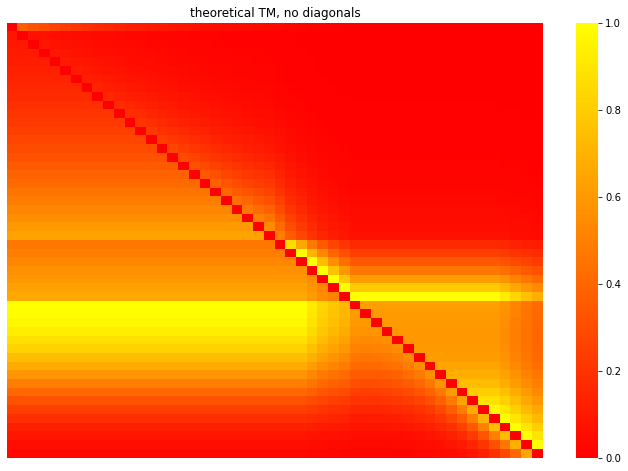

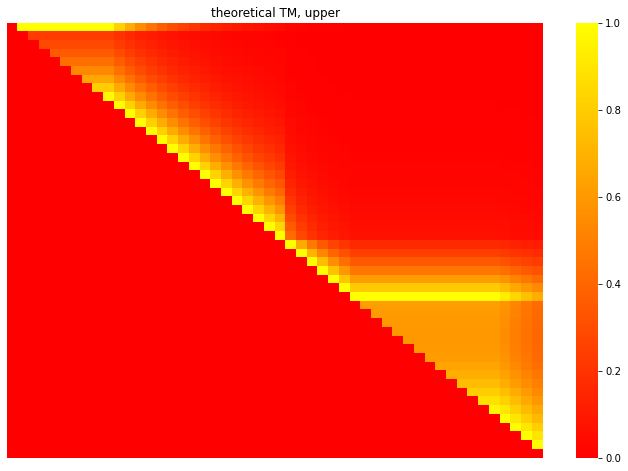

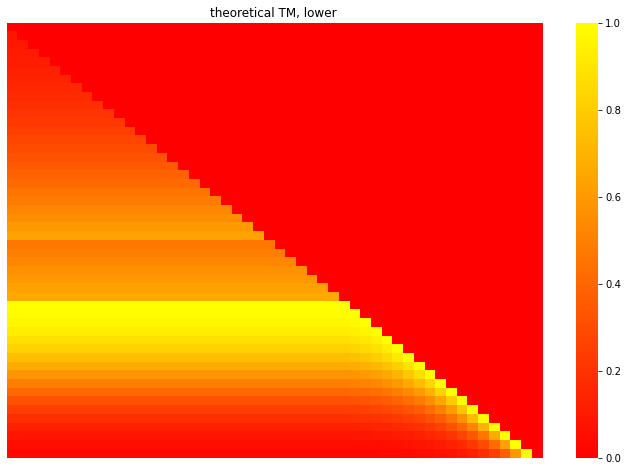

In [230]:
N_T = 50
lambda_array = pop_size1 = [1 for i in range(0,N_T)]
gamma_array_list = np.array([1 for i in range(0,N_T)],np.float)
gamma_array = np.array(gamma_array_list)

gamma_array[25:32] = 0.2
print(gamma_array)
q_2D, q_2_upperD, q_2_lowerD, q_1D, q_D = structuredsplit_abinitio(T_np,N_T,lambda_array,gamma_array,r=2e-08*args.bin_length)
heatmaps_seq(normalise(q_2D,'colmax'),title='theoretical TM, no diagonals') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_upperD,'colmax'),title='theoretical TM, upper') # normalise this matrix and then plot heatmap
heatmaps_seq(normalise(q_2_lowerD,'colmax'),title='theoretical TM, lower ') # normalise this matrix and then plot heatmap


Now try and look at the actual differences.

/home/trevor/ancestry/heatmaps_generate.py:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


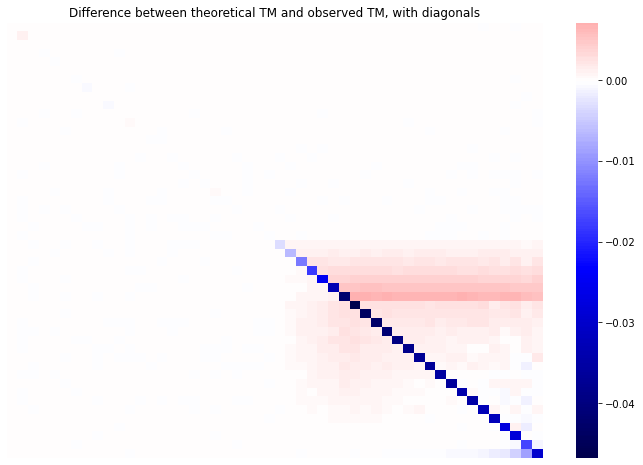

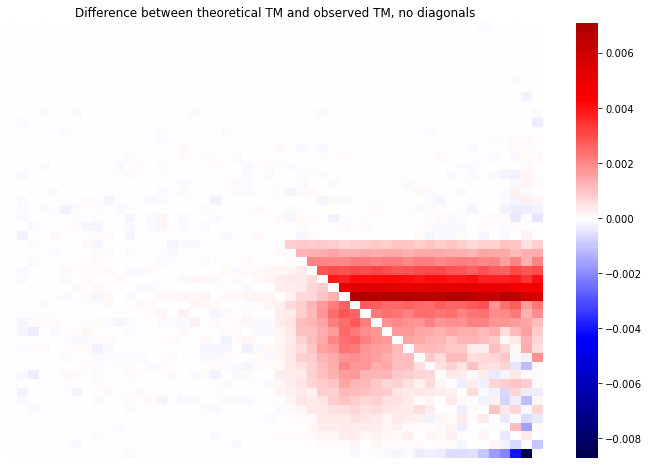

In [231]:
tm_3 = normalise(tm3,'colsum')
# [sum(tm_[:,i]) for i in range(0,50)]
diff_q_D_3 = q_D - tm_3 # difference between simulation 3's TM and theoretical TM for that history
diff_q_D_3_nd = np.copy(diff_q_D_3)
diff_q_D_3_nd = remove_diagonals(diff_q_D_3_nd)

# heatmaps_seq(q_2Bc,title="theoretical, no diagonals, no normalisation")
# heatmaps_seq(remove_diagonals(tm_3),title="observed, no diagonals, no normalisation")

heatmaps_div(diff_q_D_3,title="Difference between theoretical TM and observed TM, with diagonals")
heatmaps_div(diff_q_D_3_nd,title="Difference between theoretical TM and observed TM, no diagonals")